# This notebook uses pytorch lightning & optuna & a Recurrent Attentive Neural Process for Sequential Data (RANPfSQ)

This notebook trains an Attentional Neural Network on timeseries data from smartmeters.

It uses pytorch lighting for the training loop. And Optuna for the hyperparameter optimisation.

It also pushes results to the tensorboard hyperparameter dashboard for examination.

- https://github.com/optuna/optuna/blob/master/examples/pytorch_lightning_simple.py

- similar to https://arxiv.org/abs/1910.09323

Results on *Smartmeter* prediction

|Model|val_loss|
|--|--| 
|ANP-RNN|-1.27|
|ANP-RNN_imp|-1.38|
|ANP|-1.3|
|ANP_impr|-1.2|
|NP|-1.3|

In [1]:
import sys, re, os, itertools, functools, collections
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import collections
from pathlib import Path
from tqdm.auto import tqdm

import optuna
import pytorch_lightning as pl
from optuna.integration import PyTorchLightningPruningCallback


import math
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import nn
import torch.nn.functional as F

In [3]:

from neural_processes.data.smart_meter import collate_fns, SmartMeterDataSet, get_smartmeter_df
from neural_processes.plot import plot_from_loader

from neural_processes.dict_logger import DictLogger
from neural_processes.utils import PyTorchLightningPruningCallback
from neural_processes.train import main, objective, add_number, run_trial

from neural_processes.models.neural_process.lightning import PL_NP, PL_ANP, PL_ANPRNN

from neural_processes.models.transformer import PL_Transformer
from neural_processes.models.transformer_seq2seq import TransformerSeq2Seq_PL

from neural_processes.models.lstm_seqseq import LSTMSeq2Seq_PL
from neural_processes.models.lstm_std import LSTM_PL_STD

/home/wassname/.pyenv/versions/jup3.7.3/lib/python3.7/site-packages/pytorch_lightning/core/decorators.py:13: UserWarning:

data_loader decorator deprecated in 0.7.0. Will remove 0.9.0



In [4]:
# Params
device='cuda'
use_logy=False

In [5]:
import logging
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logger = logging.getLogger("RANP2.ipynb")

# Load kaggle smart meter data

In [6]:
df_train, df_val, df_test = get_smartmeter_df(
#     indir=Path('./data/smart-meters-in-london'), 
#     use_logy=False, 
#     max_files=40
)

In [7]:
data_train = SmartMeterDataSet(
    df_train, 10, 20)
b = data_train[10]
b = collate_fns(10, 20, sample=True)([b])
[bb.shape for bb in b]

[torch.Size([1, 4, 17]),
 torch.Size([1, 4, 1]),
 torch.Size([1, 8, 17]),
 torch.Size([1, 8, 1])]

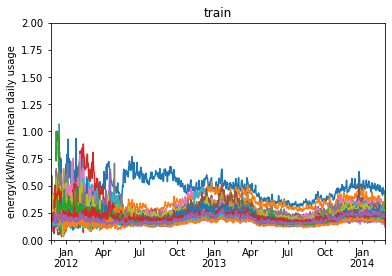

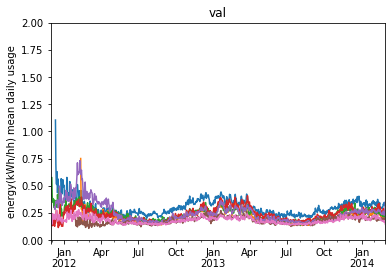

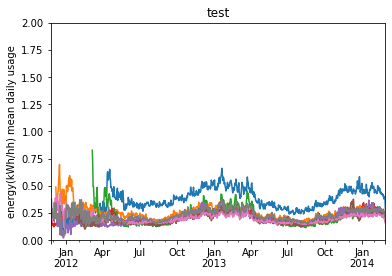

In [8]:
plt.figure()
for name,g in df_train.groupby('block'):
    g['energy(kWh/hh)'].resample('D').mean().plot(ax=plt.gca(), ylim=[0,2])
plt.title('train')
plt.ylabel('energy(kWh/hh) mean daily usage')
plt.show()

plt.figure()
for name,g in df_val.groupby('block'):
    g['energy(kWh/hh)'].resample('D').mean().plot(ax=plt.gca(), ylim=[0,2])
plt.title('val')
plt.ylabel('energy(kWh/hh) mean daily usage')
plt.show()

plt.figure()
for name,g in df_test.groupby('block'):
    g['energy(kWh/hh)'].resample('D').mean().plot(ax=plt.gca(), ylim=[0,2])
plt.title('test')
plt.ylabel('energy(kWh/hh) mean daily usage')
plt.show()

In [9]:
# df_train[['energy(kWh/hh)']].resample('30T').mean().plot(title='train', ylim=[0,3])
# df_val[['energy(kWh/hh)']].resample('30T').mean().plot(title='val', ylim=[0,3])
# df_test[['energy(kWh/hh)']].resample('30T').mean().plot(title='test', ylim=[0,3])

# Experiments

In [10]:
default_user_attrs = {
    'context_in_target': False,
    'x_dim': 17,
    'y_dim': 1,
    'vis_i': '670',
    'num_workers': 3,
    'num_context': 48 * 7,
    'num_extra_target': 48 * 2,
    'max_nb_epochs': 20,
    'min_std': 0.005,
    'grad_clip': 40,
    'batch_size': 24,
    'patience': 2,
    'max_epoch_steps': 32 * 600,
}
N = 3

experiments = [

    dict(name="anp-rnn",
         params={
             'det_enc_cross_attn_type': 'multihead',
             'det_enc_self_attn_type': 'multihead',
             'latent_enc_self_attn_type': 'multihead',
             'use_deterministic_path': True,
         },
         PL_MODEL_CLS=PL_ANPRNN),
    dict(name="anp-rnn_pt",
         params={
             'det_enc_cross_attn_type': 'ptmultihead',
             'det_enc_self_attn_type': 'ptmultihead',
             'latent_enc_self_attn_type': 'ptmultihead',
             'use_deterministic_path': True,
         },
         PL_MODEL_CLS=PL_ANPRNN),
    dict(name="anp-rnn_c",
         params={
             'det_enc_cross_attn_type': 'ptmultihead',
             'det_enc_self_attn_type': 'ptmultihead',
             'latent_enc_self_attn_type': 'ptmultihead',
             'use_deterministic_path': True,
             'batchnorm': False,
             'attention_dropout': 0.5,
             'dropout': 0.5,
             'hidden_dim_power': 5.0,
             'latent_dim_power': 8.0,
             'learning_rate': 0.001,
             'n_decoder_layers': 4,
             'n_det_encoder_layers': 1,
             'n_latent_encoder_layers': 4,
             'num_heads_power': 3.0
         },
         PL_MODEL_CLS=PL_ANPRNN),
    dict(name="anp-rnn_d",
         params={
             'det_enc_cross_attn_type': 'ptmultihead',
             'det_enc_self_attn_type': 'ptmultihead',
             'latent_enc_self_attn_type': 'ptmultihead',
             'use_deterministic_path': True,
             'batchnorm': False,
             'attention_dropout': 0.7,
             'dropout': 0.1,
             'hidden_dim_power': 6.0,
             'latent_dim_power': 6.0,
             'learning_rate': 0.001,
             'n_decoder_layers': 4,
             'n_det_encoder_layers': 3,
             'n_latent_encoder_layers': 4,
             'num_heads_power': 2.0
         },
         PL_MODEL_CLS=PL_ANPRNN),
    dict(name="anp-rnn_extras",
         params={
             'det_enc_cross_attn_type': 'ptmultihead',
             'det_enc_self_attn_type': 'ptmultihead',
             'latent_enc_self_attn_type': 'ptmultihead',
             'use_deterministic_path': True,
             'batchnorm': True,
             'attention_dropout': 0.4,
             'dropout': 0.2,
             'use_lvar': True,
         },
         PL_MODEL_CLS=PL_ANPRNN),
    dict(name="anp-rnn_extras_no_det",
         params={
             'det_enc_cross_attn_type': 'ptmultihead',
             'det_enc_self_attn_type': 'ptmultihead',
             'latent_enc_self_attn_type': 'ptmultihead',
             'use_deterministic_path': False,
             'batchnorm': True,
             'attention_dropout': 0.4,
             'dropout': 0.2,
             'use_lvar': True,
         },
         PL_MODEL_CLS=PL_ANPRNN),
    dict(
        name="anp-rnn_no_det",
        params={
            'use_deterministic_path': False,
        },
        PL_MODEL_CLS=PL_ANPRNN,
    ),

    dict(name="TransformerSeq2Seq_PL_lstm", params={'use_lstm':True}, PL_MODEL_CLS=TransformerSeq2Seq_PL),
    dict(name="TransformerSeq2Seq_PL", PL_MODEL_CLS=TransformerSeq2Seq_PL),
        dict(name="LSTMSeq2Seq_PL_attn",
         PL_MODEL_CLS=LSTMSeq2Seq_PL,
         params={
             'use_self_attn': True,
             'use_cross_attn': True
         }),
    dict(name="LSTMSeq2Seq_PL",
         PL_MODEL_CLS=LSTMSeq2Seq_PL,
         params={
             'use_self_attn': False,
             'use_cross_attn': False
         }),
    dict(name="anp_c", PL_MODEL_CLS=PL_ANP),
    dict(
        name="np",
        PL_MODEL_CLS=PL_NP,
    ),
    dict(
        name="PL_Transformer",
        PL_MODEL_CLS=PL_Transformer,
    ),
    dict(
        name="LSTM_PL_STD",
        PL_MODEL_CLS=LSTM_PL_STD,
    ),
]
number = -1
results = collections.defaultdict(list)

In [11]:
# Summarize results


def summarize_results(results):
    result_dfs = []
    for k in results:
        v = results[k]
        df = pd.DataFrame(v).mean()
        df.name = k+'_mean'
        df['n'] = len(v)
        result_dfs.append(df)

#         df = pd.DataFrame(v).std()
#         df.name = k+'_std'
#         df['n'] = len(v)
#         result_dfs.append(df)

    if len(result_dfs)==0:
        return None
    result_df = pd.concat(result_dfs, 1).T
    
    return result_df.sort_values('agg_test_score').T

0 {'name': 'anp-rnn', 'params': {'det_enc_cross_attn_type': 'multihead', 'det_enc_self_attn_type': 'multihead', 'latent_enc_self_attn_type': 'multihead', 'use_deterministic_path': True}, 'PL_MODEL_CLS': <class 'neural_processes.models.neural_process.lightning.PL_ANPRNN'>}
INFO:predict_heading2:now run `tensorboard --logdir lightning_logs`
INFO:root:GPU available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:predict_heading2:trial number=-1000 name=anp-rnn, trial=<optuna.trial.FixedTrial object at 0x7f8d6e34b668> params={'learning_rate': 0.003, 'num_heads_power': 2, 'hidden_dim_power': 6, 'latent_dim_power': 5, 'n_latent_encoder_layers': 3, 'n_det_encoder_layers': 3, 'n_decoder_layers': 4, 'dropout': 0.1, 'attention_dropout': 0.5, 'batchnorm': False, 'use_deterministic_path': True} attrs={'batch_size': 24, 'grad_clip': 40, 'max_nb_epochs': 20, 'num_workers': 3, 'num_context': 336, 'vis_i': '670', 'num_extra_target': 96, 'x_dim': 17, 'context_in_target': False, 'y_dim': 1, 'patience':

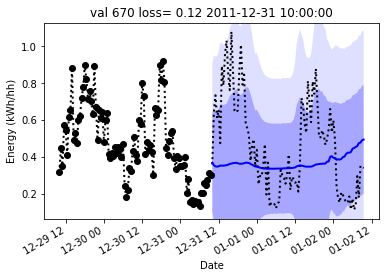

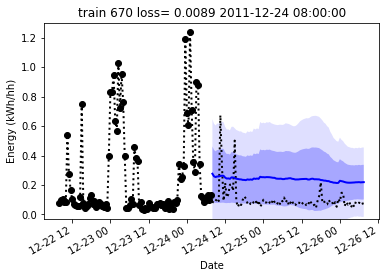

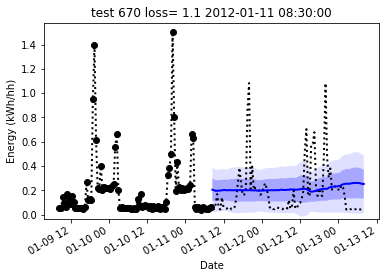

INFO:predict_heading2:step 0, {'agg_test_loss': 0.8992003798484802, 'log': {'agg_test_loss': 0.9083002209663391, 'agg_test_loss_p': 0.8992003798484802, 'agg_test_loss_kl': 0.009099768474698067, 'agg_test_loss_mse': 0.052030690014362335, 'agg_test_loss_p_weighted': 0.17229194939136505, 'agg_test_score': 0.8992003798484802}}
----------------------------------------------------------------------------------------------------
TEST RESULTS
{}
----------------------------------------------------------------------------------------------------



anp-rnn_mean
agg_test_loss                 0.908300
agg_test_loss_p               0.899200
agg_test_loss_kl              0.009100
agg_test_loss_mse             0.052031
agg_test_loss_p_weighted      0.172292
agg_test_score                0.899200
n                             1.000000

0 {'name': 'anp-rnn_pt', 'params': {'det_enc_cross_attn_type': 'ptmultihead', 'det_enc_self_attn_type': 'ptmultihead', 'latent_enc_self_attn_type': 'ptmultihead', 'use_deterministic_path': True}, 'PL_MODEL_CLS': <class 'neural_processes.models.neural_process.lightning.PL_ANPRNN'>}
INFO:predict_heading2:now run `tensorboard --logdir lightning_logs`
INFO:root:GPU available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:predict_heading2:trial number=-1000 name=anp-rnn_pt, trial=<optuna.trial.FixedTrial object at 0x7f8d6e35aba8> params={'learning_rate': 0.003, 'num_heads_power': 2, 'hidden_dim_power': 6, 'latent_dim_power': 5, 'n_latent_encoder_layers': 3, 'n_det_encoder_layers': 3, 'n_decoder_layers': 4, 'dropout': 0.1, 'attention_dropout': 0.5, 'batchnorm': False, 'use_deterministic_path': True} attrs={'batch_size': 24, 'grad_clip': 40, 'max_nb_epochs': 20, 'num_workers': 3, 'num_context': 336, 'vis_i': '670', 'num_extra_target': 96, 'x_dim': 17, 'context_in_target': False, 'y_dim': 1,

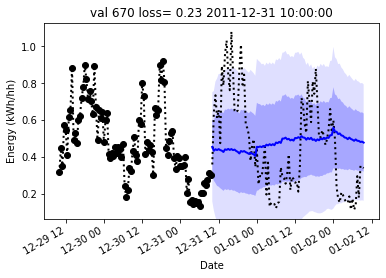

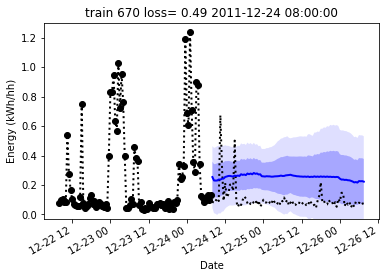

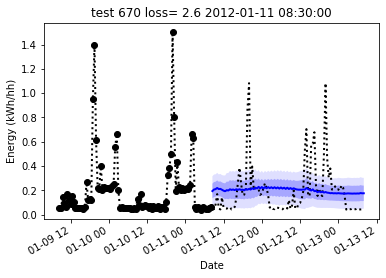

INFO:predict_heading2:step 0, {'agg_test_loss': 2.8069238662719727, 'log': {'agg_test_loss': 2.821727991104126, 'agg_test_loss_p': 2.8069238662719727, 'agg_test_loss_kl': 0.014804203994572163, 'agg_test_loss_mse': 0.04993298277258873, 'agg_test_loss_p_weighted': 0.5393860340118408, 'agg_test_score': 2.8069238662719727}}
----------------------------------------------------------------------------------------------------
TEST RESULTS
{}
----------------------------------------------------------------------------------------------------



anp-rnn_mean  anp-rnn_pt_mean
agg_test_loss                 0.908300         2.821728
agg_test_loss_p               0.899200         2.806924
agg_test_loss_kl              0.009100         0.014804
agg_test_loss_mse             0.052031         0.049933
agg_test_loss_p_weighted      0.172292         0.539386
agg_test_score                0.899200         2.806924
n                             1.000000         1.000000

0 {'name': 'anp-rnn_c', 'params': {'det_enc_cross_attn_type': 'ptmultihead', 'det_enc_self_attn_type': 'ptmultihead', 'latent_enc_self_attn_type': 'ptmultihead', 'use_deterministic_path': True, 'batchnorm': False, 'attention_dropout': 0.5, 'dropout': 0.5, 'hidden_dim_power': 5.0, 'latent_dim_power': 8.0, 'learning_rate': 0.001, 'n_decoder_layers': 4, 'n_det_encoder_layers': 1, 'n_latent_encoder_layers': 4, 'num_heads_power': 3.0}, 'PL_MODEL_CLS': <class 'neural_processes.models.neural_process.lightning.PL_ANPRNN'>}
INFO:predict_heading2:now run `tensorboard --logdir lightning_logs`
INFO:root:GPU available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:predict_heading2:trial number=-1000 name=anp-rnn_c, trial=<optuna.trial.FixedTrial object at 0x7f8ded9c2f60> params={'learning_rate': 0.001, 'num_heads_power': 3.0, 'hidden_dim_power': 5.0, 'latent_dim_power': 8.0, 'n_latent_encoder_layers': 4, 'n_det_encoder_layers': 1, 'n_decoder_layers': 4, 'dropout': 0.5, 'attention_dropout': 0.5, '

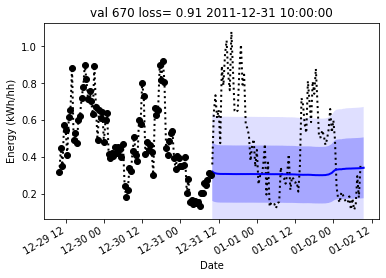

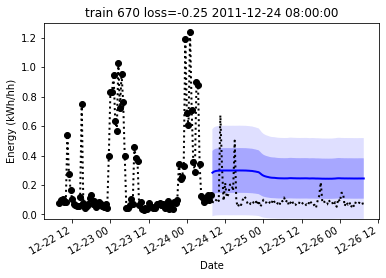

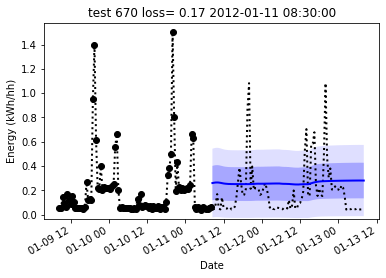

INFO:predict_heading2:step 0, {'agg_test_loss': 0.326419860124588, 'log': {'agg_test_loss': 0.32641997933387756, 'agg_test_loss_p': 0.326419860124588, 'agg_test_loss_kl': 1.4158050021251256e-07, 'agg_test_loss_mse': 0.05554043874144554, 'agg_test_loss_p_weighted': 0.06167767196893692, 'agg_test_score': 0.326419860124588}}
----------------------------------------------------------------------------------------------------
TEST RESULTS
{}
----------------------------------------------------------------------------------------------------



anp-rnn_c_mean  anp-rnn_mean  anp-rnn_pt_mean
agg_test_loss               3.264200e-01      0.908300         2.821728
agg_test_loss_p             3.264199e-01      0.899200         2.806924
agg_test_loss_kl            1.415805e-07      0.009100         0.014804
agg_test_loss_mse           5.554044e-02      0.052031         0.049933
agg_test_loss_p_weighted    6.167767e-02      0.172292         0.539386
agg_test_score              3.264199e-01      0.899200         2.806924
n                           1.000000e+00      1.000000         1.000000

0 {'name': 'anp-rnn_d', 'params': {'det_enc_cross_attn_type': 'ptmultihead', 'det_enc_self_attn_type': 'ptmultihead', 'latent_enc_self_attn_type': 'ptmultihead', 'use_deterministic_path': True, 'batchnorm': False, 'attention_dropout': 0.7, 'dropout': 0.1, 'hidden_dim_power': 6.0, 'latent_dim_power': 6.0, 'learning_rate': 0.001, 'n_decoder_layers': 4, 'n_det_encoder_layers': 3, 'n_latent_encoder_layers': 4, 'num_heads_power': 2.0}, 'PL_MODEL_CLS': <class 'neural_processes.models.neural_process.lightning.PL_ANPRNN'>}
INFO:predict_heading2:now run `tensorboard --logdir lightning_logs`
INFO:root:GPU available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:predict_heading2:trial number=-1000 name=anp-rnn_d, trial=<optuna.trial.FixedTrial object at 0x7f8d68ce6080> params={'learning_rate': 0.001, 'num_heads_power': 2.0, 'hidden_dim_power': 6.0, 'latent_dim_power': 6.0, 'n_latent_encoder_layers': 4, 'n_det_encoder_layers': 3, 'n_decoder_layers': 4, 'dropout': 0.1, 'attention_dropout': 0.7, '

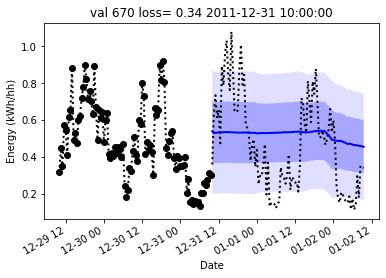

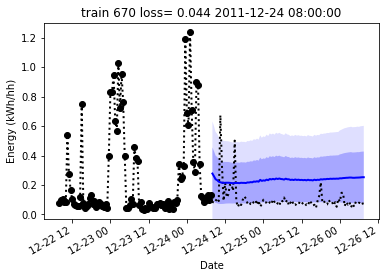

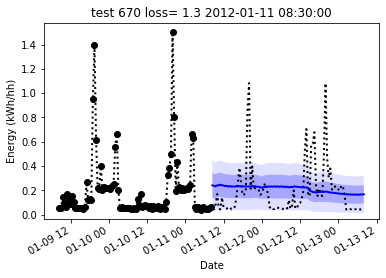

INFO:predict_heading2:step 0, {'agg_test_loss': 1.3981064558029175, 'log': {'agg_test_loss': 1.405924677848816, 'agg_test_loss_p': 1.3981064558029175, 'agg_test_loss_kl': 0.007818251848220825, 'agg_test_loss_mse': 0.05087464675307274, 'agg_test_loss_p_weighted': 0.25710582733154297, 'agg_test_score': 1.3981064558029175}}
----------------------------------------------------------------------------------------------------
TEST RESULTS
{}
----------------------------------------------------------------------------------------------------



anp-rnn_c_mean  anp-rnn_mean  anp-rnn_d_mean  \
agg_test_loss               3.264200e-01      0.908300        1.405925   
agg_test_loss_p             3.264199e-01      0.899200        1.398106   
agg_test_loss_kl            1.415805e-07      0.009100        0.007818   
agg_test_loss_mse           5.554044e-02      0.052031        0.050875   
agg_test_loss_p_weighted    6.167767e-02      0.172292        0.257106   
agg_test_score              3.264199e-01      0.899200        1.398106   
n                           1.000000e+00      1.000000        1.000000   

                          anp-rnn_pt_mean  
agg_test_loss                    2.821728  
agg_test_loss_p                  2.806924  
agg_test_loss_kl                 0.014804  
agg_test_loss_mse                0.049933  
agg_test_loss_p_weighted         0.539386  
agg_test_score                   2.806924  
n                                1.000000

0 {'name': 'anp-rnn_extras', 'params': {'det_enc_cross_attn_type': 'ptmultihead', 'det_enc_self_attn_type': 'ptmultihead', 'latent_enc_self_attn_type': 'ptmultihead', 'use_deterministic_path': True, 'batchnorm': True, 'attention_dropout': 0.4, 'dropout': 0.2, 'use_lvar': True}, 'PL_MODEL_CLS': <class 'neural_processes.models.neural_process.lightning.PL_ANPRNN'>}
INFO:predict_heading2:now run `tensorboard --logdir lightning_logs`
INFO:root:GPU available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:predict_heading2:trial number=-1000 name=anp-rnn_extras, trial=<optuna.trial.FixedTrial object at 0x7f8ded906198> params={'learning_rate': 0.003, 'num_heads_power': 2, 'hidden_dim_power': 6, 'latent_dim_power': 5, 'n_latent_encoder_layers': 3, 'n_det_encoder_layers': 3, 'n_decoder_layers': 4, 'dropout': 0.2, 'attention_dropout': 0.4, 'batchnorm': True, 'use_deterministic_path': True} attrs={'batch_size': 24, 'grad_clip': 40, 'max_nb_epochs': 20, 'num_workers': 3, 'num_context': 336, 'vis_i

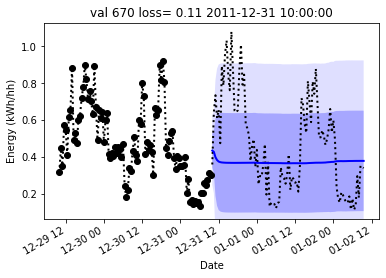

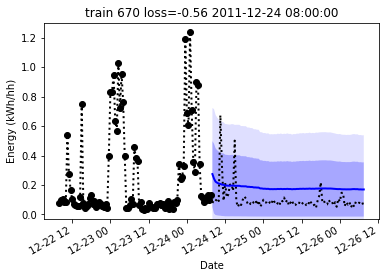

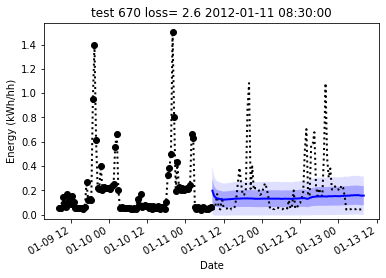

INFO:predict_heading2:step 0, {'agg_test_loss': 2.559562921524048, 'log': {'agg_test_loss': 2.5598039627075195, 'agg_test_loss_p': 2.559562921524048, 'agg_test_loss_kl': 0.00024106727505568415, 'agg_test_loss_mse': 0.05162228271365166, 'agg_test_loss_p_weighted': 0.454759806394577, 'agg_test_score': 2.559562921524048}}
----------------------------------------------------------------------------------------------------
TEST RESULTS
{}
----------------------------------------------------------------------------------------------------



anp-rnn_c_mean  anp-rnn_mean  anp-rnn_d_mean  \
agg_test_loss               3.264200e-01      0.908300        1.405925   
agg_test_loss_p             3.264199e-01      0.899200        1.398106   
agg_test_loss_kl            1.415805e-07      0.009100        0.007818   
agg_test_loss_mse           5.554044e-02      0.052031        0.050875   
agg_test_loss_p_weighted    6.167767e-02      0.172292        0.257106   
agg_test_score              3.264199e-01      0.899200        1.398106   
n                           1.000000e+00      1.000000        1.000000   

                          anp-rnn_extras_mean  anp-rnn_pt_mean  
agg_test_loss                        2.559804         2.821728  
agg_test_loss_p                      2.559563         2.806924  
agg_test_loss_kl                     0.000241         0.014804  
agg_test_loss_mse                    0.051622         0.049933  
agg_test_loss_p_weighted             0.454760         0.539386  
agg_test_score                       2.559563         2.806924  
n                                    1.000000         1.000000

0 {'name': 'anp-rnn_extras_no_det', 'params': {'det_enc_cross_attn_type': 'ptmultihead', 'det_enc_self_attn_type': 'ptmultihead', 'latent_enc_self_attn_type': 'ptmultihead', 'use_deterministic_path': False, 'batchnorm': True, 'attention_dropout': 0.4, 'dropout': 0.2, 'use_lvar': True}, 'PL_MODEL_CLS': <class 'neural_processes.models.neural_process.lightning.PL_ANPRNN'>}
INFO:predict_heading2:now run `tensorboard --logdir lightning_logs`
INFO:root:GPU available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:predict_heading2:trial number=-1000 name=anp-rnn_extras_no_det, trial=<optuna.trial.FixedTrial object at 0x7f8d6cf94e10> params={'learning_rate': 0.003, 'num_heads_power': 2, 'hidden_dim_power': 6, 'latent_dim_power': 5, 'n_latent_encoder_layers': 3, 'n_det_encoder_layers': 3, 'n_decoder_layers': 4, 'dropout': 0.2, 'attention_dropout': 0.4, 'batchnorm': True, 'use_deterministic_path': False} attrs={'batch_size': 24, 'grad_clip': 40, 'max_nb_epochs': 20, 'num_workers': 3, 'num_conte

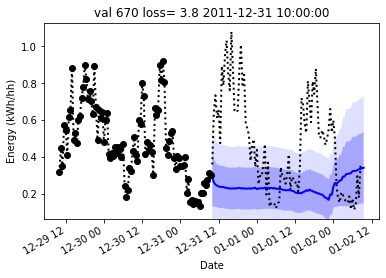

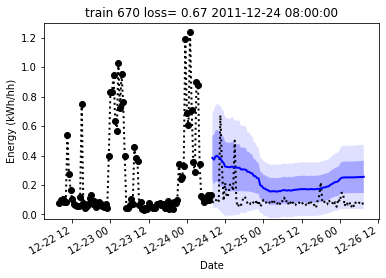

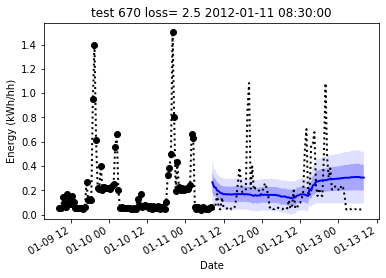

INFO:predict_heading2:step 0, {'agg_test_loss': 2.4935595989227295, 'log': {'agg_test_loss': 2.6074419021606445, 'agg_test_loss_p': 2.4935595989227295, 'agg_test_loss_kl': 0.11388201266527176, 'agg_test_loss_mse': 0.05809636786580086, 'agg_test_loss_p_weighted': 0.4679461121559143, 'agg_test_score': 2.4935595989227295}}
----------------------------------------------------------------------------------------------------
TEST RESULTS
{}
----------------------------------------------------------------------------------------------------



anp-rnn_c_mean  anp-rnn_mean  anp-rnn_d_mean  \
agg_test_loss               3.264200e-01      0.908300        1.405925   
agg_test_loss_p             3.264199e-01      0.899200        1.398106   
agg_test_loss_kl            1.415805e-07      0.009100        0.007818   
agg_test_loss_mse           5.554044e-02      0.052031        0.050875   
agg_test_loss_p_weighted    6.167767e-02      0.172292        0.257106   
agg_test_score              3.264199e-01      0.899200        1.398106   
n                           1.000000e+00      1.000000        1.000000   

                          anp-rnn_extras_no_det_mean  anp-rnn_extras_mean  \
agg_test_loss                               2.607442             2.559804   
agg_test_loss_p                             2.493560             2.559563   
agg_test_loss_kl                            0.113882             0.000241   
agg_test_loss_mse                           0.058096             0.051622   
agg_test_loss_p_weighted                    0.467946             0.454760   
agg_test_score                              2.493560             2.559563   
n                                           1.000000             1.000000   

                          anp-rnn_pt_mean  
agg_test_loss                    2.821728  
agg_test_loss_p                  2.806924  
agg_test_loss_kl                 0.014804  
agg_test_loss_mse                0.049933  
agg_test_loss_p_weighted         0.539386  
agg_test_score                   2.806924  
n                                1.000000

0 {'name': 'anp-rnn_no_det', 'params': {'use_deterministic_path': False}, 'PL_MODEL_CLS': <class 'neural_processes.models.neural_process.lightning.PL_ANPRNN'>}
INFO:predict_heading2:now run `tensorboard --logdir lightning_logs`
INFO:root:GPU available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:predict_heading2:trial number=-1000 name=anp-rnn_no_det, trial=<optuna.trial.FixedTrial object at 0x7f8d71352cc0> params={'learning_rate': 0.003, 'num_heads_power': 2, 'hidden_dim_power': 6, 'latent_dim_power': 5, 'n_latent_encoder_layers': 3, 'n_det_encoder_layers': 3, 'n_decoder_layers': 4, 'dropout': 0.1, 'attention_dropout': 0.5, 'batchnorm': False, 'use_deterministic_path': False} attrs={'batch_size': 24, 'grad_clip': 40, 'max_nb_epochs': 20, 'num_workers': 3, 'num_context': 336, 'vis_i': '670', 'num_extra_target': 96, 'x_dim': 17, 'context_in_target': False, 'y_dim': 1, 'patience': 2, 'min_std': 0.005, 'max_epoch_steps': 19200}
INFO:predict_heading2:Loading checkpoint lightning_logs/a

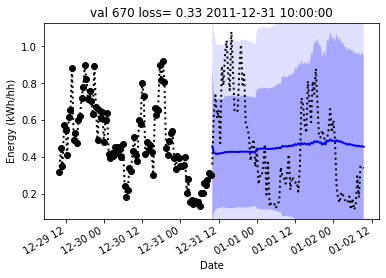

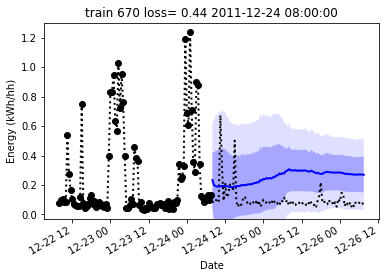

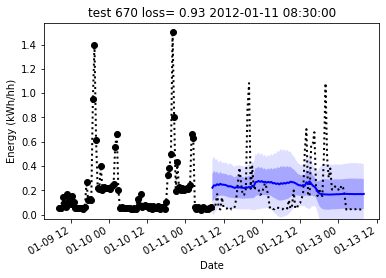

INFO:predict_heading2:step 0, {'agg_test_loss': 0.5305460691452026, 'log': {'agg_test_loss': 0.583978533744812, 'agg_test_loss_p': 0.5305460691452026, 'agg_test_loss_kl': 0.05343237519264221, 'agg_test_loss_mse': 0.05066785216331482, 'agg_test_loss_p_weighted': 0.09943656623363495, 'agg_test_score': 0.5305460691452026}}
----------------------------------------------------------------------------------------------------
TEST RESULTS
{}
----------------------------------------------------------------------------------------------------



anp-rnn_c_mean  anp-rnn_no_det_mean  anp-rnn_mean  \
agg_test_loss               3.264200e-01             0.583979      0.908300   
agg_test_loss_p             3.264199e-01             0.530546      0.899200   
agg_test_loss_kl            1.415805e-07             0.053432      0.009100   
agg_test_loss_mse           5.554044e-02             0.050668      0.052031   
agg_test_loss_p_weighted    6.167767e-02             0.099437      0.172292   
agg_test_score              3.264199e-01             0.530546      0.899200   
n                           1.000000e+00             1.000000      1.000000   

                          anp-rnn_d_mean  anp-rnn_extras_no_det_mean  \
agg_test_loss                   1.405925                    2.607442   
agg_test_loss_p                 1.398106                    2.493560   
agg_test_loss_kl                0.007818                    0.113882   
agg_test_loss_mse               0.050875                    0.058096   
agg_test_loss_p_weighted        0.257106                    0.467946   
agg_test_score                  1.398106                    2.493560   
n                               1.000000                    1.000000   

                          anp-rnn_extras_mean  anp-rnn_pt_mean  
agg_test_loss                        2.559804         2.821728  
agg_test_loss_p                      2.559563         2.806924  
agg_test_loss_kl                     0.000241         0.014804  
agg_test_loss_mse                    0.051622         0.049933  
agg_test_loss_p_weighted             0.454760         0.539386  
agg_test_score                       2.559563         2.806924  
n                                    1.000000         1.000000

0 {'name': 'TransformerSeq2Seq_PL_lstm', 'params': {'use_lstm': True}, 'PL_MODEL_CLS': <class 'neural_processes.models.transformer_seq2seq.TransformerSeq2Seq_PL'>}
INFO:predict_heading2:now run `tensorboard --logdir lightning_logs`
INFO:root:GPU available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:predict_heading2:trial number=-1000 name=TransformerSeq2Seq_PL_lstm, trial=<optuna.trial.FixedTrial object at 0x7f8d6d01f550> params={'learning_rate': 0.002, 'attention_dropout': 0.2, 'hidden_size_power': 5, 'hidden_out_size_power': 4, 'nhead_power': 3, 'nlayers': 2, 'use_lstm': True, 'agg': 'max'} attrs={'batch_size': 24, 'grad_clip': 40, 'max_nb_epochs': 20, 'num_workers': 3, 'num_extra_target': 96, 'vis_i': '670', 'num_context': 336, 'input_size': 18, 'input_size_decoder': 17, 'context_in_target': False, 'output_size': 1, 'patience': 2, 'min_std': 0.005, 'x_dim': 17, 'y_dim': 1, 'max_epoch_steps': 19200}
INFO:predict_heading2:Loading checkpoint lightning_logs/TransformerSeq2Seq_PL_ls

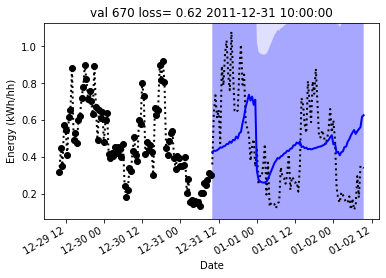

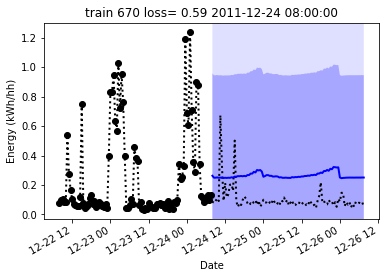

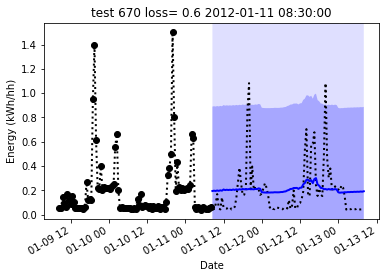

INFO:predict_heading2:step 0, {'agg_test_loss': 0.6033954620361328, 'log': {'agg_test_loss': 0.6033954620361328, 'agg_test_loss_p': 0.6033954620361328, 'agg_test_loss_mse': 0.04706025496125221, 'agg_test_loss_p_weighted': 0.11429975181818008, 'agg_test_score': 0.6033954620361328}}
----------------------------------------------------------------------------------------------------
TEST RESULTS
{}
----------------------------------------------------------------------------------------------------



anp-rnn_c_mean  anp-rnn_no_det_mean  \
agg_test_loss               3.264200e-01             0.583979   
agg_test_loss_p             3.264199e-01             0.530546   
agg_test_loss_kl            1.415805e-07             0.053432   
agg_test_loss_mse           5.554044e-02             0.050668   
agg_test_loss_p_weighted    6.167767e-02             0.099437   
agg_test_score              3.264199e-01             0.530546   
n                           1.000000e+00             1.000000   

                          TransformerSeq2Seq_PL_lstm_mean  anp-rnn_mean  \
agg_test_loss                                    0.603395      0.908300   
agg_test_loss_p                                  0.603395      0.899200   
agg_test_loss_kl                                      NaN      0.009100   
agg_test_loss_mse                                0.047060      0.052031   
agg_test_loss_p_weighted                         0.114300      0.172292   
agg_test_score                                   0.603395      0.899200   
n                                                1.000000      1.000000   

                          anp-rnn_d_mean  anp-rnn_extras_no_det_mean  \
agg_test_loss                   1.405925                    2.607442   
agg_test_loss_p                 1.398106                    2.493560   
agg_test_loss_kl                0.007818                    0.113882   
agg_test_loss_mse               0.050875                    0.058096   
agg_test_loss_p_weighted        0.257106                    0.467946   
agg_test_score                  1.398106                    2.493560   
n                               1.000000                    1.000000   

                          anp-rnn_extras_mean  anp-rnn_pt_mean  
agg_test_loss                        2.559804         2.821728  
agg_test_loss_p                      2.559563         2.806924  
agg_test_loss_kl                     0.000241         0.014804  
agg_test_loss_mse                    0.051622         0.049933  
agg_test_loss_p_weighted             0.454760         0.539386  
agg_test_score                       2.559563         2.806924  
n                                    1.000000         1.000000

0 {'name': 'TransformerSeq2Seq_PL', 'PL_MODEL_CLS': <class 'neural_processes.models.transformer_seq2seq.TransformerSeq2Seq_PL'>}
INFO:predict_heading2:now run `tensorboard --logdir lightning_logs`
INFO:root:GPU available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:predict_heading2:trial number=-1000 name=TransformerSeq2Seq_PL, trial=<optuna.trial.FixedTrial object at 0x7f8d6eba9d30> params={'learning_rate': 0.002, 'attention_dropout': 0.2, 'hidden_size_power': 5, 'hidden_out_size_power': 4, 'nhead_power': 3, 'nlayers': 2, 'use_lstm': False, 'agg': 'max'} attrs={'batch_size': 24, 'grad_clip': 40, 'max_nb_epochs': 20, 'num_workers': 3, 'num_extra_target': 96, 'vis_i': '670', 'num_context': 336, 'input_size': 18, 'input_size_decoder': 17, 'context_in_target': False, 'output_size': 1, 'patience': 2, 'min_std': 0.005, 'x_dim': 17, 'y_dim': 1, 'max_epoch_steps': 19200}
INFO:predict_heading2:Loading checkpoint lightning_logs/TransformerSeq2Seq_PL/version_-1000/_ckpt_epoch_11.ckpt


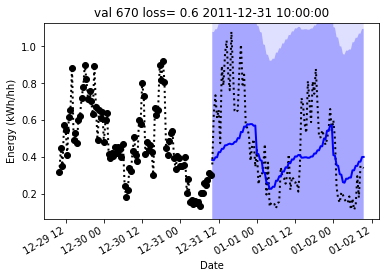

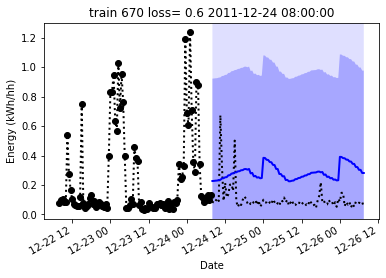

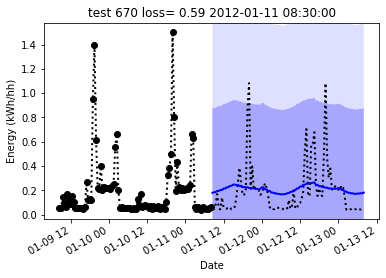

INFO:predict_heading2:step 0, {'agg_test_loss': 0.6008006930351257, 'log': {'agg_test_loss': 0.6008006930351257, 'agg_test_loss_p': 0.6008006930351257, 'agg_test_loss_mse': 0.0445558987557888, 'agg_test_loss_p_weighted': 0.11382939666509628, 'agg_test_score': 0.6008006930351257}}
----------------------------------------------------------------------------------------------------
TEST RESULTS
{}
----------------------------------------------------------------------------------------------------



anp-rnn_c_mean  anp-rnn_no_det_mean  \
agg_test_loss               3.264200e-01             0.583979   
agg_test_loss_p             3.264199e-01             0.530546   
agg_test_loss_kl            1.415805e-07             0.053432   
agg_test_loss_mse           5.554044e-02             0.050668   
agg_test_loss_p_weighted    6.167767e-02             0.099437   
agg_test_score              3.264199e-01             0.530546   
n                           1.000000e+00             1.000000   

                          TransformerSeq2Seq_PL_mean  \
agg_test_loss                               0.600801   
agg_test_loss_p                             0.600801   
agg_test_loss_kl                                 NaN   
agg_test_loss_mse                           0.044556   
agg_test_loss_p_weighted                    0.113829   
agg_test_score                              0.600801   
n                                           1.000000   

                          TransformerSeq2Seq_PL_lstm_mean  anp-rnn_mean  \
agg_test_loss                                    0.603395      0.908300   
agg_test_loss_p                                  0.603395      0.899200   
agg_test_loss_kl                                      NaN      0.009100   
agg_test_loss_mse                                0.047060      0.052031   
agg_test_loss_p_weighted                         0.114300      0.172292   
agg_test_score                                   0.603395      0.899200   
n                                                1.000000      1.000000   

                          anp-rnn_d_mean  anp-rnn_extras_no_det_mean  \
agg_test_loss                   1.405925                    2.607442   
agg_test_loss_p                 1.398106                    2.493560   
agg_test_loss_kl                0.007818                    0.113882   
agg_test_loss_mse               0.050875                    0.058096   
agg_test_loss_p_weighted        0.257106                    0.467946   
agg_test_score                  1.398106                    2.493560   
n                               1.000000                    1.000000   

                          anp-rnn_extras_mean  anp-rnn_pt_mean  
agg_test_loss                        2.559804         2.821728  
agg_test_loss_p                      2.559563         2.806924  
agg_test_loss_kl                     0.000241         0.014804  
agg_test_loss_mse                    0.051622         0.049933  
agg_test_loss_p_weighted             0.454760         0.539386  
agg_test_score                       2.559563         2.806924  
n                                    1.000000         1.000000

0 {'name': 'LSTMSeq2Seq_PL_attn', 'PL_MODEL_CLS': <class 'neural_processes.models.lstm_seqseq.LSTMSeq2Seq_PL'>, 'params': {'use_self_attn': True, 'use_cross_attn': True}}
INFO:predict_heading2:now run `tensorboard --logdir lightning_logs`
INFO:root:GPU available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:predict_heading2:trial number=-1000 name=LSTMSeq2Seq_PL_attn, trial=<optuna.trial.FixedTrial object at 0x7f8dec3eb518> params={'learning_rate': 0.001, 'lstm_dropout': 0.22, 'hidden_size_power': 6.0, 'lstm_layers': 3, 'bidirectional': False} attrs={'batch_size': 24, 'grad_clip': 40, 'max_nb_epochs': 20, 'num_workers': 3, 'num_extra_target': 96, 'vis_i': '670', 'num_context': 336, 'input_size': 18, 'input_size_decoder': 17, 'context_in_target': False, 'output_size': 1, 'min_std': 0.005, 'x_dim': 17, 'y_dim': 1, 'patience': 2, 'max_epoch_steps': 19200}
INFO:predict_heading2:Loading checkpoint lightning_logs/LSTMSeq2Seq_PL_attn/version_-1000/_ckpt_epoch_3.ckpt


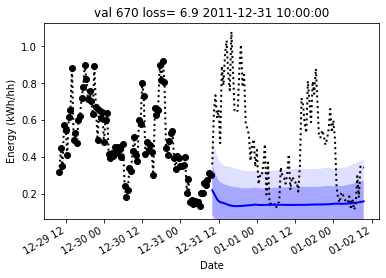

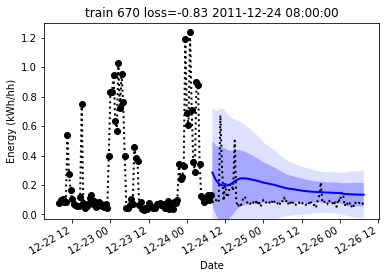

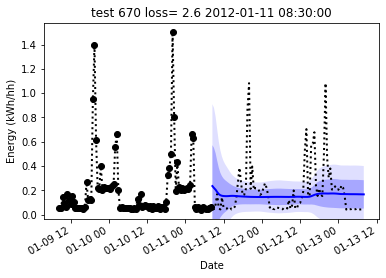

INFO:predict_heading2:step 0, {'agg_test_loss': 1.6291112899780273, 'log': {'agg_test_loss': 1.6291112899780273, 'agg_test_loss_p': 1.6291112899780273, 'agg_test_loss_mse': 0.05164827033877373, 'agg_test_loss_p_weighted': 0.27507510781288147, 'agg_test_score': 1.6291112899780273}}
----------------------------------------------------------------------------------------------------
TEST RESULTS
{}
----------------------------------------------------------------------------------------------------



anp-rnn_c_mean  anp-rnn_no_det_mean  \
agg_test_loss               3.264200e-01             0.583979   
agg_test_loss_p             3.264199e-01             0.530546   
agg_test_loss_kl            1.415805e-07             0.053432   
agg_test_loss_mse           5.554044e-02             0.050668   
agg_test_loss_p_weighted    6.167767e-02             0.099437   
agg_test_score              3.264199e-01             0.530546   
n                           1.000000e+00             1.000000   

                          TransformerSeq2Seq_PL_mean  \
agg_test_loss                               0.600801   
agg_test_loss_p                             0.600801   
agg_test_loss_kl                                 NaN   
agg_test_loss_mse                           0.044556   
agg_test_loss_p_weighted                    0.113829   
agg_test_score                              0.600801   
n                                           1.000000   

                          TransformerSeq2Seq_PL_lstm_mean  anp-rnn_mean  \
agg_test_loss                                    0.603395      0.908300   
agg_test_loss_p                                  0.603395      0.899200   
agg_test_loss_kl                                      NaN      0.009100   
agg_test_loss_mse                                0.047060      0.052031   
agg_test_loss_p_weighted                         0.114300      0.172292   
agg_test_score                                   0.603395      0.899200   
n                                                1.000000      1.000000   

                          anp-rnn_d_mean  LSTMSeq2Seq_PL_attn_mean  \
agg_test_loss                   1.405925                  1.629111   
agg_test_loss_p                 1.398106                  1.629111   
agg_test_loss_kl                0.007818                       NaN   
agg_test_loss_mse               0.050875                  0.051648   
agg_test_loss_p_weighted        0.257106                  0.275075   
agg_test_score                  1.398106                  1.629111   
n                               1.000000                  1.000000   

                          anp-rnn_extras_no_det_mean  anp-rnn_extras_mean  \
agg_test_loss                               2.607442             2.559804   
agg_test_loss_p                             2.493560             2.559563   
agg_test_loss_kl                            0.113882             0.000241   
agg_test_loss_mse                           0.058096             0.051622   
agg_test_loss_p_weighted                    0.467946             0.454760   
agg_test_score                              2.493560             2.559563   
n                                           1.000000             1.000000   

                          anp-rnn_pt_mean  
agg_test_loss                    2.821728  
agg_test_loss_p                  2.806924  
agg_test_loss_kl                 0.014804  
agg_test_loss_mse                0.049933  
agg_test_loss_p_weighted         0.539386  
agg_test_score                   2.806924  
n                                1.000000

0 {'name': 'LSTMSeq2Seq_PL', 'PL_MODEL_CLS': <class 'neural_processes.models.lstm_seqseq.LSTMSeq2Seq_PL'>, 'params': {'use_self_attn': False, 'use_cross_attn': False}}
INFO:predict_heading2:now run `tensorboard --logdir lightning_logs`
INFO:root:GPU available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:predict_heading2:trial number=-1000 name=LSTMSeq2Seq_PL, trial=<optuna.trial.FixedTrial object at 0x7f8dec3fd048> params={'learning_rate': 0.001, 'lstm_dropout': 0.22, 'hidden_size_power': 6.0, 'lstm_layers': 3, 'bidirectional': False} attrs={'batch_size': 24, 'grad_clip': 40, 'max_nb_epochs': 20, 'num_workers': 3, 'num_extra_target': 96, 'vis_i': '670', 'num_context': 336, 'input_size': 18, 'input_size_decoder': 17, 'context_in_target': False, 'output_size': 1, 'min_std': 0.005, 'x_dim': 17, 'y_dim': 1, 'patience': 2, 'max_epoch_steps': 19200}
INFO:predict_heading2:Loading checkpoint lightning_logs/LSTMSeq2Seq_PL/version_-1000/_ckpt_epoch_0.ckpt


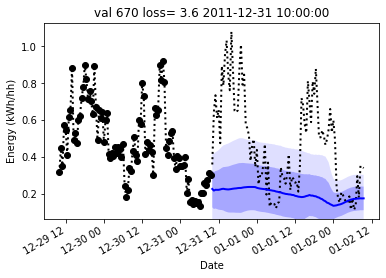

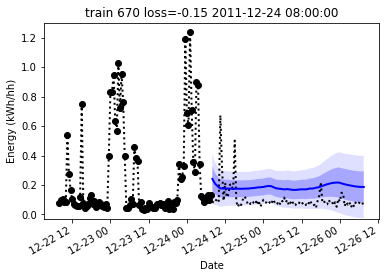

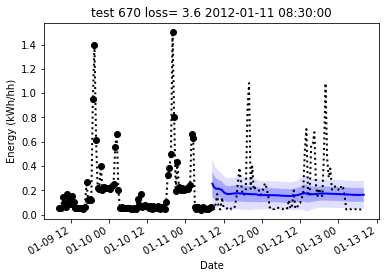

INFO:predict_heading2:step 0, {'agg_test_loss': 4.716095447540283, 'log': {'agg_test_loss': 4.716095447540283, 'agg_test_loss_p': 4.716095447540283, 'agg_test_loss_mse': 0.05077759549021721, 'agg_test_loss_p_weighted': 0.8114907741546631, 'agg_test_score': 4.716095447540283}}
----------------------------------------------------------------------------------------------------
TEST RESULTS
{}
----------------------------------------------------------------------------------------------------



anp-rnn_c_mean  anp-rnn_no_det_mean  \
agg_test_loss               3.264200e-01             0.583979   
agg_test_loss_p             3.264199e-01             0.530546   
agg_test_loss_kl            1.415805e-07             0.053432   
agg_test_loss_mse           5.554044e-02             0.050668   
agg_test_loss_p_weighted    6.167767e-02             0.099437   
agg_test_score              3.264199e-01             0.530546   
n                           1.000000e+00             1.000000   

                          TransformerSeq2Seq_PL_mean  \
agg_test_loss                               0.600801   
agg_test_loss_p                             0.600801   
agg_test_loss_kl                                 NaN   
agg_test_loss_mse                           0.044556   
agg_test_loss_p_weighted                    0.113829   
agg_test_score                              0.600801   
n                                           1.000000   

                          TransformerSeq2Seq_PL_lstm_mean  anp-rnn_mean  \
agg_test_loss                                    0.603395      0.908300   
agg_test_loss_p                                  0.603395      0.899200   
agg_test_loss_kl                                      NaN      0.009100   
agg_test_loss_mse                                0.047060      0.052031   
agg_test_loss_p_weighted                         0.114300      0.172292   
agg_test_score                                   0.603395      0.899200   
n                                                1.000000      1.000000   

                          anp-rnn_d_mean  LSTMSeq2Seq_PL_attn_mean  \
agg_test_loss                   1.405925                  1.629111   
agg_test_loss_p                 1.398106                  1.629111   
agg_test_loss_kl                0.007818                       NaN   
agg_test_loss_mse               0.050875                  0.051648   
agg_test_loss_p_weighted        0.257106                  0.275075   
agg_test_score                  1.398106                  1.629111   
n                               1.000000                  1.000000   

                          anp-rnn_extras_no_det_mean  anp-rnn_extras_mean  \
agg_test_loss                               2.607442             2.559804   
agg_test_loss_p                             2.493560             2.559563   
agg_test_loss_kl                            0.113882             0.000241   
agg_test_loss_mse                           0.058096             0.051622   
agg_test_loss_p_weighted                    0.467946             0.454760   
agg_test_score                              2.493560             2.559563   
n                                           1.000000             1.000000   

                          anp-rnn_pt_mean  LSTMSeq2Seq_PL_mean  
agg_test_loss                    2.821728             4.716095  
agg_test_loss_p                  2.806924             4.716095  
agg_test_loss_kl                 0.014804                  NaN  
agg_test_loss_mse                0.049933             0.050778  
agg_test_loss_p_weighted         0.539386             0.811491  
agg_test_score                   2.806924             4.716095  
n                                1.000000             1.000000

0 {'name': 'anp_c', 'PL_MODEL_CLS': <class 'neural_processes.models.neural_process.lightning.PL_ANP'>}
INFO:predict_heading2:now run `tensorboard --logdir lightning_logs`
INFO:root:GPU available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:predict_heading2:trial number=-1000 name=anp_c, trial=<optuna.trial.FixedTrial object at 0x7f8d6d000cf8> params={'learning_rate': 0.003, 'num_heads_power': 2, 'hidden_dim_power': 6, 'latent_dim_power': 5, 'n_latent_encoder_layers': 3, 'n_det_encoder_layers': 3, 'n_decoder_layers': 4, 'dropout': 0.1, 'attention_dropout': 0.5, 'batchnorm': False, 'use_deterministic_path': True} attrs={'batch_size': 24, 'grad_clip': 40, 'max_nb_epochs': 20, 'num_workers': 3, 'num_context': 336, 'vis_i': '670', 'num_extra_target': 96, 'x_dim': 17, 'context_in_target': False, 'y_dim': 1, 'patience': 2, 'min_std': 0.005, 'max_epoch_steps': 19200}
INFO:predict_heading2:Loading checkpoint lightning_logs/anp_c/version_-1000/_ckpt_epoch_5.ckpt


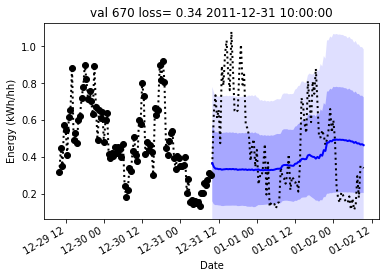

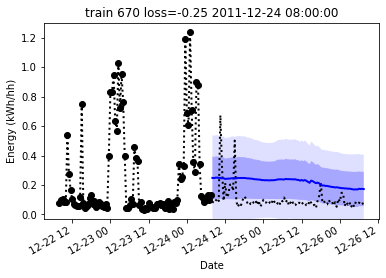

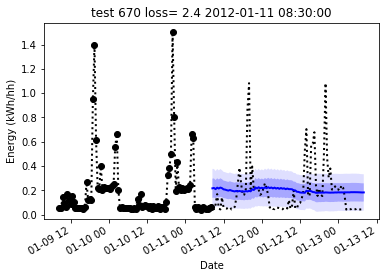

INFO:predict_heading2:step 0, {'agg_test_loss': 1.4489327669143677, 'log': {'agg_test_loss': 1.4562760591506958, 'agg_test_loss_p': 1.4489327669143677, 'agg_test_loss_kl': 0.007343324366956949, 'agg_test_loss_mse': 0.05047369375824928, 'agg_test_loss_p_weighted': 0.2776172161102295, 'agg_test_score': 1.4489327669143677}}
----------------------------------------------------------------------------------------------------
TEST RESULTS
{}
----------------------------------------------------------------------------------------------------



anp-rnn_c_mean  anp-rnn_no_det_mean  \
agg_test_loss               3.264200e-01             0.583979   
agg_test_loss_p             3.264199e-01             0.530546   
agg_test_loss_kl            1.415805e-07             0.053432   
agg_test_loss_mse           5.554044e-02             0.050668   
agg_test_loss_p_weighted    6.167767e-02             0.099437   
agg_test_score              3.264199e-01             0.530546   
n                           1.000000e+00             1.000000   

                          TransformerSeq2Seq_PL_mean  \
agg_test_loss                               0.600801   
agg_test_loss_p                             0.600801   
agg_test_loss_kl                                 NaN   
agg_test_loss_mse                           0.044556   
agg_test_loss_p_weighted                    0.113829   
agg_test_score                              0.600801   
n                                           1.000000   

                          TransformerSeq2Seq_PL_lstm_mean  anp-rnn_mean  \
agg_test_loss                                    0.603395      0.908300   
agg_test_loss_p                                  0.603395      0.899200   
agg_test_loss_kl                                      NaN      0.009100   
agg_test_loss_mse                                0.047060      0.052031   
agg_test_loss_p_weighted                         0.114300      0.172292   
agg_test_score                                   0.603395      0.899200   
n                                                1.000000      1.000000   

                          anp-rnn_d_mean  anp_c_mean  \
agg_test_loss                   1.405925    1.456276   
agg_test_loss_p                 1.398106    1.448933   
agg_test_loss_kl                0.007818    0.007343   
agg_test_loss_mse               0.050875    0.050474   
agg_test_loss_p_weighted        0.257106    0.277617   
agg_test_score                  1.398106    1.448933   
n                               1.000000    1.000000   

                          LSTMSeq2Seq_PL_attn_mean  \
agg_test_loss                             1.629111   
agg_test_loss_p                           1.629111   
agg_test_loss_kl                               NaN   
agg_test_loss_mse                         0.051648   
agg_test_loss_p_weighted                  0.275075   
agg_test_score                            1.629111   
n                                         1.000000   

                          anp-rnn_extras_no_det_mean  anp-rnn_extras_mean  \
agg_test_loss                               2.607442             2.559804   
agg_test_loss_p                             2.493560             2.559563   
agg_test_loss_kl                            0.113882             0.000241   
agg_test_loss_mse                           0.058096             0.051622   
agg_test_loss_p_weighted                    0.467946             0.454760   
agg_test_score                              2.493560             2.559563   
n                                           1.000000             1.000000   

                          anp-rnn_pt_mean  LSTMSeq2Seq_PL_mean  
agg_test_loss                    2.821728             4.716095  
agg_test_loss_p                  2.806924             4.716095  
agg_test_loss_kl                 0.014804                  NaN  
agg_test_loss_mse                0.049933             0.050778  
agg_test_loss_p_weighted         0.539386             0.811491  
agg_test_score                   2.806924             4.716095  
n                                1.000000             1.000000

0 {'name': 'np', 'PL_MODEL_CLS': <class 'neural_processes.models.neural_process.lightning.PL_NP'>}
INFO:predict_heading2:now run `tensorboard --logdir lightning_logs`
INFO:root:GPU available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:predict_heading2:trial number=-1000 name=np, trial=<optuna.trial.FixedTrial object at 0x7f8d6e356a58> params={'learning_rate': 0.003, 'hidden_dim_power': 6, 'latent_dim_power': 5, 'n_latent_encoder_layers': 3, 'n_decoder_layers': 4, 'dropout': 0.1, 'batchnorm': False} attrs={'batch_size': 24, 'grad_clip': 40, 'max_nb_epochs': 20, 'num_workers': 3, 'num_context': 336, 'vis_i': '670', 'num_extra_target': 96, 'x_dim': 17, 'context_in_target': False, 'y_dim': 1, 'patience': 2, 'min_std': 0.005, 'max_epoch_steps': 19200}
INFO:predict_heading2:Loading checkpoint lightning_logs/np/version_-1000/_ckpt_epoch_0.ckpt


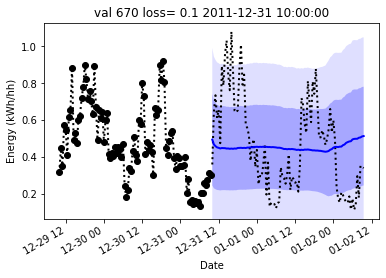

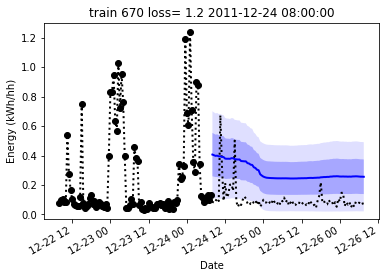

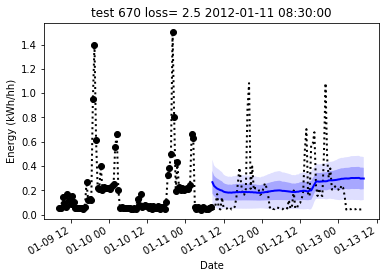

INFO:predict_heading2:step 0, {'agg_test_loss': 2.6971635818481445, 'log': {'agg_test_loss': 2.718724012374878, 'agg_test_loss_p': 2.6971635818481445, 'agg_test_loss_kl': 0.02156059257686138, 'agg_test_loss_mse': 0.056557975709438324, 'agg_test_loss_p_weighted': 0.48895958065986633, 'agg_test_score': 2.6971635818481445}}
----------------------------------------------------------------------------------------------------
TEST RESULTS
{}
----------------------------------------------------------------------------------------------------



anp-rnn_c_mean  anp-rnn_no_det_mean  \
agg_test_loss               3.264200e-01             0.583979   
agg_test_loss_p             3.264199e-01             0.530546   
agg_test_loss_kl            1.415805e-07             0.053432   
agg_test_loss_mse           5.554044e-02             0.050668   
agg_test_loss_p_weighted    6.167767e-02             0.099437   
agg_test_score              3.264199e-01             0.530546   
n                           1.000000e+00             1.000000   

                          TransformerSeq2Seq_PL_mean  \
agg_test_loss                               0.600801   
agg_test_loss_p                             0.600801   
agg_test_loss_kl                                 NaN   
agg_test_loss_mse                           0.044556   
agg_test_loss_p_weighted                    0.113829   
agg_test_score                              0.600801   
n                                           1.000000   

                          TransformerSeq2Seq_PL_lstm_mean  anp-rnn_mean  \
agg_test_loss                                    0.603395      0.908300   
agg_test_loss_p                                  0.603395      0.899200   
agg_test_loss_kl                                      NaN      0.009100   
agg_test_loss_mse                                0.047060      0.052031   
agg_test_loss_p_weighted                         0.114300      0.172292   
agg_test_score                                   0.603395      0.899200   
n                                                1.000000      1.000000   

                          anp-rnn_d_mean  anp_c_mean  \
agg_test_loss                   1.405925    1.456276   
agg_test_loss_p                 1.398106    1.448933   
agg_test_loss_kl                0.007818    0.007343   
agg_test_loss_mse               0.050875    0.050474   
agg_test_loss_p_weighted        0.257106    0.277617   
agg_test_score                  1.398106    1.448933   
n                               1.000000    1.000000   

                          LSTMSeq2Seq_PL_attn_mean  \
agg_test_loss                             1.629111   
agg_test_loss_p                           1.629111   
agg_test_loss_kl                               NaN   
agg_test_loss_mse                         0.051648   
agg_test_loss_p_weighted                  0.275075   
agg_test_score                            1.629111   
n                                         1.000000   

                          anp-rnn_extras_no_det_mean  anp-rnn_extras_mean  \
agg_test_loss                               2.607442             2.559804   
agg_test_loss_p                             2.493560             2.559563   
agg_test_loss_kl                            0.113882             0.000241   
agg_test_loss_mse                           0.058096             0.051622   
agg_test_loss_p_weighted                    0.467946             0.454760   
agg_test_score                              2.493560             2.559563   
n                                           1.000000             1.000000   

                           np_mean  anp-rnn_pt_mean  LSTMSeq2Seq_PL_mean  
agg_test_loss             2.718724         2.821728             4.716095  
agg_test_loss_p           2.697164         2.806924             4.716095  
agg_test_loss_kl          0.021561         0.014804                  NaN  
agg_test_loss_mse         0.056558         0.049933             0.050778  
agg_test_loss_p_weighted  0.488960         0.539386             0.811491  
agg_test_score            2.697164         2.806924             4.716095  
n                         1.000000         1.000000             1.000000

0 {'name': 'PL_Transformer', 'PL_MODEL_CLS': <class 'neural_processes.models.transformer.PL_Transformer'>}
INFO:predict_heading2:now run `tensorboard --logdir lightning_logs`
INFO:root:GPU available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:predict_heading2:trial number=-1000 name=PL_Transformer, trial=<optuna.trial.FixedTrial object at 0x7f8d712a27f0> params={'learning_rate': 0.003, 'attention_dropout': 0.4, 'hidden_size_power': 7.0, 'hidden_out_size_power': 7.0, 'nhead_power': 1.0, 'nlayers': 2} attrs={'batch_size': 24, 'grad_clip': 40, 'max_nb_epochs': 20, 'num_workers': 3, 'vis_i': '670', 'x_dim': 17, 'y_dim': 1, 'context_in_target': False, 'patience': 2, 'min_std': 0.005, 'nan_value': -99.9, 'num_context': 336, 'num_extra_target': 96, 'max_epoch_steps': 19200}
INFO:predict_heading2:Loading checkpoint lightning_logs/PL_Transformer/version_-1000/_ckpt_epoch_1.ckpt


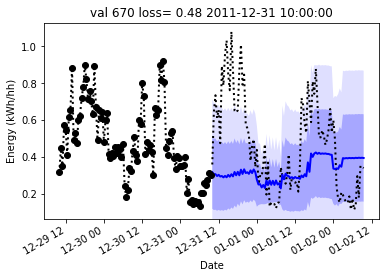

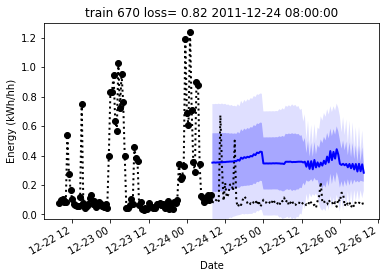

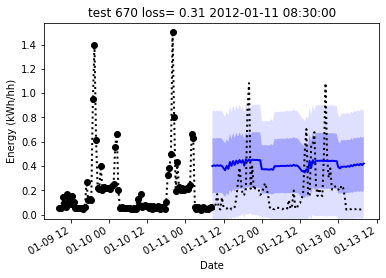

INFO:predict_heading2:step 0, {'agg_test_loss': 0.5545756816864014, 'log': {'agg_test_loss': 0.5545756816864014, 'agg_test_loss_p': 0.5545756816864014, 'agg_test_loss_mse': 0.07866694778203964, 'agg_test_loss_p_weighted': 0.10357975214719772, 'agg_test_score': 0.5545756816864014}}
----------------------------------------------------------------------------------------------------
TEST RESULTS
{}
----------------------------------------------------------------------------------------------------



anp-rnn_c_mean  anp-rnn_no_det_mean  \
agg_test_loss               3.264200e-01             0.583979   
agg_test_loss_p             3.264199e-01             0.530546   
agg_test_loss_kl            1.415805e-07             0.053432   
agg_test_loss_mse           5.554044e-02             0.050668   
agg_test_loss_p_weighted    6.167767e-02             0.099437   
agg_test_score              3.264199e-01             0.530546   
n                           1.000000e+00             1.000000   

                          PL_Transformer_mean  TransformerSeq2Seq_PL_mean  \
agg_test_loss                        0.554576                    0.600801   
agg_test_loss_p                      0.554576                    0.600801   
agg_test_loss_kl                          NaN                         NaN   
agg_test_loss_mse                    0.078667                    0.044556   
agg_test_loss_p_weighted             0.103580                    0.113829   
agg_test_score                       0.554576                    0.600801   
n                                    1.000000                    1.000000   

                          TransformerSeq2Seq_PL_lstm_mean  anp-rnn_mean  \
agg_test_loss                                    0.603395      0.908300   
agg_test_loss_p                                  0.603395      0.899200   
agg_test_loss_kl                                      NaN      0.009100   
agg_test_loss_mse                                0.047060      0.052031   
agg_test_loss_p_weighted                         0.114300      0.172292   
agg_test_score                                   0.603395      0.899200   
n                                                1.000000      1.000000   

                          anp-rnn_d_mean  anp_c_mean  \
agg_test_loss                   1.405925    1.456276   
agg_test_loss_p                 1.398106    1.448933   
agg_test_loss_kl                0.007818    0.007343   
agg_test_loss_mse               0.050875    0.050474   
agg_test_loss_p_weighted        0.257106    0.277617   
agg_test_score                  1.398106    1.448933   
n                               1.000000    1.000000   

                          LSTMSeq2Seq_PL_attn_mean  \
agg_test_loss                             1.629111   
agg_test_loss_p                           1.629111   
agg_test_loss_kl                               NaN   
agg_test_loss_mse                         0.051648   
agg_test_loss_p_weighted                  0.275075   
agg_test_score                            1.629111   
n                                         1.000000   

                          anp-rnn_extras_no_det_mean  anp-rnn_extras_mean  \
agg_test_loss                               2.607442             2.559804   
agg_test_loss_p                             2.493560             2.559563   
agg_test_loss_kl                            0.113882             0.000241   
agg_test_loss_mse                           0.058096             0.051622   
agg_test_loss_p_weighted                    0.467946             0.454760   
agg_test_score                              2.493560             2.559563   
n                                           1.000000             1.000000   

                           np_mean  anp-rnn_pt_mean  LSTMSeq2Seq_PL_mean  
agg_test_loss             2.718724         2.821728             4.716095  
agg_test_loss_p           2.697164         2.806924             4.716095  
agg_test_loss_kl          0.021561         0.014804                  NaN  
agg_test_loss_mse         0.056558         0.049933             0.050778  
agg_test_loss_p_weighted  0.488960         0.539386             0.811491  
agg_test_score            2.697164         2.806924             4.716095  
n                         1.000000         1.000000             1.000000

0 {'name': 'LSTM_PL_STD', 'PL_MODEL_CLS': <class 'neural_processes.models.lstm_std.LSTM_PL_STD'>}
INFO:predict_heading2:now run `tensorboard --logdir lightning_logs`
INFO:root:GPU available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:predict_heading2:trial number=-1000 name=LSTM_PL_STD, trial=<optuna.trial.FixedTrial object at 0x7f8dec5ba0f0> params={'learning_rate': 0.001, 'lstm_dropout': 0.39, 'hidden_size_power': 5, 'lstm_layers': 4, 'bidirectional': False} attrs={'batch_size': 24, 'grad_clip': 40, 'max_nb_epochs': 20, 'num_workers': 3, 'vis_i': '670', 'x_dim': 17, 'y_dim': 1, 'context_in_target': False, 'patience': 2, 'min_std': 0.005, 'nan_value': -99.9, 'num_context': 336, 'num_extra_target': 96, 'max_epoch_steps': 19200}
INFO:predict_heading2:Loading checkpoint lightning_logs/LSTM_PL_STD/version_-1000/_ckpt_epoch_7.ckpt


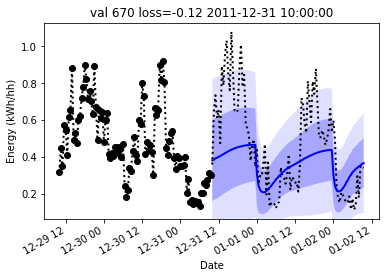

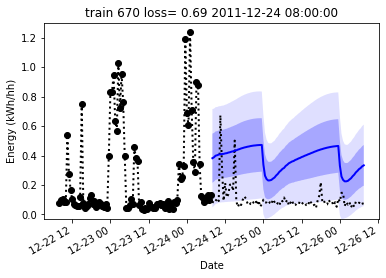

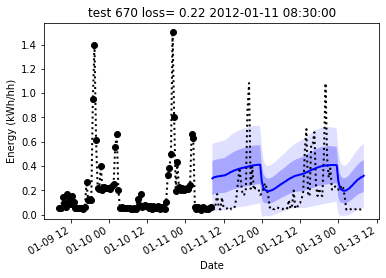

INFO:predict_heading2:step 0, {'agg_test_loss': 1.0427969694137573, 'log': {'agg_test_loss': 1.0427969694137573, 'agg_test_loss_p_weighted': 0.19133539497852325, 'agg_test_loss_p': 1.0427969694137573, 'agg_test_loss_mse': 0.06579779088497162, 'agg_test_score': 1.0427969694137573}}
----------------------------------------------------------------------------------------------------
TEST RESULTS
{}
----------------------------------------------------------------------------------------------------



anp-rnn_c_mean  anp-rnn_no_det_mean  \
agg_test_loss               3.264200e-01             0.583979   
agg_test_loss_p             3.264199e-01             0.530546   
agg_test_loss_kl            1.415805e-07             0.053432   
agg_test_loss_mse           5.554044e-02             0.050668   
agg_test_loss_p_weighted    6.167767e-02             0.099437   
agg_test_score              3.264199e-01             0.530546   
n                           1.000000e+00             1.000000   

                          PL_Transformer_mean  TransformerSeq2Seq_PL_mean  \
agg_test_loss                        0.554576                    0.600801   
agg_test_loss_p                      0.554576                    0.600801   
agg_test_loss_kl                          NaN                         NaN   
agg_test_loss_mse                    0.078667                    0.044556   
agg_test_loss_p_weighted             0.103580                    0.113829   
agg_test_score                       0.554576                    0.600801   
n                                    1.000000                    1.000000   

                          TransformerSeq2Seq_PL_lstm_mean  anp-rnn_mean  \
agg_test_loss                                    0.603395      0.908300   
agg_test_loss_p                                  0.603395      0.899200   
agg_test_loss_kl                                      NaN      0.009100   
agg_test_loss_mse                                0.047060      0.052031   
agg_test_loss_p_weighted                         0.114300      0.172292   
agg_test_score                                   0.603395      0.899200   
n                                                1.000000      1.000000   

                          LSTM_PL_STD_mean  anp-rnn_d_mean  anp_c_mean  \
agg_test_loss                     1.042797        1.405925    1.456276   
agg_test_loss_p                   1.042797        1.398106    1.448933   
agg_test_loss_kl                       NaN        0.007818    0.007343   
agg_test_loss_mse                 0.065798        0.050875    0.050474   
agg_test_loss_p_weighted          0.191335        0.257106    0.277617   
agg_test_score                    1.042797        1.398106    1.448933   
n                                 1.000000        1.000000    1.000000   

                          LSTMSeq2Seq_PL_attn_mean  \
agg_test_loss                             1.629111   
agg_test_loss_p                           1.629111   
agg_test_loss_kl                               NaN   
agg_test_loss_mse                         0.051648   
agg_test_loss_p_weighted                  0.275075   
agg_test_score                            1.629111   
n                                         1.000000   

                          anp-rnn_extras_no_det_mean  anp-rnn_extras_mean  \
agg_test_loss                               2.607442             2.559804   
agg_test_loss_p                             2.493560             2.559563   
agg_test_loss_kl                            0.113882             0.000241   
agg_test_loss_mse                           0.058096             0.051622   
agg_test_loss_p_weighted                    0.467946             0.454760   
agg_test_score                              2.493560             2.559563   
n                                           1.000000             1.000000   

                           np_mean  anp-rnn_pt_mean  LSTMSeq2Seq_PL_mean  
agg_test_loss             2.718724         2.821728             4.716095  
agg_test_loss_p           2.697164         2.806924             4.716095  
agg_test_loss_kl          0.021561         0.014804                  NaN  
agg_test_loss_mse         0.056558         0.049933             0.050778  
agg_test_loss_p_weighted  0.488960         0.539386             0.811491  
agg_test_score            2.697164         2.806924             4.716095  
n                         1.000000         1.000000             1.000000

1 {'name': 'anp-rnn', 'params': {'det_enc_cross_attn_type': 'multihead', 'det_enc_self_attn_type': 'multihead', 'latent_enc_self_attn_type': 'multihead', 'use_deterministic_path': True}, 'PL_MODEL_CLS': <class 'neural_processes.models.neural_process.lightning.PL_ANPRNN'>}
INFO:predict_heading2:now run `tensorboard --logdir lightning_logs`
INFO:root:GPU available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:predict_heading2:trial number=-1100 name=anp-rnn, trial=<optuna.trial.FixedTrial object at 0x7f8dec47bb00> params={'learning_rate': 0.003, 'num_heads_power': 2, 'hidden_dim_power': 6, 'latent_dim_power': 5, 'n_latent_encoder_layers': 3, 'n_det_encoder_layers': 3, 'n_decoder_layers': 4, 'dropout': 0.1, 'attention_dropout': 0.5, 'batchnorm': False, 'use_deterministic_path': True} attrs={'batch_size': 24, 'grad_clip': 40, 'max_nb_epochs': 20, 'num_workers': 3, 'num_context': 336, 'vis_i': '670', 'num_extra_target': 96, 'x_dim': 17, 'context_in_target': False, 'y_dim': 1, 'patience':

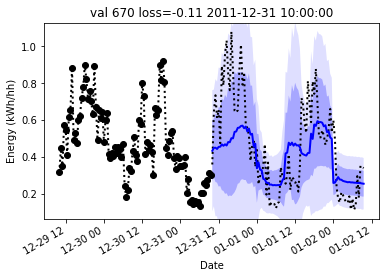

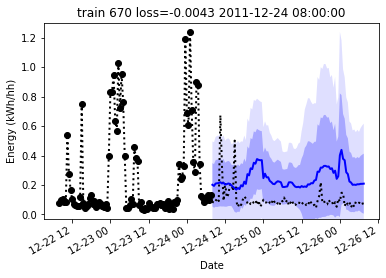

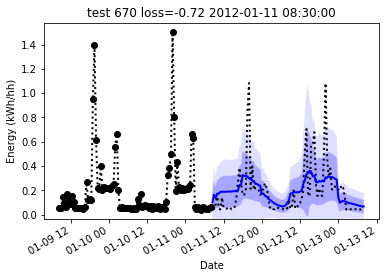

INFO:predict_heading2:step 0, {'agg_test_loss': 0.12560762465000153, 'log': {'agg_test_loss': 0.13102763891220093, 'agg_test_loss_p': 0.12560762465000153, 'agg_test_loss_kl': 0.005420011933892965, 'agg_test_loss_mse': 0.04171710088849068, 'agg_test_loss_p_weighted': 0.03254330903291702, 'agg_test_score': 0.12560762465000153}}
----------------------------------------------------------------------------------------------------
TEST RESULTS
{}
----------------------------------------------------------------------------------------------------



anp-rnn_c_mean  anp-rnn_mean  anp-rnn_no_det_mean  \
agg_test_loss               3.264200e-01      0.519664             0.583979   
agg_test_loss_p             3.264199e-01      0.512404             0.530546   
agg_test_loss_kl            1.415805e-07      0.007260             0.053432   
agg_test_loss_mse           5.554044e-02      0.046874             0.050668   
agg_test_loss_p_weighted    6.167767e-02      0.102418             0.099437   
agg_test_score              3.264199e-01      0.512404             0.530546   
n                           1.000000e+00      2.000000             1.000000   

                          PL_Transformer_mean  TransformerSeq2Seq_PL_mean  \
agg_test_loss                        0.554576                    0.600801   
agg_test_loss_p                      0.554576                    0.600801   
agg_test_loss_kl                          NaN                         NaN   
agg_test_loss_mse                    0.078667                    0.044556   
agg_test_loss_p_weighted             0.103580                    0.113829   
agg_test_score                       0.554576                    0.600801   
n                                    1.000000                    1.000000   

                          TransformerSeq2Seq_PL_lstm_mean  LSTM_PL_STD_mean  \
agg_test_loss                                    0.603395          1.042797   
agg_test_loss_p                                  0.603395          1.042797   
agg_test_loss_kl                                      NaN               NaN   
agg_test_loss_mse                                0.047060          0.065798   
agg_test_loss_p_weighted                         0.114300          0.191335   
agg_test_score                                   0.603395          1.042797   
n                                                1.000000          1.000000   

                          anp-rnn_d_mean  anp_c_mean  \
agg_test_loss                   1.405925    1.456276   
agg_test_loss_p                 1.398106    1.448933   
agg_test_loss_kl                0.007818    0.007343   
agg_test_loss_mse               0.050875    0.050474   
agg_test_loss_p_weighted        0.257106    0.277617   
agg_test_score                  1.398106    1.448933   
n                               1.000000    1.000000   

                          LSTMSeq2Seq_PL_attn_mean  \
agg_test_loss                             1.629111   
agg_test_loss_p                           1.629111   
agg_test_loss_kl                               NaN   
agg_test_loss_mse                         0.051648   
agg_test_loss_p_weighted                  0.275075   
agg_test_score                            1.629111   
n                                         1.000000   

                          anp-rnn_extras_no_det_mean  anp-rnn_extras_mean  \
agg_test_loss                               2.607442             2.559804   
agg_test_loss_p                             2.493560             2.559563   
agg_test_loss_kl                            0.113882             0.000241   
agg_test_loss_mse                           0.058096             0.051622   
agg_test_loss_p_weighted                    0.467946             0.454760   
agg_test_score                              2.493560             2.559563   
n                                           1.000000             1.000000   

                           np_mean  anp-rnn_pt_mean  LSTMSeq2Seq_PL_mean  
agg_test_loss             2.718724         2.821728             4.716095  
agg_test_loss_p           2.697164         2.806924             4.716095  
agg_test_loss_kl          0.021561         0.014804                  NaN  
agg_test_loss_mse         0.056558         0.049933             0.050778  
agg_test_loss_p_weighted  0.488960         0.539386             0.811491  
agg_test_score            2.697164         2.806924             4.716095  
n                         1.000000         1.000000             1.000000

1 {'name': 'anp-rnn_pt', 'params': {'det_enc_cross_attn_type': 'ptmultihead', 'det_enc_self_attn_type': 'ptmultihead', 'latent_enc_self_attn_type': 'ptmultihead', 'use_deterministic_path': True}, 'PL_MODEL_CLS': <class 'neural_processes.models.neural_process.lightning.PL_ANPRNN'>}
INFO:predict_heading2:now run `tensorboard --logdir lightning_logs`
INFO:root:GPU available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:predict_heading2:trial number=-1100 name=anp-rnn_pt, trial=<optuna.trial.FixedTrial object at 0x7f8d712a37f0> params={'learning_rate': 0.003, 'num_heads_power': 2, 'hidden_dim_power': 6, 'latent_dim_power': 5, 'n_latent_encoder_layers': 3, 'n_det_encoder_layers': 3, 'n_decoder_layers': 4, 'dropout': 0.1, 'attention_dropout': 0.5, 'batchnorm': False, 'use_deterministic_path': True} attrs={'batch_size': 24, 'grad_clip': 40, 'max_nb_epochs': 20, 'num_workers': 3, 'num_context': 336, 'vis_i': '670', 'num_extra_target': 96, 'x_dim': 17, 'context_in_target': False, 'y_dim': 1,

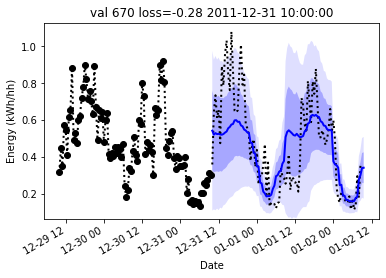

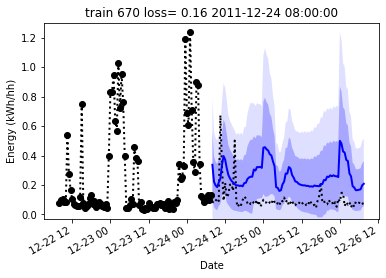

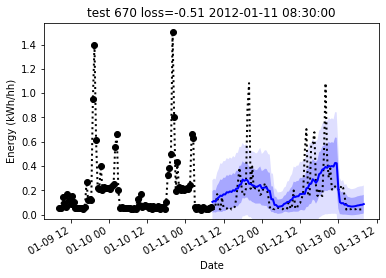

INFO:predict_heading2:step 0, {'agg_test_loss': -0.16237787902355194, 'log': {'agg_test_loss': -0.15489181876182556, 'agg_test_loss_p': -0.16237787902355194, 'agg_test_loss_kl': 0.007486071903258562, 'agg_test_loss_mse': 0.04123469442129135, 'agg_test_loss_p_weighted': -0.028847331181168556, 'agg_test_score': -0.16237787902355194}}
----------------------------------------------------------------------------------------------------
TEST RESULTS
{}
----------------------------------------------------------------------------------------------------



anp-rnn_c_mean  anp-rnn_mean  anp-rnn_no_det_mean  \
agg_test_loss               3.264200e-01      0.519664             0.583979   
agg_test_loss_p             3.264199e-01      0.512404             0.530546   
agg_test_loss_kl            1.415805e-07      0.007260             0.053432   
agg_test_loss_mse           5.554044e-02      0.046874             0.050668   
agg_test_loss_p_weighted    6.167767e-02      0.102418             0.099437   
agg_test_score              3.264199e-01      0.512404             0.530546   
n                           1.000000e+00      2.000000             1.000000   

                          PL_Transformer_mean  TransformerSeq2Seq_PL_mean  \
agg_test_loss                        0.554576                    0.600801   
agg_test_loss_p                      0.554576                    0.600801   
agg_test_loss_kl                          NaN                         NaN   
agg_test_loss_mse                    0.078667                    0.044556   
agg_test_loss_p_weighted             0.103580                    0.113829   
agg_test_score                       0.554576                    0.600801   
n                                    1.000000                    1.000000   

                          TransformerSeq2Seq_PL_lstm_mean  LSTM_PL_STD_mean  \
agg_test_loss                                    0.603395          1.042797   
agg_test_loss_p                                  0.603395          1.042797   
agg_test_loss_kl                                      NaN               NaN   
agg_test_loss_mse                                0.047060          0.065798   
agg_test_loss_p_weighted                         0.114300          0.191335   
agg_test_score                                   0.603395          1.042797   
n                                                1.000000          1.000000   

                          anp-rnn_pt_mean  anp-rnn_d_mean  anp_c_mean  \
agg_test_loss                    1.333418        1.405925    1.456276   
agg_test_loss_p                  1.322273        1.398106    1.448933   
agg_test_loss_kl                 0.011145        0.007818    0.007343   
agg_test_loss_mse                0.045584        0.050875    0.050474   
agg_test_loss_p_weighted         0.255269        0.257106    0.277617   
agg_test_score                   1.322273        1.398106    1.448933   
n                                2.000000        1.000000    1.000000   

                          LSTMSeq2Seq_PL_attn_mean  \
agg_test_loss                             1.629111   
agg_test_loss_p                           1.629111   
agg_test_loss_kl                               NaN   
agg_test_loss_mse                         0.051648   
agg_test_loss_p_weighted                  0.275075   
agg_test_score                            1.629111   
n                                         1.000000   

                          anp-rnn_extras_no_det_mean  anp-rnn_extras_mean  \
agg_test_loss                               2.607442             2.559804   
agg_test_loss_p                             2.493560             2.559563   
agg_test_loss_kl                            0.113882             0.000241   
agg_test_loss_mse                           0.058096             0.051622   
agg_test_loss_p_weighted                    0.467946             0.454760   
agg_test_score                              2.493560             2.559563   
n                                           1.000000             1.000000   

                           np_mean  LSTMSeq2Seq_PL_mean  
agg_test_loss             2.718724             4.716095  
agg_test_loss_p           2.697164             4.716095  
agg_test_loss_kl          0.021561                  NaN  
agg_test_loss_mse         0.056558             0.050778  
agg_test_loss_p_weighted  0.488960             0.811491  
agg_test_score            2.697164             4.716095  
n                         1.000000             1.000000

1 {'name': 'anp-rnn_c', 'params': {'det_enc_cross_attn_type': 'ptmultihead', 'det_enc_self_attn_type': 'ptmultihead', 'latent_enc_self_attn_type': 'ptmultihead', 'use_deterministic_path': True, 'batchnorm': False, 'attention_dropout': 0.5, 'dropout': 0.5, 'hidden_dim_power': 5.0, 'latent_dim_power': 8.0, 'learning_rate': 0.001, 'n_decoder_layers': 4, 'n_det_encoder_layers': 1, 'n_latent_encoder_layers': 4, 'num_heads_power': 3.0}, 'PL_MODEL_CLS': <class 'neural_processes.models.neural_process.lightning.PL_ANPRNN'>}
INFO:predict_heading2:now run `tensorboard --logdir lightning_logs`
INFO:root:GPU available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:predict_heading2:trial number=-1100 name=anp-rnn_c, trial=<optuna.trial.FixedTrial object at 0x7f8d6cfb1470> params={'learning_rate': 0.001, 'num_heads_power': 3.0, 'hidden_dim_power': 5.0, 'latent_dim_power': 8.0, 'n_latent_encoder_layers': 4, 'n_det_encoder_layers': 1, 'n_decoder_layers': 4, 'dropout': 0.5, 'attention_dropout': 0.5, '

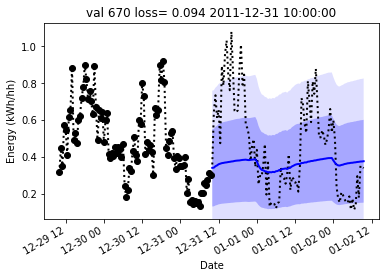

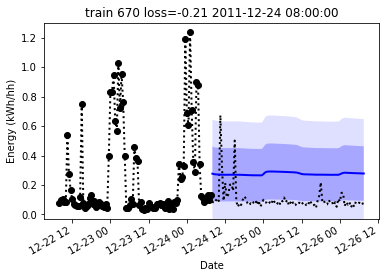

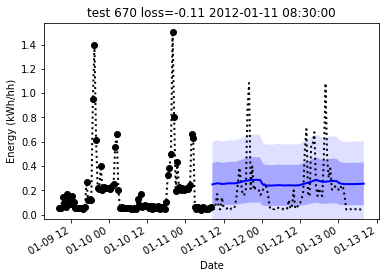

INFO:predict_heading2:step 0, {'agg_test_loss': 0.022198934108018875, 'log': {'agg_test_loss': 0.02246629074215889, 'agg_test_loss_p': 0.022198934108018875, 'agg_test_loss_kl': 0.00026735535357147455, 'agg_test_loss_mse': 0.05315973237156868, 'agg_test_loss_p_weighted': 0.004420903977006674, 'agg_test_score': 0.022198934108018875}}
----------------------------------------------------------------------------------------------------
TEST RESULTS
{}
----------------------------------------------------------------------------------------------------



anp-rnn_c_mean  anp-rnn_mean  anp-rnn_no_det_mean  \
agg_test_loss                   0.174443      0.519664             0.583979   
agg_test_loss_p                 0.174309      0.512404             0.530546   
agg_test_loss_kl                0.000134      0.007260             0.053432   
agg_test_loss_mse               0.054350      0.046874             0.050668   
agg_test_loss_p_weighted        0.033049      0.102418             0.099437   
agg_test_score                  0.174309      0.512404             0.530546   
n                               2.000000      2.000000             1.000000   

                          PL_Transformer_mean  TransformerSeq2Seq_PL_mean  \
agg_test_loss                        0.554576                    0.600801   
agg_test_loss_p                      0.554576                    0.600801   
agg_test_loss_kl                          NaN                         NaN   
agg_test_loss_mse                    0.078667                    0.044556   
agg_test_loss_p_weighted             0.103580                    0.113829   
agg_test_score                       0.554576                    0.600801   
n                                    1.000000                    1.000000   

                          TransformerSeq2Seq_PL_lstm_mean  LSTM_PL_STD_mean  \
agg_test_loss                                    0.603395          1.042797   
agg_test_loss_p                                  0.603395          1.042797   
agg_test_loss_kl                                      NaN               NaN   
agg_test_loss_mse                                0.047060          0.065798   
agg_test_loss_p_weighted                         0.114300          0.191335   
agg_test_score                                   0.603395          1.042797   
n                                                1.000000          1.000000   

                          anp-rnn_pt_mean  anp-rnn_d_mean  anp_c_mean  \
agg_test_loss                    1.333418        1.405925    1.456276   
agg_test_loss_p                  1.322273        1.398106    1.448933   
agg_test_loss_kl                 0.011145        0.007818    0.007343   
agg_test_loss_mse                0.045584        0.050875    0.050474   
agg_test_loss_p_weighted         0.255269        0.257106    0.277617   
agg_test_score                   1.322273        1.398106    1.448933   
n                                2.000000        1.000000    1.000000   

                          LSTMSeq2Seq_PL_attn_mean  \
agg_test_loss                             1.629111   
agg_test_loss_p                           1.629111   
agg_test_loss_kl                               NaN   
agg_test_loss_mse                         0.051648   
agg_test_loss_p_weighted                  0.275075   
agg_test_score                            1.629111   
n                                         1.000000   

                          anp-rnn_extras_no_det_mean  anp-rnn_extras_mean  \
agg_test_loss                               2.607442             2.559804   
agg_test_loss_p                             2.493560             2.559563   
agg_test_loss_kl                            0.113882             0.000241   
agg_test_loss_mse                           0.058096             0.051622   
agg_test_loss_p_weighted                    0.467946             0.454760   
agg_test_score                              2.493560             2.559563   
n                                           1.000000             1.000000   

                           np_mean  LSTMSeq2Seq_PL_mean  
agg_test_loss             2.718724             4.716095  
agg_test_loss_p           2.697164             4.716095  
agg_test_loss_kl          0.021561                  NaN  
agg_test_loss_mse         0.056558             0.050778  
agg_test_loss_p_weighted  0.488960             0.811491  
agg_test_score            2.697164             4.716095  
n                         1.000000             1.000000

1 {'name': 'anp-rnn_d', 'params': {'det_enc_cross_attn_type': 'ptmultihead', 'det_enc_self_attn_type': 'ptmultihead', 'latent_enc_self_attn_type': 'ptmultihead', 'use_deterministic_path': True, 'batchnorm': False, 'attention_dropout': 0.7, 'dropout': 0.1, 'hidden_dim_power': 6.0, 'latent_dim_power': 6.0, 'learning_rate': 0.001, 'n_decoder_layers': 4, 'n_det_encoder_layers': 3, 'n_latent_encoder_layers': 4, 'num_heads_power': 2.0}, 'PL_MODEL_CLS': <class 'neural_processes.models.neural_process.lightning.PL_ANPRNN'>}
INFO:predict_heading2:now run `tensorboard --logdir lightning_logs`
INFO:root:GPU available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:predict_heading2:trial number=-1100 name=anp-rnn_d, trial=<optuna.trial.FixedTrial object at 0x7f8d6cfa7518> params={'learning_rate': 0.001, 'num_heads_power': 2.0, 'hidden_dim_power': 6.0, 'latent_dim_power': 6.0, 'n_latent_encoder_layers': 4, 'n_det_encoder_layers': 3, 'n_decoder_layers': 4, 'dropout': 0.1, 'attention_dropout': 0.7, '

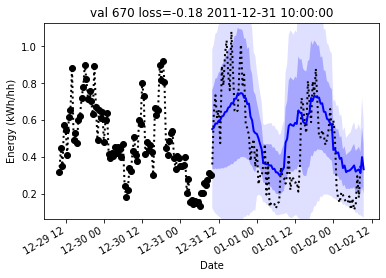

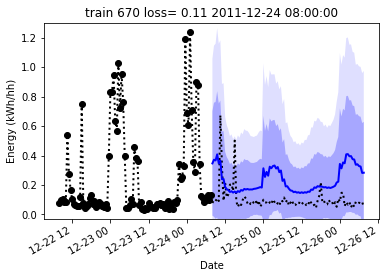

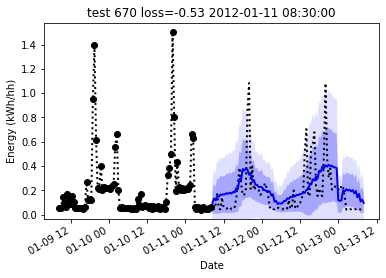

INFO:predict_heading2:step 0, {'agg_test_loss': -0.17980867624282837, 'log': {'agg_test_loss': -0.17329134047031403, 'agg_test_loss_p': -0.17980867624282837, 'agg_test_loss_kl': 0.0065173376351594925, 'agg_test_loss_mse': 0.04297592118382454, 'agg_test_loss_p_weighted': -0.03627816215157509, 'agg_test_score': -0.17980867624282837}}
----------------------------------------------------------------------------------------------------
TEST RESULTS
{}
----------------------------------------------------------------------------------------------------



anp-rnn_c_mean  anp-rnn_mean  anp-rnn_no_det_mean  \
agg_test_loss                   0.174443      0.519664             0.583979   
agg_test_loss_p                 0.174309      0.512404             0.530546   
agg_test_loss_kl                0.000134      0.007260             0.053432   
agg_test_loss_mse               0.054350      0.046874             0.050668   
agg_test_loss_p_weighted        0.033049      0.102418             0.099437   
agg_test_score                  0.174309      0.512404             0.530546   
n                               2.000000      2.000000             1.000000   

                          PL_Transformer_mean  TransformerSeq2Seq_PL_mean  \
agg_test_loss                        0.554576                    0.600801   
agg_test_loss_p                      0.554576                    0.600801   
agg_test_loss_kl                          NaN                         NaN   
agg_test_loss_mse                    0.078667                    0.044556   
agg_test_loss_p_weighted             0.103580                    0.113829   
agg_test_score                       0.554576                    0.600801   
n                                    1.000000                    1.000000   

                          TransformerSeq2Seq_PL_lstm_mean  anp-rnn_d_mean  \
agg_test_loss                                    0.603395        0.616317   
agg_test_loss_p                                  0.603395        0.609149   
agg_test_loss_kl                                      NaN        0.007168   
agg_test_loss_mse                                0.047060        0.046925   
agg_test_loss_p_weighted                         0.114300        0.110414   
agg_test_score                                   0.603395        0.609149   
n                                                1.000000        2.000000   

                          LSTM_PL_STD_mean  anp-rnn_pt_mean  anp_c_mean  \
agg_test_loss                     1.042797         1.333418    1.456276   
agg_test_loss_p                   1.042797         1.322273    1.448933   
agg_test_loss_kl                       NaN         0.011145    0.007343   
agg_test_loss_mse                 0.065798         0.045584    0.050474   
agg_test_loss_p_weighted          0.191335         0.255269    0.277617   
agg_test_score                    1.042797         1.322273    1.448933   
n                                 1.000000         2.000000    1.000000   

                          LSTMSeq2Seq_PL_attn_mean  \
agg_test_loss                             1.629111   
agg_test_loss_p                           1.629111   
agg_test_loss_kl                               NaN   
agg_test_loss_mse                         0.051648   
agg_test_loss_p_weighted                  0.275075   
agg_test_score                            1.629111   
n                                         1.000000   

                          anp-rnn_extras_no_det_mean  anp-rnn_extras_mean  \
agg_test_loss                               2.607442             2.559804   
agg_test_loss_p                             2.493560             2.559563   
agg_test_loss_kl                            0.113882             0.000241   
agg_test_loss_mse                           0.058096             0.051622   
agg_test_loss_p_weighted                    0.467946             0.454760   
agg_test_score                              2.493560             2.559563   
n                                           1.000000             1.000000   

                           np_mean  LSTMSeq2Seq_PL_mean  
agg_test_loss             2.718724             4.716095  
agg_test_loss_p           2.697164             4.716095  
agg_test_loss_kl          0.021561                  NaN  
agg_test_loss_mse         0.056558             0.050778  
agg_test_loss_p_weighted  0.488960             0.811491  
agg_test_score            2.697164             4.716095  
n                         1.000000             1.000000

1 {'name': 'anp-rnn_extras', 'params': {'det_enc_cross_attn_type': 'ptmultihead', 'det_enc_self_attn_type': 'ptmultihead', 'latent_enc_self_attn_type': 'ptmultihead', 'use_deterministic_path': True, 'batchnorm': True, 'attention_dropout': 0.4, 'dropout': 0.2, 'use_lvar': True}, 'PL_MODEL_CLS': <class 'neural_processes.models.neural_process.lightning.PL_ANPRNN'>}
INFO:predict_heading2:now run `tensorboard --logdir lightning_logs`
INFO:root:GPU available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:predict_heading2:trial number=-1100 name=anp-rnn_extras, trial=<optuna.trial.FixedTrial object at 0x7f8d6e483438> params={'learning_rate': 0.003, 'num_heads_power': 2, 'hidden_dim_power': 6, 'latent_dim_power': 5, 'n_latent_encoder_layers': 3, 'n_det_encoder_layers': 3, 'n_decoder_layers': 4, 'dropout': 0.2, 'attention_dropout': 0.4, 'batchnorm': True, 'use_deterministic_path': True} attrs={'batch_size': 24, 'grad_clip': 40, 'max_nb_epochs': 20, 'num_workers': 3, 'num_context': 336, 'vis_i

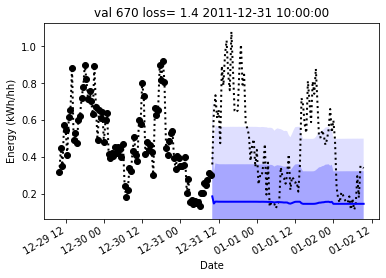

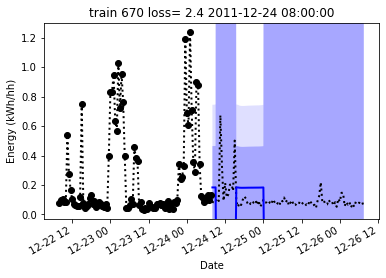

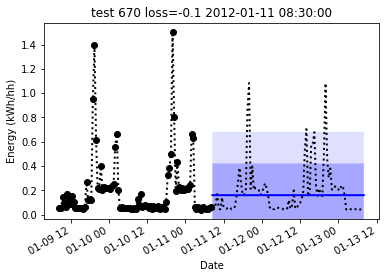

INFO:predict_heading2:step 0, {'agg_test_loss': 0.4552057683467865, 'log': {'agg_test_loss': 0.45520710945129395, 'agg_test_loss_p': 0.4552057683467865, 'agg_test_loss_kl': 1.3466556083585601e-06, 'agg_test_loss_mse': 0.3951230049133301, 'agg_test_loss_p_weighted': 0.0849161371588707, 'agg_test_score': 0.4552057683467865}}
----------------------------------------------------------------------------------------------------
TEST RESULTS
{}
----------------------------------------------------------------------------------------------------



anp-rnn_c_mean  anp-rnn_mean  anp-rnn_no_det_mean  \
agg_test_loss                   0.174443      0.519664             0.583979   
agg_test_loss_p                 0.174309      0.512404             0.530546   
agg_test_loss_kl                0.000134      0.007260             0.053432   
agg_test_loss_mse               0.054350      0.046874             0.050668   
agg_test_loss_p_weighted        0.033049      0.102418             0.099437   
agg_test_score                  0.174309      0.512404             0.530546   
n                               2.000000      2.000000             1.000000   

                          PL_Transformer_mean  TransformerSeq2Seq_PL_mean  \
agg_test_loss                        0.554576                    0.600801   
agg_test_loss_p                      0.554576                    0.600801   
agg_test_loss_kl                          NaN                         NaN   
agg_test_loss_mse                    0.078667                    0.044556   
agg_test_loss_p_weighted             0.103580                    0.113829   
agg_test_score                       0.554576                    0.600801   
n                                    1.000000                    1.000000   

                          TransformerSeq2Seq_PL_lstm_mean  anp-rnn_d_mean  \
agg_test_loss                                    0.603395        0.616317   
agg_test_loss_p                                  0.603395        0.609149   
agg_test_loss_kl                                      NaN        0.007168   
agg_test_loss_mse                                0.047060        0.046925   
agg_test_loss_p_weighted                         0.114300        0.110414   
agg_test_score                                   0.603395        0.609149   
n                                                1.000000        2.000000   

                          LSTM_PL_STD_mean  anp-rnn_pt_mean  anp_c_mean  \
agg_test_loss                     1.042797         1.333418    1.456276   
agg_test_loss_p                   1.042797         1.322273    1.448933   
agg_test_loss_kl                       NaN         0.011145    0.007343   
agg_test_loss_mse                 0.065798         0.045584    0.050474   
agg_test_loss_p_weighted          0.191335         0.255269    0.277617   
agg_test_score                    1.042797         1.322273    1.448933   
n                                 1.000000         2.000000    1.000000   

                          anp-rnn_extras_mean  LSTMSeq2Seq_PL_attn_mean  \
agg_test_loss                        1.507506                  1.629111   
agg_test_loss_p                      1.507384                  1.629111   
agg_test_loss_kl                     0.000121                       NaN   
agg_test_loss_mse                    0.223373                  0.051648   
agg_test_loss_p_weighted             0.269838                  0.275075   
agg_test_score                       1.507384                  1.629111   
n                                    2.000000                  1.000000   

                          anp-rnn_extras_no_det_mean   np_mean  \
agg_test_loss                               2.607442  2.718724   
agg_test_loss_p                             2.493560  2.697164   
agg_test_loss_kl                            0.113882  0.021561   
agg_test_loss_mse                           0.058096  0.056558   
agg_test_loss_p_weighted                    0.467946  0.488960   
agg_test_score                              2.493560  2.697164   
n                                           1.000000  1.000000   

                          LSTMSeq2Seq_PL_mean  
agg_test_loss                        4.716095  
agg_test_loss_p                      4.716095  
agg_test_loss_kl                          NaN  
agg_test_loss_mse                    0.050778  
agg_test_loss_p_weighted             0.811491  
agg_test_score                       4.716095  
n                                    1.000000

1 {'name': 'anp-rnn_extras_no_det', 'params': {'det_enc_cross_attn_type': 'ptmultihead', 'det_enc_self_attn_type': 'ptmultihead', 'latent_enc_self_attn_type': 'ptmultihead', 'use_deterministic_path': False, 'batchnorm': True, 'attention_dropout': 0.4, 'dropout': 0.2, 'use_lvar': True}, 'PL_MODEL_CLS': <class 'neural_processes.models.neural_process.lightning.PL_ANPRNN'>}
INFO:predict_heading2:now run `tensorboard --logdir lightning_logs`
INFO:root:GPU available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:predict_heading2:trial number=-1100 name=anp-rnn_extras_no_det, trial=<optuna.trial.FixedTrial object at 0x7f8d712c80f0> params={'learning_rate': 0.003, 'num_heads_power': 2, 'hidden_dim_power': 6, 'latent_dim_power': 5, 'n_latent_encoder_layers': 3, 'n_det_encoder_layers': 3, 'n_decoder_layers': 4, 'dropout': 0.2, 'attention_dropout': 0.4, 'batchnorm': True, 'use_deterministic_path': False} attrs={'batch_size': 24, 'grad_clip': 40, 'max_nb_epochs': 20, 'num_workers': 3, 'num_conte

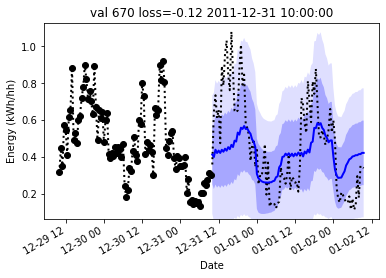

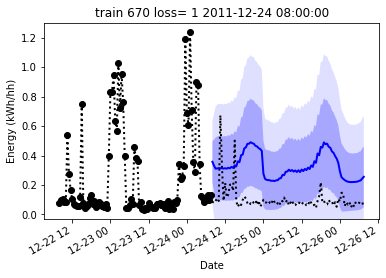

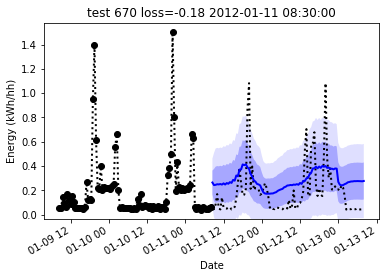

INFO:predict_heading2:step 0, {'agg_test_loss': -0.01660873182117939, 'log': {'agg_test_loss': 0.008417361415922642, 'agg_test_loss_p': -0.01660873182117939, 'agg_test_loss_kl': 0.025026092305779457, 'agg_test_loss_mse': 0.05070006102323532, 'agg_test_loss_p_weighted': 0.006162304896861315, 'agg_test_score': -0.01660873182117939}}
----------------------------------------------------------------------------------------------------
TEST RESULTS
{}
----------------------------------------------------------------------------------------------------



anp-rnn_c_mean  anp-rnn_mean  anp-rnn_no_det_mean  \
agg_test_loss                   0.174443      0.519664             0.583979   
agg_test_loss_p                 0.174309      0.512404             0.530546   
agg_test_loss_kl                0.000134      0.007260             0.053432   
agg_test_loss_mse               0.054350      0.046874             0.050668   
agg_test_loss_p_weighted        0.033049      0.102418             0.099437   
agg_test_score                  0.174309      0.512404             0.530546   
n                               2.000000      2.000000             1.000000   

                          PL_Transformer_mean  TransformerSeq2Seq_PL_mean  \
agg_test_loss                        0.554576                    0.600801   
agg_test_loss_p                      0.554576                    0.600801   
agg_test_loss_kl                          NaN                         NaN   
agg_test_loss_mse                    0.078667                    0.044556   
agg_test_loss_p_weighted             0.103580                    0.113829   
agg_test_score                       0.554576                    0.600801   
n                                    1.000000                    1.000000   

                          TransformerSeq2Seq_PL_lstm_mean  anp-rnn_d_mean  \
agg_test_loss                                    0.603395        0.616317   
agg_test_loss_p                                  0.603395        0.609149   
agg_test_loss_kl                                      NaN        0.007168   
agg_test_loss_mse                                0.047060        0.046925   
agg_test_loss_p_weighted                         0.114300        0.110414   
agg_test_score                                   0.603395        0.609149   
n                                                1.000000        2.000000   

                          LSTM_PL_STD_mean  anp-rnn_extras_no_det_mean  \
agg_test_loss                     1.042797                    1.307930   
agg_test_loss_p                   1.042797                    1.238475   
agg_test_loss_kl                       NaN                    0.069454   
agg_test_loss_mse                 0.065798                    0.054398   
agg_test_loss_p_weighted          0.191335                    0.237054   
agg_test_score                    1.042797                    1.238475   
n                                 1.000000                    2.000000   

                          anp-rnn_pt_mean  anp_c_mean  anp-rnn_extras_mean  \
agg_test_loss                    1.333418    1.456276             1.507506   
agg_test_loss_p                  1.322273    1.448933             1.507384   
agg_test_loss_kl                 0.011145    0.007343             0.000121   
agg_test_loss_mse                0.045584    0.050474             0.223373   
agg_test_loss_p_weighted         0.255269    0.277617             0.269838   
agg_test_score                   1.322273    1.448933             1.507384   
n                                2.000000    1.000000             2.000000   

                          LSTMSeq2Seq_PL_attn_mean   np_mean  \
agg_test_loss                             1.629111  2.718724   
agg_test_loss_p                           1.629111  2.697164   
agg_test_loss_kl                               NaN  0.021561   
agg_test_loss_mse                         0.051648  0.056558   
agg_test_loss_p_weighted                  0.275075  0.488960   
agg_test_score                            1.629111  2.697164   
n                                         1.000000  1.000000   

                          LSTMSeq2Seq_PL_mean  
agg_test_loss                        4.716095  
agg_test_loss_p                      4.716095  
agg_test_loss_kl                          NaN  
agg_test_loss_mse                    0.050778  
agg_test_loss_p_weighted             0.811491  
agg_test_score                       4.716095  
n                                    1.000000

1 {'name': 'anp-rnn_no_det', 'params': {'use_deterministic_path': False}, 'PL_MODEL_CLS': <class 'neural_processes.models.neural_process.lightning.PL_ANPRNN'>}
INFO:predict_heading2:now run `tensorboard --logdir lightning_logs`
INFO:root:GPU available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:predict_heading2:trial number=-1100 name=anp-rnn_no_det, trial=<optuna.trial.FixedTrial object at 0x7f8d6e53e9b0> params={'learning_rate': 0.003, 'num_heads_power': 2, 'hidden_dim_power': 6, 'latent_dim_power': 5, 'n_latent_encoder_layers': 3, 'n_det_encoder_layers': 3, 'n_decoder_layers': 4, 'dropout': 0.1, 'attention_dropout': 0.5, 'batchnorm': False, 'use_deterministic_path': False} attrs={'batch_size': 24, 'grad_clip': 40, 'max_nb_epochs': 20, 'num_workers': 3, 'num_context': 336, 'vis_i': '670', 'num_extra_target': 96, 'x_dim': 17, 'context_in_target': False, 'y_dim': 1, 'patience': 2, 'min_std': 0.005, 'max_epoch_steps': 19200}
INFO:predict_heading2:Loading checkpoint lightning_logs/a

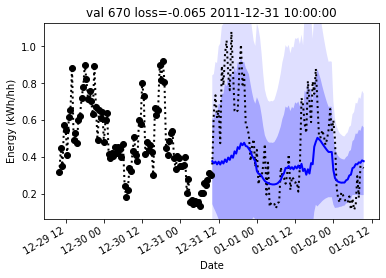

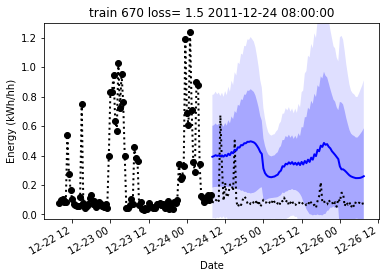

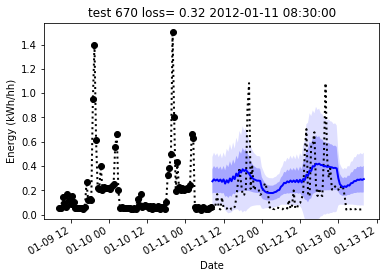

INFO:predict_heading2:step 0, {'agg_test_loss': 0.4863528311252594, 'log': {'agg_test_loss': 0.5092053413391113, 'agg_test_loss_p': 0.4863528311252594, 'agg_test_loss_kl': 0.022852495312690735, 'agg_test_loss_mse': 0.05612186715006828, 'agg_test_loss_p_weighted': 0.0918201208114624, 'agg_test_score': 0.4863528311252594}}
----------------------------------------------------------------------------------------------------
TEST RESULTS
{}
----------------------------------------------------------------------------------------------------



anp-rnn_c_mean  anp-rnn_no_det_mean  anp-rnn_mean  \
agg_test_loss                   0.174443             0.546592      0.519664   
agg_test_loss_p                 0.174309             0.508449      0.512404   
agg_test_loss_kl                0.000134             0.038142      0.007260   
agg_test_loss_mse               0.054350             0.053395      0.046874   
agg_test_loss_p_weighted        0.033049             0.095628      0.102418   
agg_test_score                  0.174309             0.508449      0.512404   
n                               2.000000             2.000000      2.000000   

                          PL_Transformer_mean  TransformerSeq2Seq_PL_mean  \
agg_test_loss                        0.554576                    0.600801   
agg_test_loss_p                      0.554576                    0.600801   
agg_test_loss_kl                          NaN                         NaN   
agg_test_loss_mse                    0.078667                    0.044556   
agg_test_loss_p_weighted             0.103580                    0.113829   
agg_test_score                       0.554576                    0.600801   
n                                    1.000000                    1.000000   

                          TransformerSeq2Seq_PL_lstm_mean  anp-rnn_d_mean  \
agg_test_loss                                    0.603395        0.616317   
agg_test_loss_p                                  0.603395        0.609149   
agg_test_loss_kl                                      NaN        0.007168   
agg_test_loss_mse                                0.047060        0.046925   
agg_test_loss_p_weighted                         0.114300        0.110414   
agg_test_score                                   0.603395        0.609149   
n                                                1.000000        2.000000   

                          LSTM_PL_STD_mean  anp-rnn_extras_no_det_mean  \
agg_test_loss                     1.042797                    1.307930   
agg_test_loss_p                   1.042797                    1.238475   
agg_test_loss_kl                       NaN                    0.069454   
agg_test_loss_mse                 0.065798                    0.054398   
agg_test_loss_p_weighted          0.191335                    0.237054   
agg_test_score                    1.042797                    1.238475   
n                                 1.000000                    2.000000   

                          anp-rnn_pt_mean  anp_c_mean  anp-rnn_extras_mean  \
agg_test_loss                    1.333418    1.456276             1.507506   
agg_test_loss_p                  1.322273    1.448933             1.507384   
agg_test_loss_kl                 0.011145    0.007343             0.000121   
agg_test_loss_mse                0.045584    0.050474             0.223373   
agg_test_loss_p_weighted         0.255269    0.277617             0.269838   
agg_test_score                   1.322273    1.448933             1.507384   
n                                2.000000    1.000000             2.000000   

                          LSTMSeq2Seq_PL_attn_mean   np_mean  \
agg_test_loss                             1.629111  2.718724   
agg_test_loss_p                           1.629111  2.697164   
agg_test_loss_kl                               NaN  0.021561   
agg_test_loss_mse                         0.051648  0.056558   
agg_test_loss_p_weighted                  0.275075  0.488960   
agg_test_score                            1.629111  2.697164   
n                                         1.000000  1.000000   

                          LSTMSeq2Seq_PL_mean  
agg_test_loss                        4.716095  
agg_test_loss_p                      4.716095  
agg_test_loss_kl                          NaN  
agg_test_loss_mse                    0.050778  
agg_test_loss_p_weighted             0.811491  
agg_test_score                       4.716095  
n                                    1.000000

1 {'name': 'TransformerSeq2Seq_PL_lstm', 'params': {'use_lstm': True}, 'PL_MODEL_CLS': <class 'neural_processes.models.transformer_seq2seq.TransformerSeq2Seq_PL'>}
INFO:predict_heading2:now run `tensorboard --logdir lightning_logs`
INFO:root:GPU available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:predict_heading2:trial number=-1100 name=TransformerSeq2Seq_PL_lstm, trial=<optuna.trial.FixedTrial object at 0x7f8ded8ed588> params={'learning_rate': 0.002, 'attention_dropout': 0.2, 'hidden_size_power': 5, 'hidden_out_size_power': 4, 'nhead_power': 3, 'nlayers': 2, 'use_lstm': True, 'agg': 'max'} attrs={'batch_size': 24, 'grad_clip': 40, 'max_nb_epochs': 20, 'num_workers': 3, 'num_extra_target': 96, 'vis_i': '670', 'num_context': 336, 'input_size': 18, 'input_size_decoder': 17, 'context_in_target': False, 'output_size': 1, 'patience': 2, 'min_std': 0.005, 'x_dim': 17, 'y_dim': 1, 'max_epoch_steps': 19200}
INFO:predict_heading2:Loading checkpoint lightning_logs/TransformerSeq2Seq_PL_ls

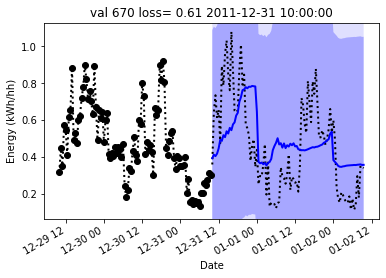

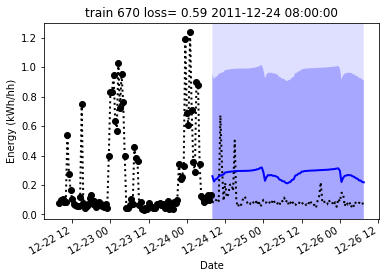

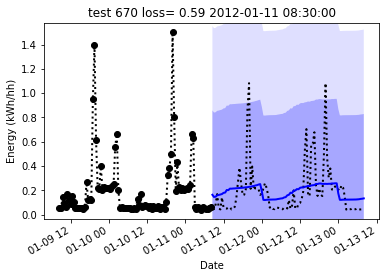

INFO:predict_heading2:step 0, {'agg_test_loss': 0.6017508506774902, 'log': {'agg_test_loss': 0.6017508506774902, 'agg_test_loss_p': 0.6017508506774902, 'agg_test_loss_mse': 0.045472919940948486, 'agg_test_loss_p_weighted': 0.114017054438591, 'agg_test_score': 0.6017508506774902}}
----------------------------------------------------------------------------------------------------
TEST RESULTS
{}
----------------------------------------------------------------------------------------------------



anp-rnn_c_mean  anp-rnn_no_det_mean  anp-rnn_mean  \
agg_test_loss                   0.174443             0.546592      0.519664   
agg_test_loss_p                 0.174309             0.508449      0.512404   
agg_test_loss_kl                0.000134             0.038142      0.007260   
agg_test_loss_mse               0.054350             0.053395      0.046874   
agg_test_loss_p_weighted        0.033049             0.095628      0.102418   
agg_test_score                  0.174309             0.508449      0.512404   
n                               2.000000             2.000000      2.000000   

                          PL_Transformer_mean  TransformerSeq2Seq_PL_mean  \
agg_test_loss                        0.554576                    0.600801   
agg_test_loss_p                      0.554576                    0.600801   
agg_test_loss_kl                          NaN                         NaN   
agg_test_loss_mse                    0.078667                    0.044556   
agg_test_loss_p_weighted             0.103580                    0.113829   
agg_test_score                       0.554576                    0.600801   
n                                    1.000000                    1.000000   

                          TransformerSeq2Seq_PL_lstm_mean  anp-rnn_d_mean  \
agg_test_loss                                    0.602573        0.616317   
agg_test_loss_p                                  0.602573        0.609149   
agg_test_loss_kl                                      NaN        0.007168   
agg_test_loss_mse                                0.046267        0.046925   
agg_test_loss_p_weighted                         0.114158        0.110414   
agg_test_score                                   0.602573        0.609149   
n                                                2.000000        2.000000   

                          LSTM_PL_STD_mean  anp-rnn_extras_no_det_mean  \
agg_test_loss                     1.042797                    1.307930   
agg_test_loss_p                   1.042797                    1.238475   
agg_test_loss_kl                       NaN                    0.069454   
agg_test_loss_mse                 0.065798                    0.054398   
agg_test_loss_p_weighted          0.191335                    0.237054   
agg_test_score                    1.042797                    1.238475   
n                                 1.000000                    2.000000   

                          anp-rnn_pt_mean  anp_c_mean  anp-rnn_extras_mean  \
agg_test_loss                    1.333418    1.456276             1.507506   
agg_test_loss_p                  1.322273    1.448933             1.507384   
agg_test_loss_kl                 0.011145    0.007343             0.000121   
agg_test_loss_mse                0.045584    0.050474             0.223373   
agg_test_loss_p_weighted         0.255269    0.277617             0.269838   
agg_test_score                   1.322273    1.448933             1.507384   
n                                2.000000    1.000000             2.000000   

                          LSTMSeq2Seq_PL_attn_mean   np_mean  \
agg_test_loss                             1.629111  2.718724   
agg_test_loss_p                           1.629111  2.697164   
agg_test_loss_kl                               NaN  0.021561   
agg_test_loss_mse                         0.051648  0.056558   
agg_test_loss_p_weighted                  0.275075  0.488960   
agg_test_score                            1.629111  2.697164   
n                                         1.000000  1.000000   

                          LSTMSeq2Seq_PL_mean  
agg_test_loss                        4.716095  
agg_test_loss_p                      4.716095  
agg_test_loss_kl                          NaN  
agg_test_loss_mse                    0.050778  
agg_test_loss_p_weighted             0.811491  
agg_test_score                       4.716095  
n                                    1.000000

1 {'name': 'TransformerSeq2Seq_PL', 'PL_MODEL_CLS': <class 'neural_processes.models.transformer_seq2seq.TransformerSeq2Seq_PL'>}
INFO:predict_heading2:now run `tensorboard --logdir lightning_logs`
INFO:root:GPU available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:predict_heading2:trial number=-1100 name=TransformerSeq2Seq_PL, trial=<optuna.trial.FixedTrial object at 0x7f8ded9901d0> params={'learning_rate': 0.002, 'attention_dropout': 0.2, 'hidden_size_power': 5, 'hidden_out_size_power': 4, 'nhead_power': 3, 'nlayers': 2, 'use_lstm': False, 'agg': 'max'} attrs={'batch_size': 24, 'grad_clip': 40, 'max_nb_epochs': 20, 'num_workers': 3, 'num_extra_target': 96, 'vis_i': '670', 'num_context': 336, 'input_size': 18, 'input_size_decoder': 17, 'context_in_target': False, 'output_size': 1, 'patience': 2, 'min_std': 0.005, 'x_dim': 17, 'y_dim': 1, 'max_epoch_steps': 19200}
INFO:predict_heading2:Loading checkpoint lightning_logs/TransformerSeq2Seq_PL/version_-1100/_ckpt_epoch_4.ckpt


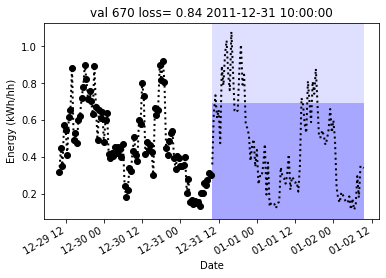

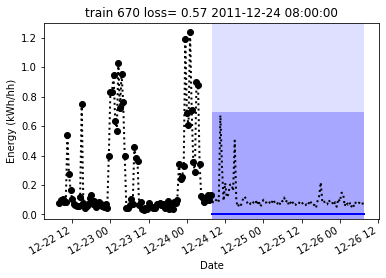

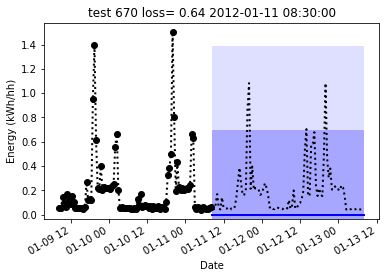

INFO:predict_heading2:step 0, {'agg_test_loss': 0.6456514596939087, 'log': {'agg_test_loss': 0.6456514596939087, 'agg_test_loss_p': 0.6456514596939087, 'agg_test_loss_mse': 0.08784421533346176, 'agg_test_loss_p_weighted': 0.12235559523105621, 'agg_test_score': 0.6456514596939087}}
----------------------------------------------------------------------------------------------------
TEST RESULTS
{}
----------------------------------------------------------------------------------------------------



anp-rnn_c_mean  anp-rnn_no_det_mean  anp-rnn_mean  \
agg_test_loss                   0.174443             0.546592      0.519664   
agg_test_loss_p                 0.174309             0.508449      0.512404   
agg_test_loss_kl                0.000134             0.038142      0.007260   
agg_test_loss_mse               0.054350             0.053395      0.046874   
agg_test_loss_p_weighted        0.033049             0.095628      0.102418   
agg_test_score                  0.174309             0.508449      0.512404   
n                               2.000000             2.000000      2.000000   

                          PL_Transformer_mean  \
agg_test_loss                        0.554576   
agg_test_loss_p                      0.554576   
agg_test_loss_kl                          NaN   
agg_test_loss_mse                    0.078667   
agg_test_loss_p_weighted             0.103580   
agg_test_score                       0.554576   
n                                    1.000000   

                          TransformerSeq2Seq_PL_lstm_mean  anp-rnn_d_mean  \
agg_test_loss                                    0.602573        0.616317   
agg_test_loss_p                                  0.602573        0.609149   
agg_test_loss_kl                                      NaN        0.007168   
agg_test_loss_mse                                0.046267        0.046925   
agg_test_loss_p_weighted                         0.114158        0.110414   
agg_test_score                                   0.602573        0.609149   
n                                                2.000000        2.000000   

                          TransformerSeq2Seq_PL_mean  LSTM_PL_STD_mean  \
agg_test_loss                               0.623226          1.042797   
agg_test_loss_p                             0.623226          1.042797   
agg_test_loss_kl                                 NaN               NaN   
agg_test_loss_mse                           0.066200          0.065798   
agg_test_loss_p_weighted                    0.118092          0.191335   
agg_test_score                              0.623226          1.042797   
n                                           2.000000          1.000000   

                          anp-rnn_extras_no_det_mean  anp-rnn_pt_mean  \
agg_test_loss                               1.307930         1.333418   
agg_test_loss_p                             1.238475         1.322273   
agg_test_loss_kl                            0.069454         0.011145   
agg_test_loss_mse                           0.054398         0.045584   
agg_test_loss_p_weighted                    0.237054         0.255269   
agg_test_score                              1.238475         1.322273   
n                                           2.000000         2.000000   

                          anp_c_mean  anp-rnn_extras_mean  \
agg_test_loss               1.456276             1.507506   
agg_test_loss_p             1.448933             1.507384   
agg_test_loss_kl            0.007343             0.000121   
agg_test_loss_mse           0.050474             0.223373   
agg_test_loss_p_weighted    0.277617             0.269838   
agg_test_score              1.448933             1.507384   
n                           1.000000             2.000000   

                          LSTMSeq2Seq_PL_attn_mean   np_mean  \
agg_test_loss                             1.629111  2.718724   
agg_test_loss_p                           1.629111  2.697164   
agg_test_loss_kl                               NaN  0.021561   
agg_test_loss_mse                         0.051648  0.056558   
agg_test_loss_p_weighted                  0.275075  0.488960   
agg_test_score                            1.629111  2.697164   
n                                         1.000000  1.000000   

                          LSTMSeq2Seq_PL_mean  
agg_test_loss                        4.716095  
agg_test_loss_p                      4.716095  
agg_test_loss_kl                          NaN  
agg_test_lo

1 {'name': 'LSTMSeq2Seq_PL_attn', 'PL_MODEL_CLS': <class 'neural_processes.models.lstm_seqseq.LSTMSeq2Seq_PL'>, 'params': {'use_self_attn': True, 'use_cross_attn': True}}
INFO:predict_heading2:now run `tensorboard --logdir lightning_logs`
INFO:root:GPU available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:predict_heading2:trial number=-1100 name=LSTMSeq2Seq_PL_attn, trial=<optuna.trial.FixedTrial object at 0x7f8d6e3eec50> params={'learning_rate': 0.001, 'lstm_dropout': 0.22, 'hidden_size_power': 6.0, 'lstm_layers': 3, 'bidirectional': False} attrs={'batch_size': 24, 'grad_clip': 40, 'max_nb_epochs': 20, 'num_workers': 3, 'num_extra_target': 96, 'vis_i': '670', 'num_context': 336, 'input_size': 18, 'input_size_decoder': 17, 'context_in_target': False, 'output_size': 1, 'min_std': 0.005, 'x_dim': 17, 'y_dim': 1, 'patience': 2, 'max_epoch_steps': 19200}
INFO:predict_heading2:Loading checkpoint lightning_logs/LSTMSeq2Seq_PL_attn/version_-1100/_ckpt_epoch_2.ckpt


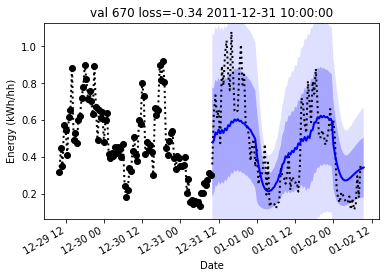

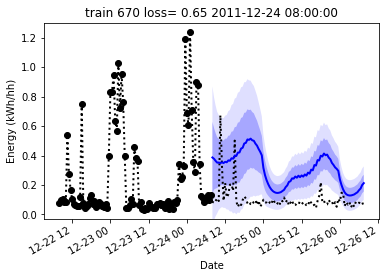

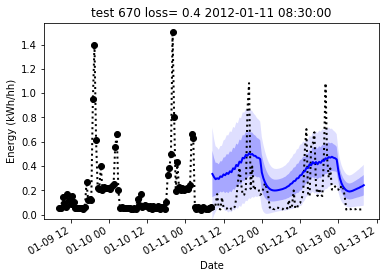

INFO:predict_heading2:step 0, {'agg_test_loss': 2.4327590465545654, 'log': {'agg_test_loss': 2.4327590465545654, 'agg_test_loss_p': 2.4327590465545654, 'agg_test_loss_mse': 0.05163831263780594, 'agg_test_loss_p_weighted': 0.443315714597702, 'agg_test_score': 2.4327590465545654}}
----------------------------------------------------------------------------------------------------
TEST RESULTS
{}
----------------------------------------------------------------------------------------------------



anp-rnn_c_mean  anp-rnn_no_det_mean  anp-rnn_mean  \
agg_test_loss                   0.174443             0.546592      0.519664   
agg_test_loss_p                 0.174309             0.508449      0.512404   
agg_test_loss_kl                0.000134             0.038142      0.007260   
agg_test_loss_mse               0.054350             0.053395      0.046874   
agg_test_loss_p_weighted        0.033049             0.095628      0.102418   
agg_test_score                  0.174309             0.508449      0.512404   
n                               2.000000             2.000000      2.000000   

                          PL_Transformer_mean  \
agg_test_loss                        0.554576   
agg_test_loss_p                      0.554576   
agg_test_loss_kl                          NaN   
agg_test_loss_mse                    0.078667   
agg_test_loss_p_weighted             0.103580   
agg_test_score                       0.554576   
n                                    1.000000   

                          TransformerSeq2Seq_PL_lstm_mean  anp-rnn_d_mean  \
agg_test_loss                                    0.602573        0.616317   
agg_test_loss_p                                  0.602573        0.609149   
agg_test_loss_kl                                      NaN        0.007168   
agg_test_loss_mse                                0.046267        0.046925   
agg_test_loss_p_weighted                         0.114158        0.110414   
agg_test_score                                   0.602573        0.609149   
n                                                2.000000        2.000000   

                          TransformerSeq2Seq_PL_mean  LSTM_PL_STD_mean  \
agg_test_loss                               0.623226          1.042797   
agg_test_loss_p                             0.623226          1.042797   
agg_test_loss_kl                                 NaN               NaN   
agg_test_loss_mse                           0.066200          0.065798   
agg_test_loss_p_weighted                    0.118092          0.191335   
agg_test_score                              0.623226          1.042797   
n                                           2.000000          1.000000   

                          anp-rnn_extras_no_det_mean  anp-rnn_pt_mean  \
agg_test_loss                               1.307930         1.333418   
agg_test_loss_p                             1.238475         1.322273   
agg_test_loss_kl                            0.069454         0.011145   
agg_test_loss_mse                           0.054398         0.045584   
agg_test_loss_p_weighted                    0.237054         0.255269   
agg_test_score                              1.238475         1.322273   
n                                           2.000000         2.000000   

                          anp_c_mean  anp-rnn_extras_mean  \
agg_test_loss               1.456276             1.507506   
agg_test_loss_p             1.448933             1.507384   
agg_test_loss_kl            0.007343             0.000121   
agg_test_loss_mse           0.050474             0.223373   
agg_test_loss_p_weighted    0.277617             0.269838   
agg_test_score              1.448933             1.507384   
n                           1.000000             2.000000   

                          LSTMSeq2Seq_PL_attn_mean   np_mean  \
agg_test_loss                             2.030935  2.718724   
agg_test_loss_p                           2.030935  2.697164   
agg_test_loss_kl                               NaN  0.021561   
agg_test_loss_mse                         0.051643  0.056558   
agg_test_loss_p_weighted                  0.359195  0.488960   
agg_test_score                            2.030935  2.697164   
n                                         2.000000  1.000000   

                          LSTMSeq2Seq_PL_mean  
agg_test_loss                        4.716095  
agg_test_loss_p                      4.716095  
agg_test_loss_kl                          NaN  
agg_test_lo

1 {'name': 'LSTMSeq2Seq_PL', 'PL_MODEL_CLS': <class 'neural_processes.models.lstm_seqseq.LSTMSeq2Seq_PL'>, 'params': {'use_self_attn': False, 'use_cross_attn': False}}
INFO:predict_heading2:now run `tensorboard --logdir lightning_logs`
INFO:root:GPU available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:predict_heading2:trial number=-1100 name=LSTMSeq2Seq_PL, trial=<optuna.trial.FixedTrial object at 0x7f8d71217dd8> params={'learning_rate': 0.001, 'lstm_dropout': 0.22, 'hidden_size_power': 6.0, 'lstm_layers': 3, 'bidirectional': False} attrs={'batch_size': 24, 'grad_clip': 40, 'max_nb_epochs': 20, 'num_workers': 3, 'num_extra_target': 96, 'vis_i': '670', 'num_context': 336, 'input_size': 18, 'input_size_decoder': 17, 'context_in_target': False, 'output_size': 1, 'min_std': 0.005, 'x_dim': 17, 'y_dim': 1, 'patience': 2, 'max_epoch_steps': 19200}
INFO:predict_heading2:Loading checkpoint lightning_logs/LSTMSeq2Seq_PL/version_-1100/_ckpt_epoch_17.ckpt


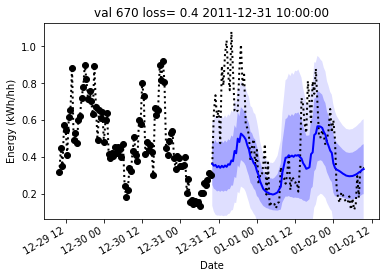

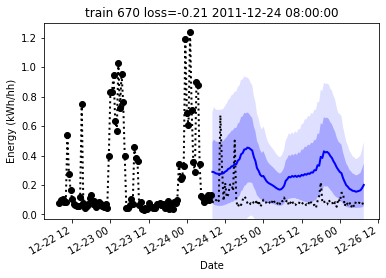

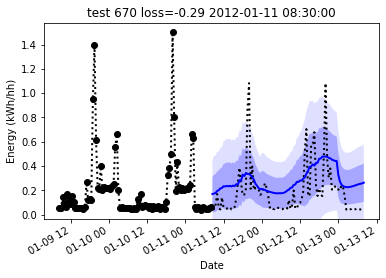

INFO:predict_heading2:step 0, {'agg_test_loss': 0.26290056109428406, 'log': {'agg_test_loss': 0.26290056109428406, 'agg_test_loss_p': 0.26290056109428406, 'agg_test_loss_mse': 0.045787513256073, 'agg_test_loss_p_weighted': 0.04640352353453636, 'agg_test_score': 0.26290056109428406}}
----------------------------------------------------------------------------------------------------
TEST RESULTS
{}
----------------------------------------------------------------------------------------------------



anp-rnn_c_mean  anp-rnn_no_det_mean  anp-rnn_mean  \
agg_test_loss                   0.174443             0.546592      0.519664   
agg_test_loss_p                 0.174309             0.508449      0.512404   
agg_test_loss_kl                0.000134             0.038142      0.007260   
agg_test_loss_mse               0.054350             0.053395      0.046874   
agg_test_loss_p_weighted        0.033049             0.095628      0.102418   
agg_test_score                  0.174309             0.508449      0.512404   
n                               2.000000             2.000000      2.000000   

                          PL_Transformer_mean  \
agg_test_loss                        0.554576   
agg_test_loss_p                      0.554576   
agg_test_loss_kl                          NaN   
agg_test_loss_mse                    0.078667   
agg_test_loss_p_weighted             0.103580   
agg_test_score                       0.554576   
n                                    1.000000   

                          TransformerSeq2Seq_PL_lstm_mean  anp-rnn_d_mean  \
agg_test_loss                                    0.602573        0.616317   
agg_test_loss_p                                  0.602573        0.609149   
agg_test_loss_kl                                      NaN        0.007168   
agg_test_loss_mse                                0.046267        0.046925   
agg_test_loss_p_weighted                         0.114158        0.110414   
agg_test_score                                   0.602573        0.609149   
n                                                2.000000        2.000000   

                          TransformerSeq2Seq_PL_mean  LSTM_PL_STD_mean  \
agg_test_loss                               0.623226          1.042797   
agg_test_loss_p                             0.623226          1.042797   
agg_test_loss_kl                                 NaN               NaN   
agg_test_loss_mse                           0.066200          0.065798   
agg_test_loss_p_weighted                    0.118092          0.191335   
agg_test_score                              0.623226          1.042797   
n                                           2.000000          1.000000   

                          anp-rnn_extras_no_det_mean  anp-rnn_pt_mean  \
agg_test_loss                               1.307930         1.333418   
agg_test_loss_p                             1.238475         1.322273   
agg_test_loss_kl                            0.069454         0.011145   
agg_test_loss_mse                           0.054398         0.045584   
agg_test_loss_p_weighted                    0.237054         0.255269   
agg_test_score                              1.238475         1.322273   
n                                           2.000000         2.000000   

                          anp_c_mean  anp-rnn_extras_mean  \
agg_test_loss               1.456276             1.507506   
agg_test_loss_p             1.448933             1.507384   
agg_test_loss_kl            0.007343             0.000121   
agg_test_loss_mse           0.050474             0.223373   
agg_test_loss_p_weighted    0.277617             0.269838   
agg_test_score              1.448933             1.507384   
n                           1.000000             2.000000   

                          LSTMSeq2Seq_PL_attn_mean  LSTMSeq2Seq_PL_mean  \
agg_test_loss                             2.030935             2.489498   
agg_test_loss_p                           2.030935             2.489498   
agg_test_loss_kl                               NaN                  NaN   
agg_test_loss_mse                         0.051643             0.048283   
agg_test_loss_p_weighted                  0.359195             0.428947   
agg_test_score                            2.030935             2.489498   
n                                         2.000000             2.000000   

                           np_mean  
agg_test_loss             2.718724  
agg_test_loss_p           2.697164  
agg_

1 {'name': 'anp_c', 'PL_MODEL_CLS': <class 'neural_processes.models.neural_process.lightning.PL_ANP'>}
INFO:predict_heading2:now run `tensorboard --logdir lightning_logs`
INFO:root:GPU available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:predict_heading2:trial number=-1100 name=anp_c, trial=<optuna.trial.FixedTrial object at 0x7f8ded8edef0> params={'learning_rate': 0.003, 'num_heads_power': 2, 'hidden_dim_power': 6, 'latent_dim_power': 5, 'n_latent_encoder_layers': 3, 'n_det_encoder_layers': 3, 'n_decoder_layers': 4, 'dropout': 0.1, 'attention_dropout': 0.5, 'batchnorm': False, 'use_deterministic_path': True} attrs={'batch_size': 24, 'grad_clip': 40, 'max_nb_epochs': 20, 'num_workers': 3, 'num_context': 336, 'vis_i': '670', 'num_extra_target': 96, 'x_dim': 17, 'context_in_target': False, 'y_dim': 1, 'patience': 2, 'min_std': 0.005, 'max_epoch_steps': 19200}
INFO:predict_heading2:Loading checkpoint lightning_logs/anp_c/version_-1100/_ckpt_epoch_7.ckpt


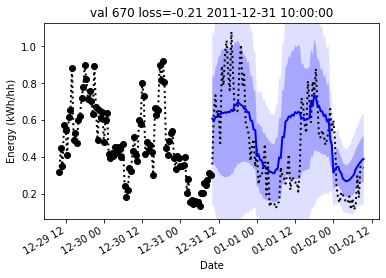

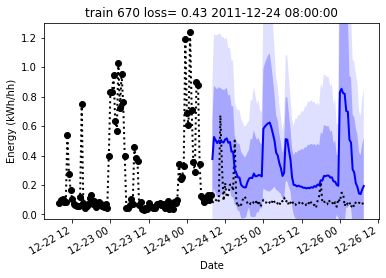

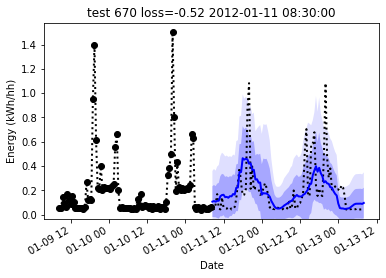

INFO:predict_heading2:step 0, {'agg_test_loss': -0.04990768060088158, 'log': {'agg_test_loss': -0.04243839904665947, 'agg_test_loss_p': -0.04990768060088158, 'agg_test_loss_kl': 0.007469280157238245, 'agg_test_loss_mse': 0.04566358029842377, 'agg_test_loss_p_weighted': -0.006404129788279533, 'agg_test_score': -0.04990768060088158}}
----------------------------------------------------------------------------------------------------
TEST RESULTS
{}
----------------------------------------------------------------------------------------------------



anp-rnn_c_mean  anp-rnn_no_det_mean  anp-rnn_mean  \
agg_test_loss                   0.174443             0.546592      0.519664   
agg_test_loss_p                 0.174309             0.508449      0.512404   
agg_test_loss_kl                0.000134             0.038142      0.007260   
agg_test_loss_mse               0.054350             0.053395      0.046874   
agg_test_loss_p_weighted        0.033049             0.095628      0.102418   
agg_test_score                  0.174309             0.508449      0.512404   
n                               2.000000             2.000000      2.000000   

                          PL_Transformer_mean  \
agg_test_loss                        0.554576   
agg_test_loss_p                      0.554576   
agg_test_loss_kl                          NaN   
agg_test_loss_mse                    0.078667   
agg_test_loss_p_weighted             0.103580   
agg_test_score                       0.554576   
n                                    1.000000   

                          TransformerSeq2Seq_PL_lstm_mean  anp-rnn_d_mean  \
agg_test_loss                                    0.602573        0.616317   
agg_test_loss_p                                  0.602573        0.609149   
agg_test_loss_kl                                      NaN        0.007168   
agg_test_loss_mse                                0.046267        0.046925   
agg_test_loss_p_weighted                         0.114158        0.110414   
agg_test_score                                   0.602573        0.609149   
n                                                2.000000        2.000000   

                          TransformerSeq2Seq_PL_mean  anp_c_mean  \
agg_test_loss                               0.623226    0.706919   
agg_test_loss_p                             0.623226    0.699513   
agg_test_loss_kl                                 NaN    0.007406   
agg_test_loss_mse                           0.066200    0.048069   
agg_test_loss_p_weighted                    0.118092    0.135607   
agg_test_score                              0.623226    0.699513   
n                                           2.000000    2.000000   

                          LSTM_PL_STD_mean  anp-rnn_extras_no_det_mean  \
agg_test_loss                     1.042797                    1.307930   
agg_test_loss_p                   1.042797                    1.238475   
agg_test_loss_kl                       NaN                    0.069454   
agg_test_loss_mse                 0.065798                    0.054398   
agg_test_loss_p_weighted          0.191335                    0.237054   
agg_test_score                    1.042797                    1.238475   
n                                 1.000000                    2.000000   

                          anp-rnn_pt_mean  anp-rnn_extras_mean  \
agg_test_loss                    1.333418             1.507506   
agg_test_loss_p                  1.322273             1.507384   
agg_test_loss_kl                 0.011145             0.000121   
agg_test_loss_mse                0.045584             0.223373   
agg_test_loss_p_weighted         0.255269             0.269838   
agg_test_score                   1.322273             1.507384   
n                                2.000000             2.000000   

                          LSTMSeq2Seq_PL_attn_mean  LSTMSeq2Seq_PL_mean  \
agg_test_loss                             2.030935             2.489498   
agg_test_loss_p                           2.030935             2.489498   
agg_test_loss_kl                               NaN                  NaN   
agg_test_loss_mse                         0.051643             0.048283   
agg_test_loss_p_weighted                  0.359195             0.428947   
agg_test_score                            2.030935             2.489498   
n                                         2.000000             2.000000   

                           np_mean  
agg_test_loss             2.718724  
agg_test_loss_p           2.697164  
agg_

1 {'name': 'np', 'PL_MODEL_CLS': <class 'neural_processes.models.neural_process.lightning.PL_NP'>}
INFO:predict_heading2:now run `tensorboard --logdir lightning_logs`
INFO:root:GPU available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:predict_heading2:trial number=-1100 name=np, trial=<optuna.trial.FixedTrial object at 0x7f8d6d091a90> params={'learning_rate': 0.003, 'hidden_dim_power': 6, 'latent_dim_power': 5, 'n_latent_encoder_layers': 3, 'n_decoder_layers': 4, 'dropout': 0.1, 'batchnorm': False} attrs={'batch_size': 24, 'grad_clip': 40, 'max_nb_epochs': 20, 'num_workers': 3, 'num_context': 336, 'vis_i': '670', 'num_extra_target': 96, 'x_dim': 17, 'context_in_target': False, 'y_dim': 1, 'patience': 2, 'min_std': 0.005, 'max_epoch_steps': 19200}
INFO:predict_heading2:Loading checkpoint lightning_logs/np/version_-1100/_ckpt_epoch_6.ckpt


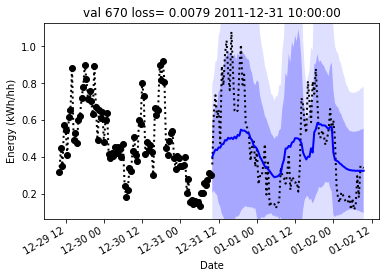

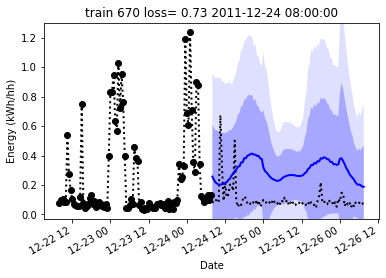

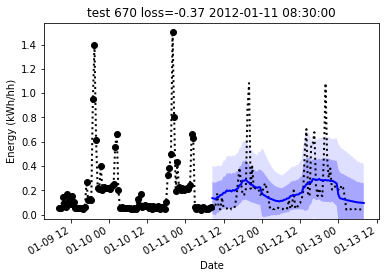

INFO:predict_heading2:step 0, {'agg_test_loss': -0.10211655497550964, 'log': {'agg_test_loss': -0.06452342122793198, 'agg_test_loss_p': -0.10211655497550964, 'agg_test_loss_kl': 0.03759314492344856, 'agg_test_loss_mse': 0.043197765946388245, 'agg_test_loss_p_weighted': -0.018044210970401764, 'agg_test_score': -0.10211655497550964}}
----------------------------------------------------------------------------------------------------
TEST RESULTS
{}
----------------------------------------------------------------------------------------------------



anp-rnn_c_mean  anp-rnn_no_det_mean  anp-rnn_mean  \
agg_test_loss                   0.174443             0.546592      0.519664   
agg_test_loss_p                 0.174309             0.508449      0.512404   
agg_test_loss_kl                0.000134             0.038142      0.007260   
agg_test_loss_mse               0.054350             0.053395      0.046874   
agg_test_loss_p_weighted        0.033049             0.095628      0.102418   
agg_test_score                  0.174309             0.508449      0.512404   
n                               2.000000             2.000000      2.000000   

                          PL_Transformer_mean  \
agg_test_loss                        0.554576   
agg_test_loss_p                      0.554576   
agg_test_loss_kl                          NaN   
agg_test_loss_mse                    0.078667   
agg_test_loss_p_weighted             0.103580   
agg_test_score                       0.554576   
n                                    1.000000   

                          TransformerSeq2Seq_PL_lstm_mean  anp-rnn_d_mean  \
agg_test_loss                                    0.602573        0.616317   
agg_test_loss_p                                  0.602573        0.609149   
agg_test_loss_kl                                      NaN        0.007168   
agg_test_loss_mse                                0.046267        0.046925   
agg_test_loss_p_weighted                         0.114158        0.110414   
agg_test_score                                   0.602573        0.609149   
n                                                2.000000        2.000000   

                          TransformerSeq2Seq_PL_mean  anp_c_mean  \
agg_test_loss                               0.623226    0.706919   
agg_test_loss_p                             0.623226    0.699513   
agg_test_loss_kl                                 NaN    0.007406   
agg_test_loss_mse                           0.066200    0.048069   
agg_test_loss_p_weighted                    0.118092    0.135607   
agg_test_score                              0.623226    0.699513   
n                                           2.000000    2.000000   

                          LSTM_PL_STD_mean  anp-rnn_extras_no_det_mean  \
agg_test_loss                     1.042797                    1.307930   
agg_test_loss_p                   1.042797                    1.238475   
agg_test_loss_kl                       NaN                    0.069454   
agg_test_loss_mse                 0.065798                    0.054398   
agg_test_loss_p_weighted          0.191335                    0.237054   
agg_test_score                    1.042797                    1.238475   
n                                 1.000000                    2.000000   

                           np_mean  anp-rnn_pt_mean  anp-rnn_extras_mean  \
agg_test_loss             1.327100         1.333418             1.507506   
agg_test_loss_p           1.297524         1.322273             1.507384   
agg_test_loss_kl          0.029577         0.011145             0.000121   
agg_test_loss_mse         0.049878         0.045584             0.223373   
agg_test_loss_p_weighted  0.235458         0.255269             0.269838   
agg_test_score            1.297524         1.322273             1.507384   
n                         2.000000         2.000000             2.000000   

                          LSTMSeq2Seq_PL_attn_mean  LSTMSeq2Seq_PL_mean  
agg_test_loss                             2.030935             2.489498  
agg_test_loss_p                           2.030935             2.489498  
agg_test_loss_kl                               NaN                  NaN  
agg_test_loss_mse                         0.051643             0.048283  
agg_test_loss_p_weighted                  0.359195             0.428947  
agg_test_score                            2.030935             2.489498  
n                                         2.000000             2.000000

1 {'name': 'PL_Transformer', 'PL_MODEL_CLS': <class 'neural_processes.models.transformer.PL_Transformer'>}
INFO:predict_heading2:now run `tensorboard --logdir lightning_logs`
INFO:root:GPU available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:predict_heading2:trial number=-1100 name=PL_Transformer, trial=<optuna.trial.FixedTrial object at 0x7f8deda48c18> params={'learning_rate': 0.003, 'attention_dropout': 0.4, 'hidden_size_power': 7.0, 'hidden_out_size_power': 7.0, 'nhead_power': 1.0, 'nlayers': 2} attrs={'batch_size': 24, 'grad_clip': 40, 'max_nb_epochs': 20, 'num_workers': 3, 'vis_i': '670', 'x_dim': 17, 'y_dim': 1, 'context_in_target': False, 'patience': 2, 'min_std': 0.005, 'nan_value': -99.9, 'num_context': 336, 'num_extra_target': 96, 'max_epoch_steps': 19200}
INFO:predict_heading2:Loading checkpoint lightning_logs/PL_Transformer/version_-1100/_ckpt_epoch_4.ckpt


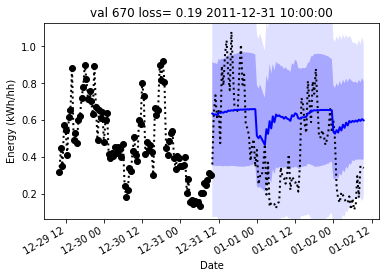

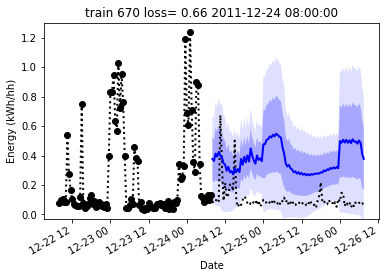

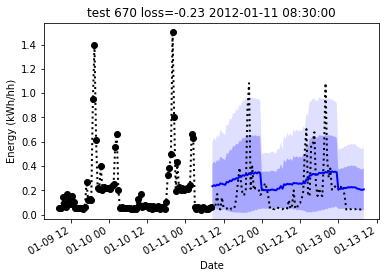

INFO:predict_heading2:step 0, {'agg_test_loss': 2.5386836528778076, 'log': {'agg_test_loss': 2.5386836528778076, 'agg_test_loss_p': 2.5386836528778076, 'agg_test_loss_mse': 0.053723253309726715, 'agg_test_loss_p_weighted': 0.48533499240875244, 'agg_test_score': 2.5386836528778076}}
----------------------------------------------------------------------------------------------------
TEST RESULTS
{}
----------------------------------------------------------------------------------------------------



anp-rnn_c_mean  anp-rnn_no_det_mean  anp-rnn_mean  \
agg_test_loss                   0.174443             0.546592      0.519664   
agg_test_loss_p                 0.174309             0.508449      0.512404   
agg_test_loss_kl                0.000134             0.038142      0.007260   
agg_test_loss_mse               0.054350             0.053395      0.046874   
agg_test_loss_p_weighted        0.033049             0.095628      0.102418   
agg_test_score                  0.174309             0.508449      0.512404   
n                               2.000000             2.000000      2.000000   

                          TransformerSeq2Seq_PL_lstm_mean  anp-rnn_d_mean  \
agg_test_loss                                    0.602573        0.616317   
agg_test_loss_p                                  0.602573        0.609149   
agg_test_loss_kl                                      NaN        0.007168   
agg_test_loss_mse                                0.046267        0.046925   
agg_test_loss_p_weighted                         0.114158        0.110414   
agg_test_score                                   0.602573        0.609149   
n                                                2.000000        2.000000   

                          TransformerSeq2Seq_PL_mean  anp_c_mean  \
agg_test_loss                               0.623226    0.706919   
agg_test_loss_p                             0.623226    0.699513   
agg_test_loss_kl                                 NaN    0.007406   
agg_test_loss_mse                           0.066200    0.048069   
agg_test_loss_p_weighted                    0.118092    0.135607   
agg_test_score                              0.623226    0.699513   
n                                           2.000000    2.000000   

                          LSTM_PL_STD_mean  anp-rnn_extras_no_det_mean  \
agg_test_loss                     1.042797                    1.307930   
agg_test_loss_p                   1.042797                    1.238475   
agg_test_loss_kl                       NaN                    0.069454   
agg_test_loss_mse                 0.065798                    0.054398   
agg_test_loss_p_weighted          0.191335                    0.237054   
agg_test_score                    1.042797                    1.238475   
n                                 1.000000                    2.000000   

                           np_mean  anp-rnn_pt_mean  anp-rnn_extras_mean  \
agg_test_loss             1.327100         1.333418             1.507506   
agg_test_loss_p           1.297524         1.322273             1.507384   
agg_test_loss_kl          0.029577         0.011145             0.000121   
agg_test_loss_mse         0.049878         0.045584             0.223373   
agg_test_loss_p_weighted  0.235458         0.255269             0.269838   
agg_test_score            1.297524         1.322273             1.507384   
n                         2.000000         2.000000             2.000000   

                          PL_Transformer_mean  LSTMSeq2Seq_PL_attn_mean  \
agg_test_loss                        1.546630                  2.030935   
agg_test_loss_p                      1.546630                  2.030935   
agg_test_loss_kl                          NaN                       NaN   
agg_test_loss_mse                    0.066195                  0.051643   
agg_test_loss_p_weighted             0.294457                  0.359195   
agg_test_score                       1.546630                  2.030935   
n                                    2.000000                  2.000000   

                          LSTMSeq2Seq_PL_mean  
agg_test_loss                        2.489498  
agg_test_loss_p                      2.489498  
agg_test_loss_kl                          NaN  
agg_test_loss_mse                    0.048283  
agg_test_loss_p_weighted             0.428947  
agg_test_score                       2.489498  
n                                    2.000000

1 {'name': 'LSTM_PL_STD', 'PL_MODEL_CLS': <class 'neural_processes.models.lstm_std.LSTM_PL_STD'>}
INFO:predict_heading2:now run `tensorboard --logdir lightning_logs`
INFO:root:GPU available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:predict_heading2:trial number=-1100 name=LSTM_PL_STD, trial=<optuna.trial.FixedTrial object at 0x7f8d6cfa7748> params={'learning_rate': 0.001, 'lstm_dropout': 0.39, 'hidden_size_power': 5, 'lstm_layers': 4, 'bidirectional': False} attrs={'batch_size': 24, 'grad_clip': 40, 'max_nb_epochs': 20, 'num_workers': 3, 'vis_i': '670', 'x_dim': 17, 'y_dim': 1, 'context_in_target': False, 'patience': 2, 'min_std': 0.005, 'nan_value': -99.9, 'num_context': 336, 'num_extra_target': 96, 'max_epoch_steps': 19200}
INFO:predict_heading2:Loading checkpoint lightning_logs/LSTM_PL_STD/version_-1100/_ckpt_epoch_6.ckpt


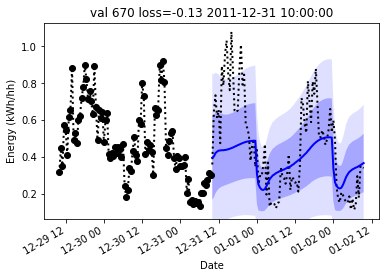

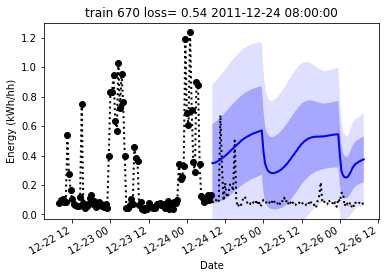

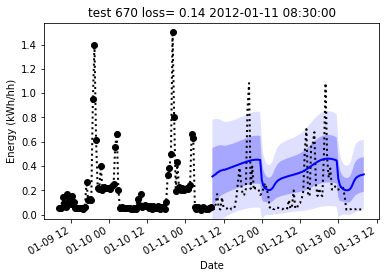

INFO:predict_heading2:step 0, {'agg_test_loss': 0.666202962398529, 'log': {'agg_test_loss': 0.666202962398529, 'agg_test_loss_p_weighted': 0.1102524846792221, 'agg_test_loss_p': 0.666202962398529, 'agg_test_loss_mse': 0.0700908675789833, 'agg_test_score': 0.666202962398529}}
----------------------------------------------------------------------------------------------------
TEST RESULTS
{}
----------------------------------------------------------------------------------------------------



anp-rnn_c_mean  anp-rnn_no_det_mean  anp-rnn_mean  \
agg_test_loss                   0.174443             0.546592      0.519664   
agg_test_loss_p                 0.174309             0.508449      0.512404   
agg_test_loss_kl                0.000134             0.038142      0.007260   
agg_test_loss_mse               0.054350             0.053395      0.046874   
agg_test_loss_p_weighted        0.033049             0.095628      0.102418   
agg_test_score                  0.174309             0.508449      0.512404   
n                               2.000000             2.000000      2.000000   

                          TransformerSeq2Seq_PL_lstm_mean  anp-rnn_d_mean  \
agg_test_loss                                    0.602573        0.616317   
agg_test_loss_p                                  0.602573        0.609149   
agg_test_loss_kl                                      NaN        0.007168   
agg_test_loss_mse                                0.046267        0.046925   
agg_test_loss_p_weighted                         0.114158        0.110414   
agg_test_score                                   0.602573        0.609149   
n                                                2.000000        2.000000   

                          TransformerSeq2Seq_PL_mean  anp_c_mean  \
agg_test_loss                               0.623226    0.706919   
agg_test_loss_p                             0.623226    0.699513   
agg_test_loss_kl                                 NaN    0.007406   
agg_test_loss_mse                           0.066200    0.048069   
agg_test_loss_p_weighted                    0.118092    0.135607   
agg_test_score                              0.623226    0.699513   
n                                           2.000000    2.000000   

                          LSTM_PL_STD_mean  anp-rnn_extras_no_det_mean  \
agg_test_loss                     0.854500                    1.307930   
agg_test_loss_p                   0.854500                    1.238475   
agg_test_loss_kl                       NaN                    0.069454   
agg_test_loss_mse                 0.067944                    0.054398   
agg_test_loss_p_weighted          0.150794                    0.237054   
agg_test_score                    0.854500                    1.238475   
n                                 2.000000                    2.000000   

                           np_mean  anp-rnn_pt_mean  anp-rnn_extras_mean  \
agg_test_loss             1.327100         1.333418             1.507506   
agg_test_loss_p           1.297524         1.322273             1.507384   
agg_test_loss_kl          0.029577         0.011145             0.000121   
agg_test_loss_mse         0.049878         0.045584             0.223373   
agg_test_loss_p_weighted  0.235458         0.255269             0.269838   
agg_test_score            1.297524         1.322273             1.507384   
n                         2.000000         2.000000             2.000000   

                          PL_Transformer_mean  LSTMSeq2Seq_PL_attn_mean  \
agg_test_loss                        1.546630                  2.030935   
agg_test_loss_p                      1.546630                  2.030935   
agg_test_loss_kl                          NaN                       NaN   
agg_test_loss_mse                    0.066195                  0.051643   
agg_test_loss_p_weighted             0.294457                  0.359195   
agg_test_score                       1.546630                  2.030935   
n                                    2.000000                  2.000000   

                          LSTMSeq2Seq_PL_mean  
agg_test_loss                        2.489498  
agg_test_loss_p                      2.489498  
agg_test_loss_kl                          NaN  
agg_test_loss_mse                    0.048283  
agg_test_loss_p_weighted             0.428947  
agg_test_score                       2.489498  
n                                    2.000000

2 {'name': 'anp-rnn', 'params': {'det_enc_cross_attn_type': 'multihead', 'det_enc_self_attn_type': 'multihead', 'latent_enc_self_attn_type': 'multihead', 'use_deterministic_path': True}, 'PL_MODEL_CLS': <class 'neural_processes.models.neural_process.lightning.PL_ANPRNN'>}
INFO:predict_heading2:now run `tensorboard --logdir lightning_logs`
INFO:root:GPU available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:predict_heading2:trial number=-1200 name=anp-rnn, trial=<optuna.trial.FixedTrial object at 0x7f8d6cf8b2b0> params={'learning_rate': 0.003, 'num_heads_power': 2, 'hidden_dim_power': 6, 'latent_dim_power': 5, 'n_latent_encoder_layers': 3, 'n_det_encoder_layers': 3, 'n_decoder_layers': 4, 'dropout': 0.1, 'attention_dropout': 0.5, 'batchnorm': False, 'use_deterministic_path': True} attrs={'batch_size': 24, 'grad_clip': 40, 'max_nb_epochs': 20, 'num_workers': 3, 'num_context': 336, 'vis_i': '670', 'num_extra_target': 96, 'x_dim': 17, 'context_in_target': False, 'y_dim': 1, 'patience':

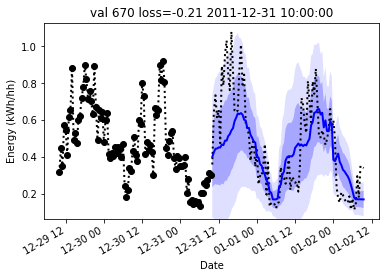

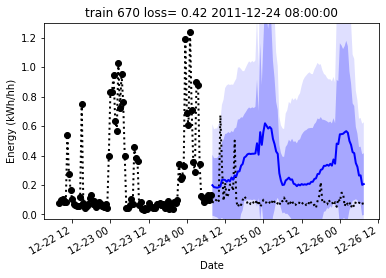

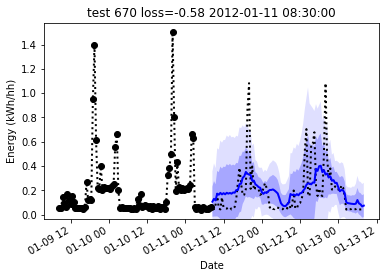

INFO:predict_heading2:step 0, {'agg_test_loss': -0.09835882484912872, 'log': {'agg_test_loss': -0.08576830476522446, 'agg_test_loss_p': -0.09835882484912872, 'agg_test_loss_kl': 0.012590534053742886, 'agg_test_loss_mse': 0.04031004011631012, 'agg_test_loss_p_weighted': -0.023358099162578583, 'agg_test_score': -0.09835882484912872}}
----------------------------------------------------------------------------------------------------
TEST RESULTS
{}
----------------------------------------------------------------------------------------------------



anp-rnn_c_mean  anp-rnn_mean  anp-rnn_no_det_mean  \
agg_test_loss                   0.174443      0.317853             0.546592   
agg_test_loss_p                 0.174309      0.308816             0.508449   
agg_test_loss_kl                0.000134      0.009037             0.038142   
agg_test_loss_mse               0.054350      0.044686             0.053395   
agg_test_loss_p_weighted        0.033049      0.060492             0.095628   
agg_test_score                  0.174309      0.308816             0.508449   
n                               2.000000      3.000000             2.000000   

                          TransformerSeq2Seq_PL_lstm_mean  anp-rnn_d_mean  \
agg_test_loss                                    0.602573        0.616317   
agg_test_loss_p                                  0.602573        0.609149   
agg_test_loss_kl                                      NaN        0.007168   
agg_test_loss_mse                                0.046267        0.046925   
agg_test_loss_p_weighted                         0.114158        0.110414   
agg_test_score                                   0.602573        0.609149   
n                                                2.000000        2.000000   

                          TransformerSeq2Seq_PL_mean  anp_c_mean  \
agg_test_loss                               0.623226    0.706919   
agg_test_loss_p                             0.623226    0.699513   
agg_test_loss_kl                                 NaN    0.007406   
agg_test_loss_mse                           0.066200    0.048069   
agg_test_loss_p_weighted                    0.118092    0.135607   
agg_test_score                              0.623226    0.699513   
n                                           2.000000    2.000000   

                          LSTM_PL_STD_mean  anp-rnn_extras_no_det_mean  \
agg_test_loss                     0.854500                    1.307930   
agg_test_loss_p                   0.854500                    1.238475   
agg_test_loss_kl                       NaN                    0.069454   
agg_test_loss_mse                 0.067944                    0.054398   
agg_test_loss_p_weighted          0.150794                    0.237054   
agg_test_score                    0.854500                    1.238475   
n                                 2.000000                    2.000000   

                           np_mean  anp-rnn_pt_mean  anp-rnn_extras_mean  \
agg_test_loss             1.327100         1.333418             1.507506   
agg_test_loss_p           1.297524         1.322273             1.507384   
agg_test_loss_kl          0.029577         0.011145             0.000121   
agg_test_loss_mse         0.049878         0.045584             0.223373   
agg_test_loss_p_weighted  0.235458         0.255269             0.269838   
agg_test_score            1.297524         1.322273             1.507384   
n                         2.000000         2.000000             2.000000   

                          PL_Transformer_mean  LSTMSeq2Seq_PL_attn_mean  \
agg_test_loss                        1.546630                  2.030935   
agg_test_loss_p                      1.546630                  2.030935   
agg_test_loss_kl                          NaN                       NaN   
agg_test_loss_mse                    0.066195                  0.051643   
agg_test_loss_p_weighted             0.294457                  0.359195   
agg_test_score                       1.546630                  2.030935   
n                                    2.000000                  2.000000   

                          LSTMSeq2Seq_PL_mean  
agg_test_loss                        2.489498  
agg_test_loss_p                      2.489498  
agg_test_loss_kl                          NaN  
agg_test_loss_mse                    0.048283  
agg_test_loss_p_weighted             0.428947  
agg_test_score                       2.489498  
n                                    2.000000

2 {'name': 'anp-rnn_pt', 'params': {'det_enc_cross_attn_type': 'ptmultihead', 'det_enc_self_attn_type': 'ptmultihead', 'latent_enc_self_attn_type': 'ptmultihead', 'use_deterministic_path': True}, 'PL_MODEL_CLS': <class 'neural_processes.models.neural_process.lightning.PL_ANPRNN'>}
INFO:predict_heading2:now run `tensorboard --logdir lightning_logs`
INFO:root:GPU available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:predict_heading2:trial number=-1200 name=anp-rnn_pt, trial=<optuna.trial.FixedTrial object at 0x7f8d6e553e10> params={'learning_rate': 0.003, 'num_heads_power': 2, 'hidden_dim_power': 6, 'latent_dim_power': 5, 'n_latent_encoder_layers': 3, 'n_det_encoder_layers': 3, 'n_decoder_layers': 4, 'dropout': 0.1, 'attention_dropout': 0.5, 'batchnorm': False, 'use_deterministic_path': True} attrs={'batch_size': 24, 'grad_clip': 40, 'max_nb_epochs': 20, 'num_workers': 3, 'num_context': 336, 'vis_i': '670', 'num_extra_target': 96, 'x_dim': 17, 'context_in_target': False, 'y_dim': 1,

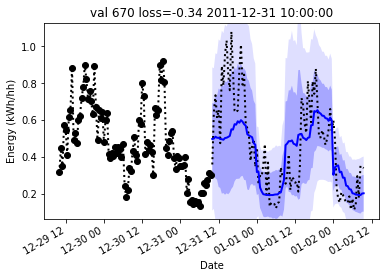

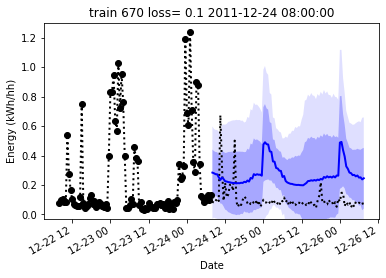

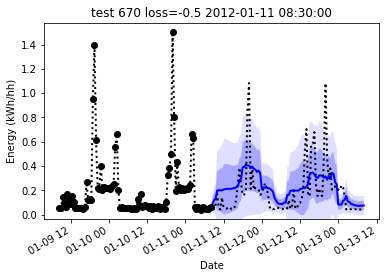

INFO:predict_heading2:step 0, {'agg_test_loss': 0.7839328050613403, 'log': {'agg_test_loss': 0.8056936860084534, 'agg_test_loss_p': 0.7839328050613403, 'agg_test_loss_kl': 0.021760892122983932, 'agg_test_loss_mse': 0.04468793049454689, 'agg_test_loss_p_weighted': 0.13307008147239685, 'agg_test_score': 0.7839328050613403}}
----------------------------------------------------------------------------------------------------
TEST RESULTS
{}
----------------------------------------------------------------------------------------------------



anp-rnn_c_mean  anp-rnn_mean  anp-rnn_no_det_mean  \
agg_test_loss                   0.174443      0.317853             0.546592   
agg_test_loss_p                 0.174309      0.308816             0.508449   
agg_test_loss_kl                0.000134      0.009037             0.038142   
agg_test_loss_mse               0.054350      0.044686             0.053395   
agg_test_loss_p_weighted        0.033049      0.060492             0.095628   
agg_test_score                  0.174309      0.308816             0.508449   
n                               2.000000      3.000000             2.000000   

                          TransformerSeq2Seq_PL_lstm_mean  anp-rnn_d_mean  \
agg_test_loss                                    0.602573        0.616317   
agg_test_loss_p                                  0.602573        0.609149   
agg_test_loss_kl                                      NaN        0.007168   
agg_test_loss_mse                                0.046267        0.046925   
agg_test_loss_p_weighted                         0.114158        0.110414   
agg_test_score                                   0.602573        0.609149   
n                                                2.000000        2.000000   

                          TransformerSeq2Seq_PL_mean  anp_c_mean  \
agg_test_loss                               0.623226    0.706919   
agg_test_loss_p                             0.623226    0.699513   
agg_test_loss_kl                                 NaN    0.007406   
agg_test_loss_mse                           0.066200    0.048069   
agg_test_loss_p_weighted                    0.118092    0.135607   
agg_test_score                              0.623226    0.699513   
n                                           2.000000    2.000000   

                          LSTM_PL_STD_mean  anp-rnn_pt_mean  \
agg_test_loss                     0.854500         1.157510   
agg_test_loss_p                   0.854500         1.142826   
agg_test_loss_kl                       NaN         0.014684   
agg_test_loss_mse                 0.067944         0.045285   
agg_test_loss_p_weighted          0.150794         0.214536   
agg_test_score                    0.854500         1.142826   
n                                 2.000000         3.000000   

                          anp-rnn_extras_no_det_mean   np_mean  \
agg_test_loss                               1.307930  1.327100   
agg_test_loss_p                             1.238475  1.297524   
agg_test_loss_kl                            0.069454  0.029577   
agg_test_loss_mse                           0.054398  0.049878   
agg_test_loss_p_weighted                    0.237054  0.235458   
agg_test_score                              1.238475  1.297524   
n                                           2.000000  2.000000   

                          anp-rnn_extras_mean  PL_Transformer_mean  \
agg_test_loss                        1.507506             1.546630   
agg_test_loss_p                      1.507384             1.546630   
agg_test_loss_kl                     0.000121                  NaN   
agg_test_loss_mse                    0.223373             0.066195   
agg_test_loss_p_weighted             0.269838             0.294457   
agg_test_score                       1.507384             1.546630   
n                                    2.000000             2.000000   

                          LSTMSeq2Seq_PL_attn_mean  LSTMSeq2Seq_PL_mean  
agg_test_loss                             2.030935             2.489498  
agg_test_loss_p                           2.030935             2.489498  
agg_test_loss_kl                               NaN                  NaN  
agg_test_loss_mse                         0.051643             0.048283  
agg_test_loss_p_weighted                  0.359195             0.428947  
agg_test_score                            2.030935             2.489498  
n                                         2.000000             2.000000

2 {'name': 'anp-rnn_c', 'params': {'det_enc_cross_attn_type': 'ptmultihead', 'det_enc_self_attn_type': 'ptmultihead', 'latent_enc_self_attn_type': 'ptmultihead', 'use_deterministic_path': True, 'batchnorm': False, 'attention_dropout': 0.5, 'dropout': 0.5, 'hidden_dim_power': 5.0, 'latent_dim_power': 8.0, 'learning_rate': 0.001, 'n_decoder_layers': 4, 'n_det_encoder_layers': 1, 'n_latent_encoder_layers': 4, 'num_heads_power': 3.0}, 'PL_MODEL_CLS': <class 'neural_processes.models.neural_process.lightning.PL_ANPRNN'>}
INFO:predict_heading2:now run `tensorboard --logdir lightning_logs`
INFO:root:GPU available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:predict_heading2:trial number=-1200 name=anp-rnn_c, trial=<optuna.trial.FixedTrial object at 0x7f8deda48e48> params={'learning_rate': 0.001, 'num_heads_power': 3.0, 'hidden_dim_power': 5.0, 'latent_dim_power': 8.0, 'n_latent_encoder_layers': 4, 'n_det_encoder_layers': 1, 'n_decoder_layers': 4, 'dropout': 0.5, 'attention_dropout': 0.5, '

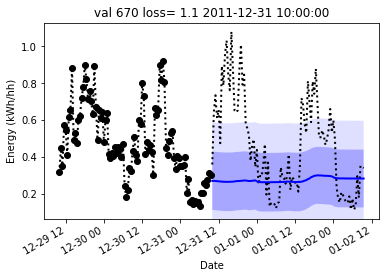

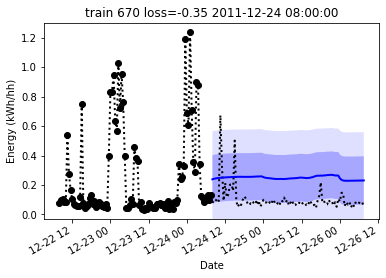

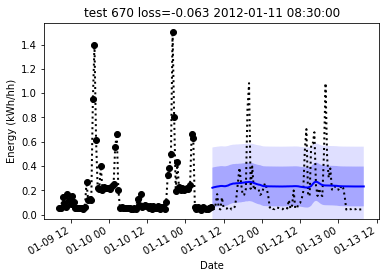

INFO:predict_heading2:step 0, {'agg_test_loss': 0.06142241507768631, 'log': {'agg_test_loss': 0.061430737376213074, 'agg_test_loss_p': 0.06142241507768631, 'agg_test_loss_kl': 8.320772394654341e-06, 'agg_test_loss_mse': 0.05060550570487976, 'agg_test_loss_p_weighted': 0.011549878865480423, 'agg_test_score': 0.06142241507768631}}
----------------------------------------------------------------------------------------------------
TEST RESULTS
{}
----------------------------------------------------------------------------------------------------



anp-rnn_c_mean  anp-rnn_mean  anp-rnn_no_det_mean  \
agg_test_loss                   0.136772      0.317853             0.546592   
agg_test_loss_p                 0.136680      0.308816             0.508449   
agg_test_loss_kl                0.000092      0.009037             0.038142   
agg_test_loss_mse               0.053102      0.044686             0.053395   
agg_test_loss_p_weighted        0.025883      0.060492             0.095628   
agg_test_score                  0.136680      0.308816             0.508449   
n                               3.000000      3.000000             2.000000   

                          TransformerSeq2Seq_PL_lstm_mean  anp-rnn_d_mean  \
agg_test_loss                                    0.602573        0.616317   
agg_test_loss_p                                  0.602573        0.609149   
agg_test_loss_kl                                      NaN        0.007168   
agg_test_loss_mse                                0.046267        0.046925   
agg_test_loss_p_weighted                         0.114158        0.110414   
agg_test_score                                   0.602573        0.609149   
n                                                2.000000        2.000000   

                          TransformerSeq2Seq_PL_mean  anp_c_mean  \
agg_test_loss                               0.623226    0.706919   
agg_test_loss_p                             0.623226    0.699513   
agg_test_loss_kl                                 NaN    0.007406   
agg_test_loss_mse                           0.066200    0.048069   
agg_test_loss_p_weighted                    0.118092    0.135607   
agg_test_score                              0.623226    0.699513   
n                                           2.000000    2.000000   

                          LSTM_PL_STD_mean  anp-rnn_pt_mean  \
agg_test_loss                     0.854500         1.157510   
agg_test_loss_p                   0.854500         1.142826   
agg_test_loss_kl                       NaN         0.014684   
agg_test_loss_mse                 0.067944         0.045285   
agg_test_loss_p_weighted          0.150794         0.214536   
agg_test_score                    0.854500         1.142826   
n                                 2.000000         3.000000   

                          anp-rnn_extras_no_det_mean   np_mean  \
agg_test_loss                               1.307930  1.327100   
agg_test_loss_p                             1.238475  1.297524   
agg_test_loss_kl                            0.069454  0.029577   
agg_test_loss_mse                           0.054398  0.049878   
agg_test_loss_p_weighted                    0.237054  0.235458   
agg_test_score                              1.238475  1.297524   
n                                           2.000000  2.000000   

                          anp-rnn_extras_mean  PL_Transformer_mean  \
agg_test_loss                        1.507506             1.546630   
agg_test_loss_p                      1.507384             1.546630   
agg_test_loss_kl                     0.000121                  NaN   
agg_test_loss_mse                    0.223373             0.066195   
agg_test_loss_p_weighted             0.269838             0.294457   
agg_test_score                       1.507384             1.546630   
n                                    2.000000             2.000000   

                          LSTMSeq2Seq_PL_attn_mean  LSTMSeq2Seq_PL_mean  
agg_test_loss                             2.030935             2.489498  
agg_test_loss_p                           2.030935             2.489498  
agg_test_loss_kl                               NaN                  NaN  
agg_test_loss_mse                         0.051643             0.048283  
agg_test_loss_p_weighted                  0.359195             0.428947  
agg_test_score                            2.030935             2.489498  
n                                         2.000000             2.000000

2 {'name': 'anp-rnn_d', 'params': {'det_enc_cross_attn_type': 'ptmultihead', 'det_enc_self_attn_type': 'ptmultihead', 'latent_enc_self_attn_type': 'ptmultihead', 'use_deterministic_path': True, 'batchnorm': False, 'attention_dropout': 0.7, 'dropout': 0.1, 'hidden_dim_power': 6.0, 'latent_dim_power': 6.0, 'learning_rate': 0.001, 'n_decoder_layers': 4, 'n_det_encoder_layers': 3, 'n_latent_encoder_layers': 4, 'num_heads_power': 2.0}, 'PL_MODEL_CLS': <class 'neural_processes.models.neural_process.lightning.PL_ANPRNN'>}
INFO:predict_heading2:now run `tensorboard --logdir lightning_logs`
INFO:root:GPU available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:predict_heading2:trial number=-1200 name=anp-rnn_d, trial=<optuna.trial.FixedTrial object at 0x7f8ded906828> params={'learning_rate': 0.001, 'num_heads_power': 2.0, 'hidden_dim_power': 6.0, 'latent_dim_power': 6.0, 'n_latent_encoder_layers': 4, 'n_det_encoder_layers': 3, 'n_decoder_layers': 4, 'dropout': 0.1, 'attention_dropout': 0.7, '

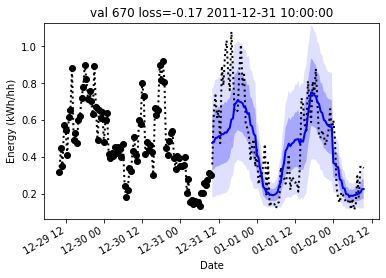

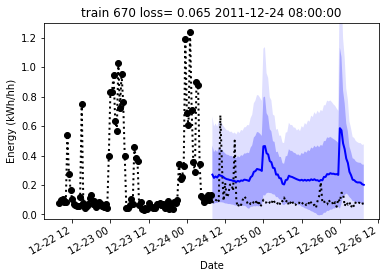

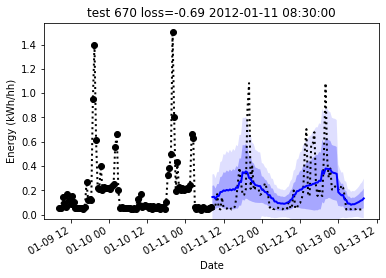

INFO:predict_heading2:step 0, {'agg_test_loss': -0.056739699095487595, 'log': {'agg_test_loss': -0.05025927349925041, 'agg_test_loss_p': -0.056739699095487595, 'agg_test_loss_kl': 0.006480430252850056, 'agg_test_loss_mse': 0.0416790172457695, 'agg_test_loss_p_weighted': -0.012132854200899601, 'agg_test_score': -0.056739699095487595}}
----------------------------------------------------------------------------------------------------
TEST RESULTS
{}
----------------------------------------------------------------------------------------------------



anp-rnn_c_mean  anp-rnn_mean  anp-rnn_d_mean  \
agg_test_loss                   0.136772      0.317853        0.394125   
agg_test_loss_p                 0.136680      0.308816        0.387186   
agg_test_loss_kl                0.000092      0.009037        0.006939   
agg_test_loss_mse               0.053102      0.044686        0.045177   
agg_test_loss_p_weighted        0.025883      0.060492        0.069565   
agg_test_score                  0.136680      0.308816        0.387186   
n                               3.000000      3.000000        3.000000   

                          anp-rnn_no_det_mean  \
agg_test_loss                        0.546592   
agg_test_loss_p                      0.508449   
agg_test_loss_kl                     0.038142   
agg_test_loss_mse                    0.053395   
agg_test_loss_p_weighted             0.095628   
agg_test_score                       0.508449   
n                                    2.000000   

                          TransformerSeq2Seq_PL_lstm_mean  \
agg_test_loss                                    0.602573   
agg_test_loss_p                                  0.602573   
agg_test_loss_kl                                      NaN   
agg_test_loss_mse                                0.046267   
agg_test_loss_p_weighted                         0.114158   
agg_test_score                                   0.602573   
n                                                2.000000   

                          TransformerSeq2Seq_PL_mean  anp_c_mean  \
agg_test_loss                               0.623226    0.706919   
agg_test_loss_p                             0.623226    0.699513   
agg_test_loss_kl                                 NaN    0.007406   
agg_test_loss_mse                           0.066200    0.048069   
agg_test_loss_p_weighted                    0.118092    0.135607   
agg_test_score                              0.623226    0.699513   
n                                           2.000000    2.000000   

                          LSTM_PL_STD_mean  anp-rnn_pt_mean  \
agg_test_loss                     0.854500         1.157510   
agg_test_loss_p                   0.854500         1.142826   
agg_test_loss_kl                       NaN         0.014684   
agg_test_loss_mse                 0.067944         0.045285   
agg_test_loss_p_weighted          0.150794         0.214536   
agg_test_score                    0.854500         1.142826   
n                                 2.000000         3.000000   

                          anp-rnn_extras_no_det_mean   np_mean  \
agg_test_loss                               1.307930  1.327100   
agg_test_loss_p                             1.238475  1.297524   
agg_test_loss_kl                            0.069454  0.029577   
agg_test_loss_mse                           0.054398  0.049878   
agg_test_loss_p_weighted                    0.237054  0.235458   
agg_test_score                              1.238475  1.297524   
n                                           2.000000  2.000000   

                          anp-rnn_extras_mean  PL_Transformer_mean  \
agg_test_loss                        1.507506             1.546630   
agg_test_loss_p                      1.507384             1.546630   
agg_test_loss_kl                     0.000121                  NaN   
agg_test_loss_mse                    0.223373             0.066195   
agg_test_loss_p_weighted             0.269838             0.294457   
agg_test_score                       1.507384             1.546630   
n                                    2.000000             2.000000   

                          LSTMSeq2Seq_PL_attn_mean  LSTMSeq2Seq_PL_mean  
agg_test_loss                             2.030935             2.489498  
agg_test_loss_p                           2.030935             2.489498  
agg_test_loss_kl                               NaN                  NaN  
agg_test_loss_mse                         0.051643             0.048283  
agg_test_loss_p_weighted                 

2 {'name': 'anp-rnn_extras', 'params': {'det_enc_cross_attn_type': 'ptmultihead', 'det_enc_self_attn_type': 'ptmultihead', 'latent_enc_self_attn_type': 'ptmultihead', 'use_deterministic_path': True, 'batchnorm': True, 'attention_dropout': 0.4, 'dropout': 0.2, 'use_lvar': True}, 'PL_MODEL_CLS': <class 'neural_processes.models.neural_process.lightning.PL_ANPRNN'>}
INFO:predict_heading2:now run `tensorboard --logdir lightning_logs`
INFO:root:GPU available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:predict_heading2:trial number=-1200 name=anp-rnn_extras, trial=<optuna.trial.FixedTrial object at 0x7f8dec591320> params={'learning_rate': 0.003, 'num_heads_power': 2, 'hidden_dim_power': 6, 'latent_dim_power': 5, 'n_latent_encoder_layers': 3, 'n_det_encoder_layers': 3, 'n_decoder_layers': 4, 'dropout': 0.2, 'attention_dropout': 0.4, 'batchnorm': True, 'use_deterministic_path': True} attrs={'batch_size': 24, 'grad_clip': 40, 'max_nb_epochs': 20, 'num_workers': 3, 'num_context': 336, 'vis_i

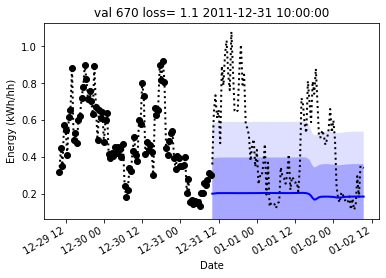

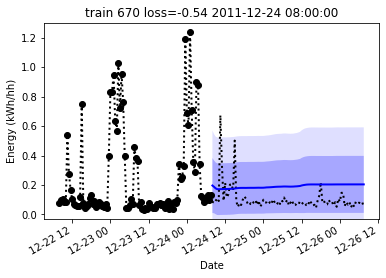

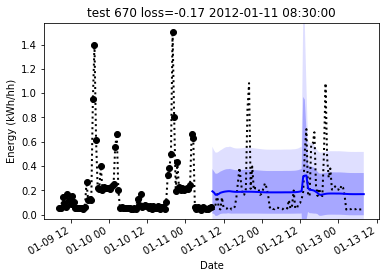

INFO:predict_heading2:step 0, {'agg_test_loss': 0.05123665928840637, 'log': {'agg_test_loss': 0.052775900810956955, 'agg_test_loss_p': 0.05123665928840637, 'agg_test_loss_kl': 0.0015392445493489504, 'agg_test_loss_mse': 0.052192091941833496, 'agg_test_loss_p_weighted': 0.009428323246538639, 'agg_test_score': 0.05123665928840637}}
----------------------------------------------------------------------------------------------------
TEST RESULTS
{}
----------------------------------------------------------------------------------------------------



anp-rnn_c_mean  anp-rnn_mean  anp-rnn_d_mean  \
agg_test_loss                   0.136772      0.317853        0.394125   
agg_test_loss_p                 0.136680      0.308816        0.387186   
agg_test_loss_kl                0.000092      0.009037        0.006939   
agg_test_loss_mse               0.053102      0.044686        0.045177   
agg_test_loss_p_weighted        0.025883      0.060492        0.069565   
agg_test_score                  0.136680      0.308816        0.387186   
n                               3.000000      3.000000        3.000000   

                          anp-rnn_no_det_mean  \
agg_test_loss                        0.546592   
agg_test_loss_p                      0.508449   
agg_test_loss_kl                     0.038142   
agg_test_loss_mse                    0.053395   
agg_test_loss_p_weighted             0.095628   
agg_test_score                       0.508449   
n                                    2.000000   

                          TransformerSeq2Seq_PL_lstm_mean  \
agg_test_loss                                    0.602573   
agg_test_loss_p                                  0.602573   
agg_test_loss_kl                                      NaN   
agg_test_loss_mse                                0.046267   
agg_test_loss_p_weighted                         0.114158   
agg_test_score                                   0.602573   
n                                                2.000000   

                          TransformerSeq2Seq_PL_mean  anp_c_mean  \
agg_test_loss                               0.623226    0.706919   
agg_test_loss_p                             0.623226    0.699513   
agg_test_loss_kl                                 NaN    0.007406   
agg_test_loss_mse                           0.066200    0.048069   
agg_test_loss_p_weighted                    0.118092    0.135607   
agg_test_score                              0.623226    0.699513   
n                                           2.000000    2.000000   

                          LSTM_PL_STD_mean  anp-rnn_extras_mean  \
agg_test_loss                     0.854500             1.022596   
agg_test_loss_p                   0.854500             1.022002   
agg_test_loss_kl                       NaN             0.000594   
agg_test_loss_mse                 0.067944             0.166312   
agg_test_loss_p_weighted          0.150794             0.183035   
agg_test_score                    0.854500             1.022002   
n                                 2.000000             3.000000   

                          anp-rnn_pt_mean  anp-rnn_extras_no_det_mean  \
agg_test_loss                    1.157510                    1.307930   
agg_test_loss_p                  1.142826                    1.238475   
agg_test_loss_kl                 0.014684                    0.069454   
agg_test_loss_mse                0.045285                    0.054398   
agg_test_loss_p_weighted         0.214536                    0.237054   
agg_test_score                   1.142826                    1.238475   
n                                3.000000                    2.000000   

                           np_mean  PL_Transformer_mean  \
agg_test_loss             1.327100             1.546630   
agg_test_loss_p           1.297524             1.546630   
agg_test_loss_kl          0.029577                  NaN   
agg_test_loss_mse         0.049878             0.066195   
agg_test_loss_p_weighted  0.235458             0.294457   
agg_test_score            1.297524             1.546630   
n                         2.000000             2.000000   

                          LSTMSeq2Seq_PL_attn_mean  LSTMSeq2Seq_PL_mean  
agg_test_loss                             2.030935             2.489498  
agg_test_loss_p                           2.030935             2.489498  
agg_test_loss_kl                               NaN                  NaN  
agg_test_loss_mse                         0.051643             0.048283  
agg_test_loss_p_weighted                 

2 {'name': 'anp-rnn_extras_no_det', 'params': {'det_enc_cross_attn_type': 'ptmultihead', 'det_enc_self_attn_type': 'ptmultihead', 'latent_enc_self_attn_type': 'ptmultihead', 'use_deterministic_path': False, 'batchnorm': True, 'attention_dropout': 0.4, 'dropout': 0.2, 'use_lvar': True}, 'PL_MODEL_CLS': <class 'neural_processes.models.neural_process.lightning.PL_ANPRNN'>}
INFO:predict_heading2:now run `tensorboard --logdir lightning_logs`
INFO:root:GPU available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:predict_heading2:trial number=-1200 name=anp-rnn_extras_no_det, trial=<optuna.trial.FixedTrial object at 0x7f8d6e3c0198> params={'learning_rate': 0.003, 'num_heads_power': 2, 'hidden_dim_power': 6, 'latent_dim_power': 5, 'n_latent_encoder_layers': 3, 'n_det_encoder_layers': 3, 'n_decoder_layers': 4, 'dropout': 0.2, 'attention_dropout': 0.4, 'batchnorm': True, 'use_deterministic_path': False} attrs={'batch_size': 24, 'grad_clip': 40, 'max_nb_epochs': 20, 'num_workers': 3, 'num_conte

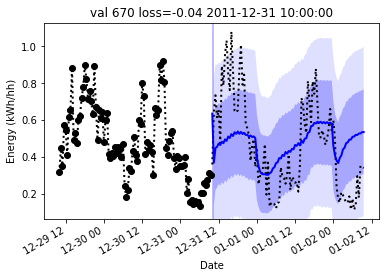

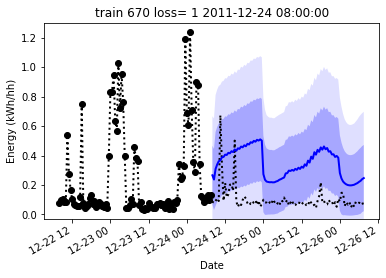

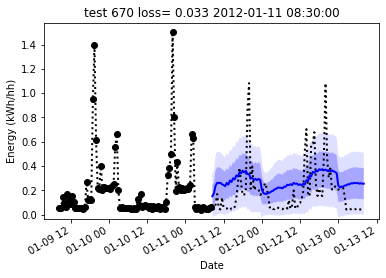

INFO:predict_heading2:step 0, {'agg_test_loss': 0.4192434251308441, 'log': {'agg_test_loss': 0.4645308554172516, 'agg_test_loss_p': 0.4192434251308441, 'agg_test_loss_kl': 0.04528743773698807, 'agg_test_loss_mse': 0.053185004740953445, 'agg_test_loss_p_weighted': 0.0837438777089119, 'agg_test_score': 0.4192434251308441}}
----------------------------------------------------------------------------------------------------
TEST RESULTS
{}
----------------------------------------------------------------------------------------------------



anp-rnn_c_mean  anp-rnn_mean  anp-rnn_d_mean  \
agg_test_loss                   0.136772      0.317853        0.394125   
agg_test_loss_p                 0.136680      0.308816        0.387186   
agg_test_loss_kl                0.000092      0.009037        0.006939   
agg_test_loss_mse               0.053102      0.044686        0.045177   
agg_test_loss_p_weighted        0.025883      0.060492        0.069565   
agg_test_score                  0.136680      0.308816        0.387186   
n                               3.000000      3.000000        3.000000   

                          anp-rnn_no_det_mean  \
agg_test_loss                        0.546592   
agg_test_loss_p                      0.508449   
agg_test_loss_kl                     0.038142   
agg_test_loss_mse                    0.053395   
agg_test_loss_p_weighted             0.095628   
agg_test_score                       0.508449   
n                                    2.000000   

                          TransformerSeq2Seq_PL_lstm_mean  \
agg_test_loss                                    0.602573   
agg_test_loss_p                                  0.602573   
agg_test_loss_kl                                      NaN   
agg_test_loss_mse                                0.046267   
agg_test_loss_p_weighted                         0.114158   
agg_test_score                                   0.602573   
n                                                2.000000   

                          TransformerSeq2Seq_PL_mean  anp_c_mean  \
agg_test_loss                               0.623226    0.706919   
agg_test_loss_p                             0.623226    0.699513   
agg_test_loss_kl                                 NaN    0.007406   
agg_test_loss_mse                           0.066200    0.048069   
agg_test_loss_p_weighted                    0.118092    0.135607   
agg_test_score                              0.623226    0.699513   
n                                           2.000000    2.000000   

                          LSTM_PL_STD_mean  anp-rnn_extras_no_det_mean  \
agg_test_loss                     0.854500                    1.026797   
agg_test_loss_p                   0.854500                    0.965398   
agg_test_loss_kl                       NaN                    0.061399   
agg_test_loss_mse                 0.067944                    0.053994   
agg_test_loss_p_weighted          0.150794                    0.185951   
agg_test_score                    0.854500                    0.965398   
n                                 2.000000                    3.000000   

                          anp-rnn_extras_mean  anp-rnn_pt_mean   np_mean  \
agg_test_loss                        1.022596         1.157510  1.327100   
agg_test_loss_p                      1.022002         1.142826  1.297524   
agg_test_loss_kl                     0.000594         0.014684  0.029577   
agg_test_loss_mse                    0.166312         0.045285  0.049878   
agg_test_loss_p_weighted             0.183035         0.214536  0.235458   
agg_test_score                       1.022002         1.142826  1.297524   
n                                    3.000000         3.000000  2.000000   

                          PL_Transformer_mean  LSTMSeq2Seq_PL_attn_mean  \
agg_test_loss                        1.546630                  2.030935   
agg_test_loss_p                      1.546630                  2.030935   
agg_test_loss_kl                          NaN                       NaN   
agg_test_loss_mse                    0.066195                  0.051643   
agg_test_loss_p_weighted             0.294457                  0.359195   
agg_test_score                       1.546630                  2.030935   
n                                    2.000000                  2.000000   

                          LSTMSeq2Seq_PL_mean  
agg_test_loss                        2.489498  
agg_test_loss_p                      2.489498  
agg_test_loss_kl                          NaN  
agg_test_lo

2 {'name': 'anp-rnn_no_det', 'params': {'use_deterministic_path': False}, 'PL_MODEL_CLS': <class 'neural_processes.models.neural_process.lightning.PL_ANPRNN'>}
INFO:predict_heading2:now run `tensorboard --logdir lightning_logs`
INFO:root:GPU available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:predict_heading2:trial number=-1200 name=anp-rnn_no_det, trial=<optuna.trial.FixedTrial object at 0x7f8dec426518> params={'learning_rate': 0.003, 'num_heads_power': 2, 'hidden_dim_power': 6, 'latent_dim_power': 5, 'n_latent_encoder_layers': 3, 'n_det_encoder_layers': 3, 'n_decoder_layers': 4, 'dropout': 0.1, 'attention_dropout': 0.5, 'batchnorm': False, 'use_deterministic_path': False} attrs={'batch_size': 24, 'grad_clip': 40, 'max_nb_epochs': 20, 'num_workers': 3, 'num_context': 336, 'vis_i': '670', 'num_extra_target': 96, 'x_dim': 17, 'context_in_target': False, 'y_dim': 1, 'patience': 2, 'min_std': 0.005, 'max_epoch_steps': 19200}
INFO:predict_heading2:Loading checkpoint lightning_logs/a

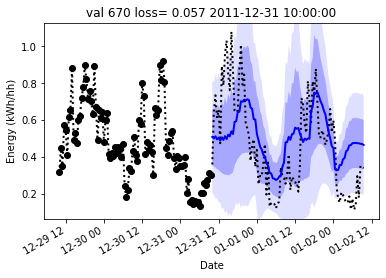

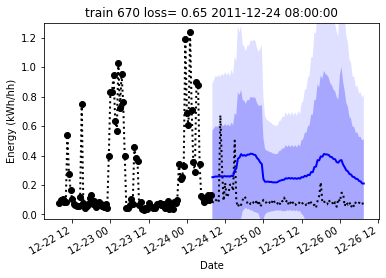

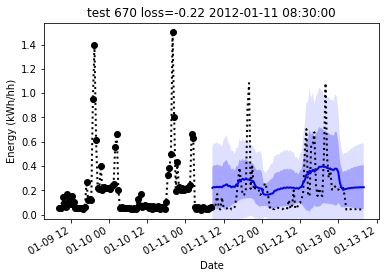

INFO:predict_heading2:step 0, {'agg_test_loss': 0.01707487367093563, 'log': {'agg_test_loss': 0.060435570776462555, 'agg_test_loss_p': 0.01707487367093563, 'agg_test_loss_kl': 0.043360695242881775, 'agg_test_loss_mse': 0.04900040477514267, 'agg_test_loss_p_weighted': 0.0001591588807059452, 'agg_test_score': 0.01707487367093563}}
----------------------------------------------------------------------------------------------------
TEST RESULTS
{}
----------------------------------------------------------------------------------------------------



anp-rnn_c_mean  anp-rnn_mean  anp-rnn_no_det_mean  \
agg_test_loss                   0.136772      0.317853             0.384540   
agg_test_loss_p                 0.136680      0.308816             0.344658   
agg_test_loss_kl                0.000092      0.009037             0.039882   
agg_test_loss_mse               0.053102      0.044686             0.051930   
agg_test_loss_p_weighted        0.025883      0.060492             0.063805   
agg_test_score                  0.136680      0.308816             0.344658   
n                               3.000000      3.000000             3.000000   

                          anp-rnn_d_mean  TransformerSeq2Seq_PL_lstm_mean  \
agg_test_loss                   0.394125                         0.602573   
agg_test_loss_p                 0.387186                         0.602573   
agg_test_loss_kl                0.006939                              NaN   
agg_test_loss_mse               0.045177                         0.046267   
agg_test_loss_p_weighted        0.069565                         0.114158   
agg_test_score                  0.387186                         0.602573   
n                               3.000000                         2.000000   

                          TransformerSeq2Seq_PL_mean  anp_c_mean  \
agg_test_loss                               0.623226    0.706919   
agg_test_loss_p                             0.623226    0.699513   
agg_test_loss_kl                                 NaN    0.007406   
agg_test_loss_mse                           0.066200    0.048069   
agg_test_loss_p_weighted                    0.118092    0.135607   
agg_test_score                              0.623226    0.699513   
n                                           2.000000    2.000000   

                          LSTM_PL_STD_mean  anp-rnn_extras_no_det_mean  \
agg_test_loss                     0.854500                    1.026797   
agg_test_loss_p                   0.854500                    0.965398   
agg_test_loss_kl                       NaN                    0.061399   
agg_test_loss_mse                 0.067944                    0.053994   
agg_test_loss_p_weighted          0.150794                    0.185951   
agg_test_score                    0.854500                    0.965398   
n                                 2.000000                    3.000000   

                          anp-rnn_extras_mean  anp-rnn_pt_mean   np_mean  \
agg_test_loss                        1.022596         1.157510  1.327100   
agg_test_loss_p                      1.022002         1.142826  1.297524   
agg_test_loss_kl                     0.000594         0.014684  0.029577   
agg_test_loss_mse                    0.166312         0.045285  0.049878   
agg_test_loss_p_weighted             0.183035         0.214536  0.235458   
agg_test_score                       1.022002         1.142826  1.297524   
n                                    3.000000         3.000000  2.000000   

                          PL_Transformer_mean  LSTMSeq2Seq_PL_attn_mean  \
agg_test_loss                        1.546630                  2.030935   
agg_test_loss_p                      1.546630                  2.030935   
agg_test_loss_kl                          NaN                       NaN   
agg_test_loss_mse                    0.066195                  0.051643   
agg_test_loss_p_weighted             0.294457                  0.359195   
agg_test_score                       1.546630                  2.030935   
n                                    2.000000                  2.000000   

                          LSTMSeq2Seq_PL_mean  
agg_test_loss                        2.489498  
agg_test_loss_p                      2.489498  
agg_test_loss_kl                          NaN  
agg_test_loss_mse                    0.048283  
agg_test_loss_p_weighted             0.428947  
agg_test_score                       2.489498  
n                                    2.000000

2 {'name': 'TransformerSeq2Seq_PL_lstm', 'params': {'use_lstm': True}, 'PL_MODEL_CLS': <class 'neural_processes.models.transformer_seq2seq.TransformerSeq2Seq_PL'>}
INFO:predict_heading2:now run `tensorboard --logdir lightning_logs`
INFO:root:GPU available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:predict_heading2:trial number=-1200 name=TransformerSeq2Seq_PL_lstm, trial=<optuna.trial.FixedTrial object at 0x7f8dec591358> params={'learning_rate': 0.002, 'attention_dropout': 0.2, 'hidden_size_power': 5, 'hidden_out_size_power': 4, 'nhead_power': 3, 'nlayers': 2, 'use_lstm': True, 'agg': 'max'} attrs={'batch_size': 24, 'grad_clip': 40, 'max_nb_epochs': 20, 'num_workers': 3, 'num_extra_target': 96, 'vis_i': '670', 'num_context': 336, 'input_size': 18, 'input_size_decoder': 17, 'context_in_target': False, 'output_size': 1, 'patience': 2, 'min_std': 0.005, 'x_dim': 17, 'y_dim': 1, 'max_epoch_steps': 19200}
INFO:predict_heading2:Loading checkpoint lightning_logs/TransformerSeq2Seq_PL_ls

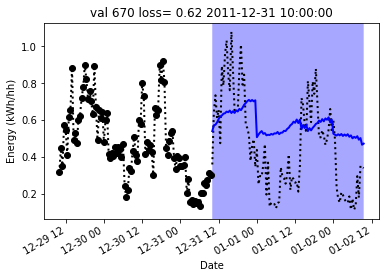

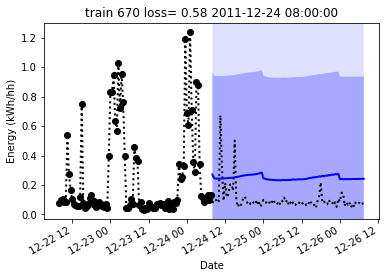

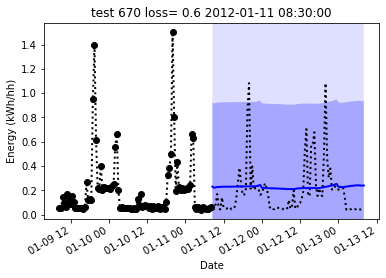

INFO:predict_heading2:step 0, {'agg_test_loss': 0.6076895594596863, 'log': {'agg_test_loss': 0.6076895594596863, 'agg_test_loss_p': 0.6076895594596863, 'agg_test_loss_mse': 0.05120475962758064, 'agg_test_loss_p_weighted': 0.11512292921543121, 'agg_test_score': 0.6076895594596863}}
----------------------------------------------------------------------------------------------------
TEST RESULTS
{}
----------------------------------------------------------------------------------------------------



anp-rnn_c_mean  anp-rnn_mean  anp-rnn_no_det_mean  \
agg_test_loss                   0.136772      0.317853             0.384540   
agg_test_loss_p                 0.136680      0.308816             0.344658   
agg_test_loss_kl                0.000092      0.009037             0.039882   
agg_test_loss_mse               0.053102      0.044686             0.051930   
agg_test_loss_p_weighted        0.025883      0.060492             0.063805   
agg_test_score                  0.136680      0.308816             0.344658   
n                               3.000000      3.000000             3.000000   

                          anp-rnn_d_mean  TransformerSeq2Seq_PL_lstm_mean  \
agg_test_loss                   0.394125                         0.604279   
agg_test_loss_p                 0.387186                         0.604279   
agg_test_loss_kl                0.006939                              NaN   
agg_test_loss_mse               0.045177                         0.047913   
agg_test_loss_p_weighted        0.069565                         0.114480   
agg_test_score                  0.387186                         0.604279   
n                               3.000000                         3.000000   

                          TransformerSeq2Seq_PL_mean  anp_c_mean  \
agg_test_loss                               0.623226    0.706919   
agg_test_loss_p                             0.623226    0.699513   
agg_test_loss_kl                                 NaN    0.007406   
agg_test_loss_mse                           0.066200    0.048069   
agg_test_loss_p_weighted                    0.118092    0.135607   
agg_test_score                              0.623226    0.699513   
n                                           2.000000    2.000000   

                          LSTM_PL_STD_mean  anp-rnn_extras_no_det_mean  \
agg_test_loss                     0.854500                    1.026797   
agg_test_loss_p                   0.854500                    0.965398   
agg_test_loss_kl                       NaN                    0.061399   
agg_test_loss_mse                 0.067944                    0.053994   
agg_test_loss_p_weighted          0.150794                    0.185951   
agg_test_score                    0.854500                    0.965398   
n                                 2.000000                    3.000000   

                          anp-rnn_extras_mean  anp-rnn_pt_mean   np_mean  \
agg_test_loss                        1.022596         1.157510  1.327100   
agg_test_loss_p                      1.022002         1.142826  1.297524   
agg_test_loss_kl                     0.000594         0.014684  0.029577   
agg_test_loss_mse                    0.166312         0.045285  0.049878   
agg_test_loss_p_weighted             0.183035         0.214536  0.235458   
agg_test_score                       1.022002         1.142826  1.297524   
n                                    3.000000         3.000000  2.000000   

                          PL_Transformer_mean  LSTMSeq2Seq_PL_attn_mean  \
agg_test_loss                        1.546630                  2.030935   
agg_test_loss_p                      1.546630                  2.030935   
agg_test_loss_kl                          NaN                       NaN   
agg_test_loss_mse                    0.066195                  0.051643   
agg_test_loss_p_weighted             0.294457                  0.359195   
agg_test_score                       1.546630                  2.030935   
n                                    2.000000                  2.000000   

                          LSTMSeq2Seq_PL_mean  
agg_test_loss                        2.489498  
agg_test_loss_p                      2.489498  
agg_test_loss_kl                          NaN  
agg_test_loss_mse                    0.048283  
agg_test_loss_p_weighted             0.428947  
agg_test_score                       2.489498  
n                                    2.000000

2 {'name': 'TransformerSeq2Seq_PL', 'PL_MODEL_CLS': <class 'neural_processes.models.transformer_seq2seq.TransformerSeq2Seq_PL'>}
INFO:predict_heading2:now run `tensorboard --logdir lightning_logs`
INFO:root:GPU available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:predict_heading2:trial number=-1200 name=TransformerSeq2Seq_PL, trial=<optuna.trial.FixedTrial object at 0x7f8dec426518> params={'learning_rate': 0.002, 'attention_dropout': 0.2, 'hidden_size_power': 5, 'hidden_out_size_power': 4, 'nhead_power': 3, 'nlayers': 2, 'use_lstm': False, 'agg': 'max'} attrs={'batch_size': 24, 'grad_clip': 40, 'max_nb_epochs': 20, 'num_workers': 3, 'num_extra_target': 96, 'vis_i': '670', 'num_context': 336, 'input_size': 18, 'input_size_decoder': 17, 'context_in_target': False, 'output_size': 1, 'patience': 2, 'min_std': 0.005, 'x_dim': 17, 'y_dim': 1, 'max_epoch_steps': 19200}
INFO:predict_heading2:Loading checkpoint lightning_logs/TransformerSeq2Seq_PL/version_-1200/_ckpt_epoch_12.ckpt


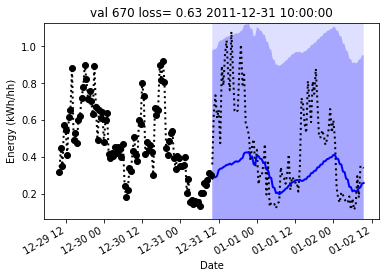

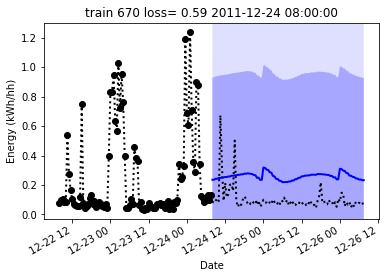

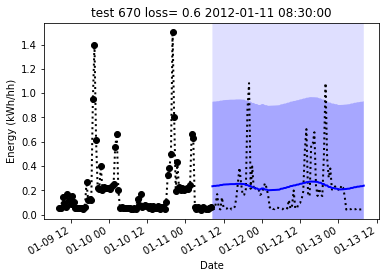

INFO:predict_heading2:step 0, {'agg_test_loss': 0.602739155292511, 'log': {'agg_test_loss': 0.602739155292511, 'agg_test_loss_p': 0.602739155292511, 'agg_test_loss_mse': 0.04642687365412712, 'agg_test_loss_p_weighted': 0.11419355869293213, 'agg_test_score': 0.602739155292511}}
----------------------------------------------------------------------------------------------------
TEST RESULTS
{}
----------------------------------------------------------------------------------------------------



anp-rnn_c_mean  anp-rnn_mean  anp-rnn_no_det_mean  \
agg_test_loss                   0.136772      0.317853             0.384540   
agg_test_loss_p                 0.136680      0.308816             0.344658   
agg_test_loss_kl                0.000092      0.009037             0.039882   
agg_test_loss_mse               0.053102      0.044686             0.051930   
agg_test_loss_p_weighted        0.025883      0.060492             0.063805   
agg_test_score                  0.136680      0.308816             0.344658   
n                               3.000000      3.000000             3.000000   

                          anp-rnn_d_mean  TransformerSeq2Seq_PL_lstm_mean  \
agg_test_loss                   0.394125                         0.604279   
agg_test_loss_p                 0.387186                         0.604279   
agg_test_loss_kl                0.006939                              NaN   
agg_test_loss_mse               0.045177                         0.047913   
agg_test_loss_p_weighted        0.069565                         0.114480   
agg_test_score                  0.387186                         0.604279   
n                               3.000000                         3.000000   

                          TransformerSeq2Seq_PL_mean  anp_c_mean  \
agg_test_loss                               0.616397    0.706919   
agg_test_loss_p                             0.616397    0.699513   
agg_test_loss_kl                                 NaN    0.007406   
agg_test_loss_mse                           0.059609    0.048069   
agg_test_loss_p_weighted                    0.116793    0.135607   
agg_test_score                              0.616397    0.699513   
n                                           3.000000    2.000000   

                          LSTM_PL_STD_mean  anp-rnn_extras_no_det_mean  \
agg_test_loss                     0.854500                    1.026797   
agg_test_loss_p                   0.854500                    0.965398   
agg_test_loss_kl                       NaN                    0.061399   
agg_test_loss_mse                 0.067944                    0.053994   
agg_test_loss_p_weighted          0.150794                    0.185951   
agg_test_score                    0.854500                    0.965398   
n                                 2.000000                    3.000000   

                          anp-rnn_extras_mean  anp-rnn_pt_mean   np_mean  \
agg_test_loss                        1.022596         1.157510  1.327100   
agg_test_loss_p                      1.022002         1.142826  1.297524   
agg_test_loss_kl                     0.000594         0.014684  0.029577   
agg_test_loss_mse                    0.166312         0.045285  0.049878   
agg_test_loss_p_weighted             0.183035         0.214536  0.235458   
agg_test_score                       1.022002         1.142826  1.297524   
n                                    3.000000         3.000000  2.000000   

                          PL_Transformer_mean  LSTMSeq2Seq_PL_attn_mean  \
agg_test_loss                        1.546630                  2.030935   
agg_test_loss_p                      1.546630                  2.030935   
agg_test_loss_kl                          NaN                       NaN   
agg_test_loss_mse                    0.066195                  0.051643   
agg_test_loss_p_weighted             0.294457                  0.359195   
agg_test_score                       1.546630                  2.030935   
n                                    2.000000                  2.000000   

                          LSTMSeq2Seq_PL_mean  
agg_test_loss                        2.489498  
agg_test_loss_p                      2.489498  
agg_test_loss_kl                          NaN  
agg_test_loss_mse                    0.048283  
agg_test_loss_p_weighted             0.428947  
agg_test_score                       2.489498  
n                                    2.000000

2 {'name': 'LSTMSeq2Seq_PL_attn', 'PL_MODEL_CLS': <class 'neural_processes.models.lstm_seqseq.LSTMSeq2Seq_PL'>, 'params': {'use_self_attn': True, 'use_cross_attn': True}}
INFO:predict_heading2:now run `tensorboard --logdir lightning_logs`
INFO:root:GPU available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:predict_heading2:trial number=-1200 name=LSTMSeq2Seq_PL_attn, trial=<optuna.trial.FixedTrial object at 0x7f8dec31c668> params={'learning_rate': 0.001, 'lstm_dropout': 0.22, 'hidden_size_power': 6.0, 'lstm_layers': 3, 'bidirectional': False} attrs={'batch_size': 24, 'grad_clip': 40, 'max_nb_epochs': 20, 'num_workers': 3, 'num_extra_target': 96, 'vis_i': '670', 'num_context': 336, 'input_size': 18, 'input_size_decoder': 17, 'context_in_target': False, 'output_size': 1, 'min_std': 0.005, 'x_dim': 17, 'y_dim': 1, 'patience': 2, 'max_epoch_steps': 19200}
INFO:predict_heading2:Loading checkpoint lightning_logs/LSTMSeq2Seq_PL_attn/version_-1200/_ckpt_epoch_3.ckpt


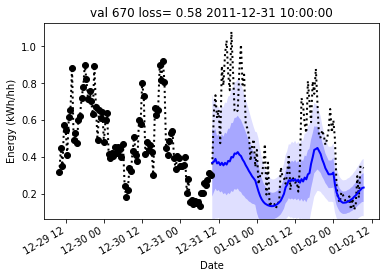

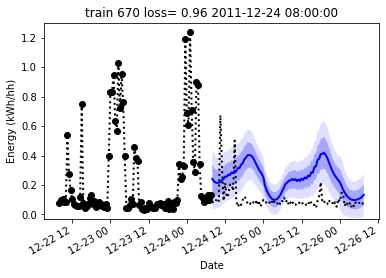

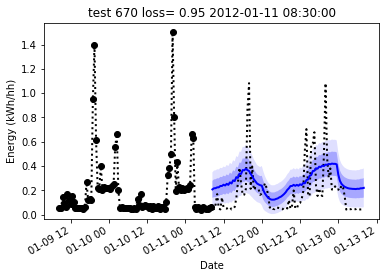

INFO:predict_heading2:step 0, {'agg_test_loss': 2.012340784072876, 'log': {'agg_test_loss': 2.012340784072876, 'agg_test_loss_p': 2.012340784072876, 'agg_test_loss_mse': 0.04674893990159035, 'agg_test_loss_p_weighted': 0.4223657548427582, 'agg_test_score': 2.012340784072876}}
----------------------------------------------------------------------------------------------------
TEST RESULTS
{}
----------------------------------------------------------------------------------------------------



anp-rnn_c_mean  anp-rnn_mean  anp-rnn_no_det_mean  \
agg_test_loss                   0.136772      0.317853             0.384540   
agg_test_loss_p                 0.136680      0.308816             0.344658   
agg_test_loss_kl                0.000092      0.009037             0.039882   
agg_test_loss_mse               0.053102      0.044686             0.051930   
agg_test_loss_p_weighted        0.025883      0.060492             0.063805   
agg_test_score                  0.136680      0.308816             0.344658   
n                               3.000000      3.000000             3.000000   

                          anp-rnn_d_mean  TransformerSeq2Seq_PL_lstm_mean  \
agg_test_loss                   0.394125                         0.604279   
agg_test_loss_p                 0.387186                         0.604279   
agg_test_loss_kl                0.006939                              NaN   
agg_test_loss_mse               0.045177                         0.047913   
agg_test_loss_p_weighted        0.069565                         0.114480   
agg_test_score                  0.387186                         0.604279   
n                               3.000000                         3.000000   

                          TransformerSeq2Seq_PL_mean  anp_c_mean  \
agg_test_loss                               0.616397    0.706919   
agg_test_loss_p                             0.616397    0.699513   
agg_test_loss_kl                                 NaN    0.007406   
agg_test_loss_mse                           0.059609    0.048069   
agg_test_loss_p_weighted                    0.116793    0.135607   
agg_test_score                              0.616397    0.699513   
n                                           3.000000    2.000000   

                          LSTM_PL_STD_mean  anp-rnn_extras_no_det_mean  \
agg_test_loss                     0.854500                    1.026797   
agg_test_loss_p                   0.854500                    0.965398   
agg_test_loss_kl                       NaN                    0.061399   
agg_test_loss_mse                 0.067944                    0.053994   
agg_test_loss_p_weighted          0.150794                    0.185951   
agg_test_score                    0.854500                    0.965398   
n                                 2.000000                    3.000000   

                          anp-rnn_extras_mean  anp-rnn_pt_mean   np_mean  \
agg_test_loss                        1.022596         1.157510  1.327100   
agg_test_loss_p                      1.022002         1.142826  1.297524   
agg_test_loss_kl                     0.000594         0.014684  0.029577   
agg_test_loss_mse                    0.166312         0.045285  0.049878   
agg_test_loss_p_weighted             0.183035         0.214536  0.235458   
agg_test_score                       1.022002         1.142826  1.297524   
n                                    3.000000         3.000000  2.000000   

                          PL_Transformer_mean  LSTMSeq2Seq_PL_attn_mean  \
agg_test_loss                        1.546630                  2.024737   
agg_test_loss_p                      1.546630                  2.024737   
agg_test_loss_kl                          NaN                       NaN   
agg_test_loss_mse                    0.066195                  0.050012   
agg_test_loss_p_weighted             0.294457                  0.380252   
agg_test_score                       1.546630                  2.024737   
n                                    2.000000                  3.000000   

                          LSTMSeq2Seq_PL_mean  
agg_test_loss                        2.489498  
agg_test_loss_p                      2.489498  
agg_test_loss_kl                          NaN  
agg_test_loss_mse                    0.048283  
agg_test_loss_p_weighted             0.428947  
agg_test_score                       2.489498  
n                                    2.000000

2 {'name': 'LSTMSeq2Seq_PL', 'PL_MODEL_CLS': <class 'neural_processes.models.lstm_seqseq.LSTMSeq2Seq_PL'>, 'params': {'use_self_attn': False, 'use_cross_attn': False}}
INFO:predict_heading2:now run `tensorboard --logdir lightning_logs`
INFO:root:GPU available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:predict_heading2:trial number=-1200 name=LSTMSeq2Seq_PL, trial=<optuna.trial.FixedTrial object at 0x7f8d6e5a9908> params={'learning_rate': 0.001, 'lstm_dropout': 0.22, 'hidden_size_power': 6.0, 'lstm_layers': 3, 'bidirectional': False} attrs={'batch_size': 24, 'grad_clip': 40, 'max_nb_epochs': 20, 'num_workers': 3, 'num_extra_target': 96, 'vis_i': '670', 'num_context': 336, 'input_size': 18, 'input_size_decoder': 17, 'context_in_target': False, 'output_size': 1, 'min_std': 0.005, 'x_dim': 17, 'y_dim': 1, 'patience': 2, 'max_epoch_steps': 19200}
INFO:predict_heading2:Loading checkpoint lightning_logs/LSTMSeq2Seq_PL/version_-1200/_ckpt_epoch_14.ckpt


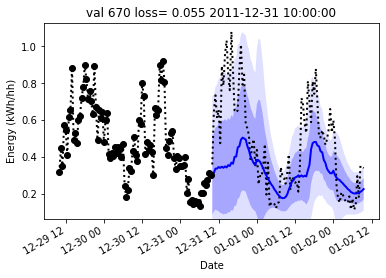

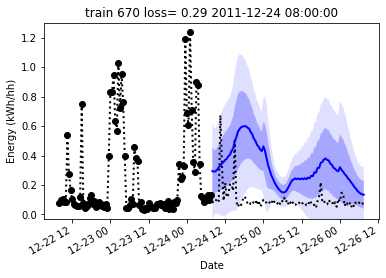

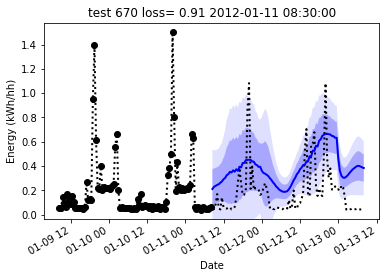

INFO:predict_heading2:step 0, {'agg_test_loss': 2.8598482608795166, 'log': {'agg_test_loss': 2.8598482608795166, 'agg_test_loss_p': 2.8598482608795166, 'agg_test_loss_mse': 0.0674910917878151, 'agg_test_loss_p_weighted': 0.5464612245559692, 'agg_test_score': 2.8598482608795166}}
----------------------------------------------------------------------------------------------------
TEST RESULTS
{}
----------------------------------------------------------------------------------------------------



anp-rnn_c_mean  anp-rnn_mean  anp-rnn_no_det_mean  \
agg_test_loss                   0.136772      0.317853             0.384540   
agg_test_loss_p                 0.136680      0.308816             0.344658   
agg_test_loss_kl                0.000092      0.009037             0.039882   
agg_test_loss_mse               0.053102      0.044686             0.051930   
agg_test_loss_p_weighted        0.025883      0.060492             0.063805   
agg_test_score                  0.136680      0.308816             0.344658   
n                               3.000000      3.000000             3.000000   

                          anp-rnn_d_mean  TransformerSeq2Seq_PL_lstm_mean  \
agg_test_loss                   0.394125                         0.604279   
agg_test_loss_p                 0.387186                         0.604279   
agg_test_loss_kl                0.006939                              NaN   
agg_test_loss_mse               0.045177                         0.047913   
agg_test_loss_p_weighted        0.069565                         0.114480   
agg_test_score                  0.387186                         0.604279   
n                               3.000000                         3.000000   

                          TransformerSeq2Seq_PL_mean  anp_c_mean  \
agg_test_loss                               0.616397    0.706919   
agg_test_loss_p                             0.616397    0.699513   
agg_test_loss_kl                                 NaN    0.007406   
agg_test_loss_mse                           0.059609    0.048069   
agg_test_loss_p_weighted                    0.116793    0.135607   
agg_test_score                              0.616397    0.699513   
n                                           3.000000    2.000000   

                          LSTM_PL_STD_mean  anp-rnn_extras_no_det_mean  \
agg_test_loss                     0.854500                    1.026797   
agg_test_loss_p                   0.854500                    0.965398   
agg_test_loss_kl                       NaN                    0.061399   
agg_test_loss_mse                 0.067944                    0.053994   
agg_test_loss_p_weighted          0.150794                    0.185951   
agg_test_score                    0.854500                    0.965398   
n                                 2.000000                    3.000000   

                          anp-rnn_extras_mean  anp-rnn_pt_mean   np_mean  \
agg_test_loss                        1.022596         1.157510  1.327100   
agg_test_loss_p                      1.022002         1.142826  1.297524   
agg_test_loss_kl                     0.000594         0.014684  0.029577   
agg_test_loss_mse                    0.166312         0.045285  0.049878   
agg_test_loss_p_weighted             0.183035         0.214536  0.235458   
agg_test_score                       1.022002         1.142826  1.297524   
n                                    3.000000         3.000000  2.000000   

                          PL_Transformer_mean  LSTMSeq2Seq_PL_attn_mean  \
agg_test_loss                        1.546630                  2.024737   
agg_test_loss_p                      1.546630                  2.024737   
agg_test_loss_kl                          NaN                       NaN   
agg_test_loss_mse                    0.066195                  0.050012   
agg_test_loss_p_weighted             0.294457                  0.380252   
agg_test_score                       1.546630                  2.024737   
n                                    2.000000                  3.000000   

                          LSTMSeq2Seq_PL_mean  
agg_test_loss                        2.612948  
agg_test_loss_p                      2.612948  
agg_test_loss_kl                          NaN  
agg_test_loss_mse                    0.054685  
agg_test_loss_p_weighted             0.468119  
agg_test_score                       2.612948  
n                                    3.000000

2 {'name': 'anp_c', 'PL_MODEL_CLS': <class 'neural_processes.models.neural_process.lightning.PL_ANP'>}
INFO:predict_heading2:now run `tensorboard --logdir lightning_logs`
INFO:root:GPU available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:predict_heading2:trial number=-1200 name=anp_c, trial=<optuna.trial.FixedTrial object at 0x7f8d7118e5f8> params={'learning_rate': 0.003, 'num_heads_power': 2, 'hidden_dim_power': 6, 'latent_dim_power': 5, 'n_latent_encoder_layers': 3, 'n_det_encoder_layers': 3, 'n_decoder_layers': 4, 'dropout': 0.1, 'attention_dropout': 0.5, 'batchnorm': False, 'use_deterministic_path': True} attrs={'batch_size': 24, 'grad_clip': 40, 'max_nb_epochs': 20, 'num_workers': 3, 'num_context': 336, 'vis_i': '670', 'num_extra_target': 96, 'x_dim': 17, 'context_in_target': False, 'y_dim': 1, 'patience': 2, 'min_std': 0.005, 'max_epoch_steps': 19200}
INFO:predict_heading2:Loading checkpoint lightning_logs/anp_c/version_-1200/_ckpt_epoch_9.ckpt


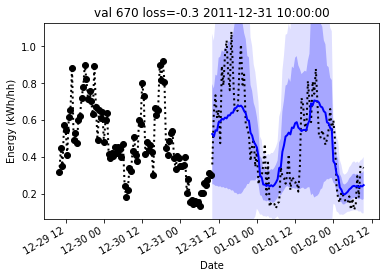

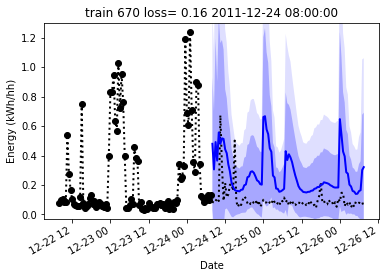

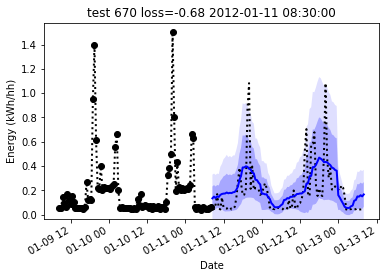

INFO:predict_heading2:step 0, {'agg_test_loss': 0.2463783323764801, 'log': {'agg_test_loss': 0.25880876183509827, 'agg_test_loss_p': 0.2463783323764801, 'agg_test_loss_kl': 0.012430431321263313, 'agg_test_loss_mse': 0.04406549409031868, 'agg_test_loss_p_weighted': 0.043534982949495316, 'agg_test_score': 0.2463783323764801}}
----------------------------------------------------------------------------------------------------
TEST RESULTS
{}
----------------------------------------------------------------------------------------------------



anp-rnn_c_mean  anp-rnn_mean  anp-rnn_no_det_mean  \
agg_test_loss                   0.136772      0.317853             0.384540   
agg_test_loss_p                 0.136680      0.308816             0.344658   
agg_test_loss_kl                0.000092      0.009037             0.039882   
agg_test_loss_mse               0.053102      0.044686             0.051930   
agg_test_loss_p_weighted        0.025883      0.060492             0.063805   
agg_test_score                  0.136680      0.308816             0.344658   
n                               3.000000      3.000000             3.000000   

                          anp-rnn_d_mean  anp_c_mean  \
agg_test_loss                   0.394125    0.557549   
agg_test_loss_p                 0.387186    0.548468   
agg_test_loss_kl                0.006939    0.009081   
agg_test_loss_mse               0.045177    0.046734   
agg_test_loss_p_weighted        0.069565    0.104916   
agg_test_score                  0.387186    0.548468   
n                               3.000000    3.000000   

                          TransformerSeq2Seq_PL_lstm_mean  \
agg_test_loss                                    0.604279   
agg_test_loss_p                                  0.604279   
agg_test_loss_kl                                      NaN   
agg_test_loss_mse                                0.047913   
agg_test_loss_p_weighted                         0.114480   
agg_test_score                                   0.604279   
n                                                3.000000   

                          TransformerSeq2Seq_PL_mean  LSTM_PL_STD_mean  \
agg_test_loss                               0.616397          0.854500   
agg_test_loss_p                             0.616397          0.854500   
agg_test_loss_kl                                 NaN               NaN   
agg_test_loss_mse                           0.059609          0.067944   
agg_test_loss_p_weighted                    0.116793          0.150794   
agg_test_score                              0.616397          0.854500   
n                                           3.000000          2.000000   

                          anp-rnn_extras_no_det_mean  anp-rnn_extras_mean  \
agg_test_loss                               1.026797             1.022596   
agg_test_loss_p                             0.965398             1.022002   
agg_test_loss_kl                            0.061399             0.000594   
agg_test_loss_mse                           0.053994             0.166312   
agg_test_loss_p_weighted                    0.185951             0.183035   
agg_test_score                              0.965398             1.022002   
n                                           3.000000             3.000000   

                          anp-rnn_pt_mean   np_mean  PL_Transformer_mean  \
agg_test_loss                    1.157510  1.327100             1.546630   
agg_test_loss_p                  1.142826  1.297524             1.546630   
agg_test_loss_kl                 0.014684  0.029577                  NaN   
agg_test_loss_mse                0.045285  0.049878             0.066195   
agg_test_loss_p_weighted         0.214536  0.235458             0.294457   
agg_test_score                   1.142826  1.297524             1.546630   
n                                3.000000  2.000000             2.000000   

                          LSTMSeq2Seq_PL_attn_mean  LSTMSeq2Seq_PL_mean  
agg_test_loss                             2.024737             2.612948  
agg_test_loss_p                           2.024737             2.612948  
agg_test_loss_kl                               NaN                  NaN  
agg_test_loss_mse                         0.050012             0.054685  
agg_test_loss_p_weighted                  0.380252             0.468119  
agg_test_score                            2.024737             2.612948  
n                                         3.000000             3.000000

2 {'name': 'np', 'PL_MODEL_CLS': <class 'neural_processes.models.neural_process.lightning.PL_NP'>}
INFO:predict_heading2:now run `tensorboard --logdir lightning_logs`
INFO:root:GPU available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:predict_heading2:trial number=-1200 name=np, trial=<optuna.trial.FixedTrial object at 0x7f8d6cf3f908> params={'learning_rate': 0.003, 'hidden_dim_power': 6, 'latent_dim_power': 5, 'n_latent_encoder_layers': 3, 'n_decoder_layers': 4, 'dropout': 0.1, 'batchnorm': False} attrs={'batch_size': 24, 'grad_clip': 40, 'max_nb_epochs': 20, 'num_workers': 3, 'num_context': 336, 'vis_i': '670', 'num_extra_target': 96, 'x_dim': 17, 'context_in_target': False, 'y_dim': 1, 'patience': 2, 'min_std': 0.005, 'max_epoch_steps': 19200}
INFO:predict_heading2:Loading checkpoint lightning_logs/np/version_-1200/_ckpt_epoch_0.ckpt


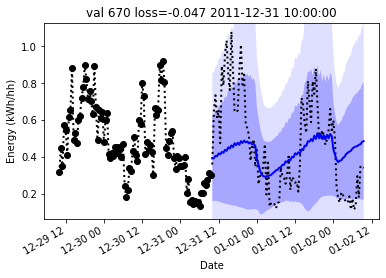

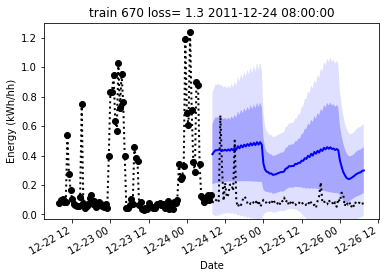

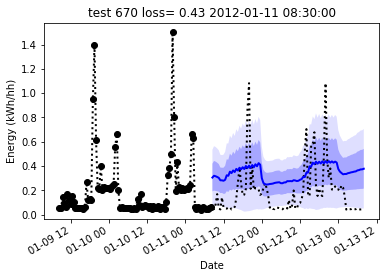

INFO:predict_heading2:step 0, {'agg_test_loss': 0.6847045421600342, 'log': {'agg_test_loss': 0.7056866884231567, 'agg_test_loss_p': 0.6847045421600342, 'agg_test_loss_kl': 0.020982056856155396, 'agg_test_loss_mse': 0.07278481125831604, 'agg_test_loss_p_weighted': 0.13104602694511414, 'agg_test_score': 0.6847045421600342}}
----------------------------------------------------------------------------------------------------
TEST RESULTS
{}
----------------------------------------------------------------------------------------------------



anp-rnn_c_mean  anp-rnn_mean  anp-rnn_no_det_mean  \
agg_test_loss                   0.136772      0.317853             0.384540   
agg_test_loss_p                 0.136680      0.308816             0.344658   
agg_test_loss_kl                0.000092      0.009037             0.039882   
agg_test_loss_mse               0.053102      0.044686             0.051930   
agg_test_loss_p_weighted        0.025883      0.060492             0.063805   
agg_test_score                  0.136680      0.308816             0.344658   
n                               3.000000      3.000000             3.000000   

                          anp-rnn_d_mean  anp_c_mean  \
agg_test_loss                   0.394125    0.557549   
agg_test_loss_p                 0.387186    0.548468   
agg_test_loss_kl                0.006939    0.009081   
agg_test_loss_mse               0.045177    0.046734   
agg_test_loss_p_weighted        0.069565    0.104916   
agg_test_score                  0.387186    0.548468   
n                               3.000000    3.000000   

                          TransformerSeq2Seq_PL_lstm_mean  \
agg_test_loss                                    0.604279   
agg_test_loss_p                                  0.604279   
agg_test_loss_kl                                      NaN   
agg_test_loss_mse                                0.047913   
agg_test_loss_p_weighted                         0.114480   
agg_test_score                                   0.604279   
n                                                3.000000   

                          TransformerSeq2Seq_PL_mean  LSTM_PL_STD_mean  \
agg_test_loss                               0.616397          0.854500   
agg_test_loss_p                             0.616397          0.854500   
agg_test_loss_kl                                 NaN               NaN   
agg_test_loss_mse                           0.059609          0.067944   
agg_test_loss_p_weighted                    0.116793          0.150794   
agg_test_score                              0.616397          0.854500   
n                                           3.000000          2.000000   

                          anp-rnn_extras_no_det_mean  anp-rnn_extras_mean  \
agg_test_loss                               1.026797             1.022596   
agg_test_loss_p                             0.965398             1.022002   
agg_test_loss_kl                            0.061399             0.000594   
agg_test_loss_mse                           0.053994             0.166312   
agg_test_loss_p_weighted                    0.185951             0.183035   
agg_test_score                              0.965398             1.022002   
n                                           3.000000             3.000000   

                           np_mean  anp-rnn_pt_mean  PL_Transformer_mean  \
agg_test_loss             1.119962         1.157510             1.546630   
agg_test_loss_p           1.093251         1.142826             1.546630   
agg_test_loss_kl          0.026712         0.014684                  NaN   
agg_test_loss_mse         0.057514         0.045285             0.066195   
agg_test_loss_p_weighted  0.200654         0.214536             0.294457   
agg_test_score            1.093251         1.142826             1.546630   
n                         3.000000         3.000000             2.000000   

                          LSTMSeq2Seq_PL_attn_mean  LSTMSeq2Seq_PL_mean  
agg_test_loss                             2.024737             2.612948  
agg_test_loss_p                           2.024737             2.612948  
agg_test_loss_kl                               NaN                  NaN  
agg_test_loss_mse                         0.050012             0.054685  
agg_test_loss_p_weighted                  0.380252             0.468119  
agg_test_score                            2.024737             2.612948  
n                                         3.000000             3.000000

2 {'name': 'PL_Transformer', 'PL_MODEL_CLS': <class 'neural_processes.models.transformer.PL_Transformer'>}
INFO:predict_heading2:now run `tensorboard --logdir lightning_logs`
INFO:root:GPU available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:predict_heading2:trial number=-1200 name=PL_Transformer, trial=<optuna.trial.FixedTrial object at 0x7f8d6eaffef0> params={'learning_rate': 0.003, 'attention_dropout': 0.4, 'hidden_size_power': 7.0, 'hidden_out_size_power': 7.0, 'nhead_power': 1.0, 'nlayers': 2} attrs={'batch_size': 24, 'grad_clip': 40, 'max_nb_epochs': 20, 'num_workers': 3, 'vis_i': '670', 'x_dim': 17, 'y_dim': 1, 'context_in_target': False, 'patience': 2, 'min_std': 0.005, 'nan_value': -99.9, 'num_context': 336, 'num_extra_target': 96, 'max_epoch_steps': 19200}
INFO:predict_heading2:Loading checkpoint lightning_logs/PL_Transformer/version_-1200/_ckpt_epoch_5.ckpt


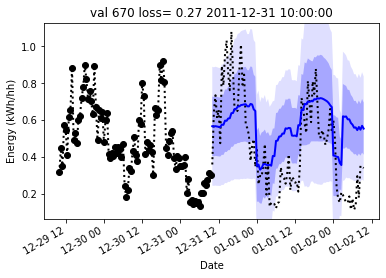

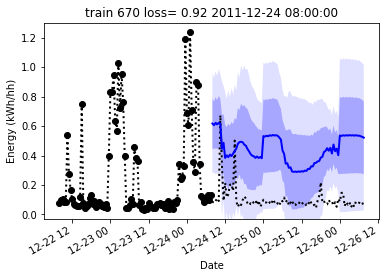

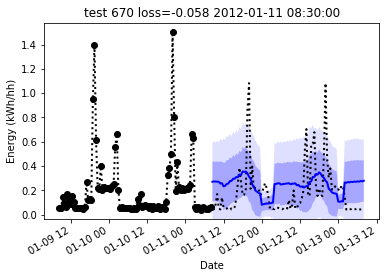

INFO:predict_heading2:step 0, {'agg_test_loss': 1.5256152153015137, 'log': {'agg_test_loss': 1.5256152153015137, 'agg_test_loss_p': 1.5256152153015137, 'agg_test_loss_mse': 0.07976607233285904, 'agg_test_loss_p_weighted': 0.29099002480506897, 'agg_test_score': 1.5256152153015137}}
----------------------------------------------------------------------------------------------------
TEST RESULTS
{}
----------------------------------------------------------------------------------------------------



anp-rnn_c_mean  anp-rnn_mean  anp-rnn_no_det_mean  \
agg_test_loss                   0.136772      0.317853             0.384540   
agg_test_loss_p                 0.136680      0.308816             0.344658   
agg_test_loss_kl                0.000092      0.009037             0.039882   
agg_test_loss_mse               0.053102      0.044686             0.051930   
agg_test_loss_p_weighted        0.025883      0.060492             0.063805   
agg_test_score                  0.136680      0.308816             0.344658   
n                               3.000000      3.000000             3.000000   

                          anp-rnn_d_mean  anp_c_mean  \
agg_test_loss                   0.394125    0.557549   
agg_test_loss_p                 0.387186    0.548468   
agg_test_loss_kl                0.006939    0.009081   
agg_test_loss_mse               0.045177    0.046734   
agg_test_loss_p_weighted        0.069565    0.104916   
agg_test_score                  0.387186    0.548468   
n                               3.000000    3.000000   

                          TransformerSeq2Seq_PL_lstm_mean  \
agg_test_loss                                    0.604279   
agg_test_loss_p                                  0.604279   
agg_test_loss_kl                                      NaN   
agg_test_loss_mse                                0.047913   
agg_test_loss_p_weighted                         0.114480   
agg_test_score                                   0.604279   
n                                                3.000000   

                          TransformerSeq2Seq_PL_mean  LSTM_PL_STD_mean  \
agg_test_loss                               0.616397          0.854500   
agg_test_loss_p                             0.616397          0.854500   
agg_test_loss_kl                                 NaN               NaN   
agg_test_loss_mse                           0.059609          0.067944   
agg_test_loss_p_weighted                    0.116793          0.150794   
agg_test_score                              0.616397          0.854500   
n                                           3.000000          2.000000   

                          anp-rnn_extras_no_det_mean  anp-rnn_extras_mean  \
agg_test_loss                               1.026797             1.022596   
agg_test_loss_p                             0.965398             1.022002   
agg_test_loss_kl                            0.061399             0.000594   
agg_test_loss_mse                           0.053994             0.166312   
agg_test_loss_p_weighted                    0.185951             0.183035   
agg_test_score                              0.965398             1.022002   
n                                           3.000000             3.000000   

                           np_mean  anp-rnn_pt_mean  PL_Transformer_mean  \
agg_test_loss             1.119962         1.157510             1.539625   
agg_test_loss_p           1.093251         1.142826             1.539625   
agg_test_loss_kl          0.026712         0.014684                  NaN   
agg_test_loss_mse         0.057514         0.045285             0.070719   
agg_test_loss_p_weighted  0.200654         0.214536             0.293302   
agg_test_score            1.093251         1.142826             1.539625   
n                         3.000000         3.000000             3.000000   

                          LSTMSeq2Seq_PL_attn_mean  LSTMSeq2Seq_PL_mean  
agg_test_loss                             2.024737             2.612948  
agg_test_loss_p                           2.024737             2.612948  
agg_test_loss_kl                               NaN                  NaN  
agg_test_loss_mse                         0.050012             0.054685  
agg_test_loss_p_weighted                  0.380252             0.468119  
agg_test_score                            2.024737             2.612948  
n                                         3.000000             3.000000

2 {'name': 'LSTM_PL_STD', 'PL_MODEL_CLS': <class 'neural_processes.models.lstm_std.LSTM_PL_STD'>}
INFO:predict_heading2:now run `tensorboard --logdir lightning_logs`
INFO:root:GPU available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:predict_heading2:trial number=-1200 name=LSTM_PL_STD, trial=<optuna.trial.FixedTrial object at 0x7f8d71205550> params={'learning_rate': 0.001, 'lstm_dropout': 0.39, 'hidden_size_power': 5, 'lstm_layers': 4, 'bidirectional': False} attrs={'batch_size': 24, 'grad_clip': 40, 'max_nb_epochs': 20, 'num_workers': 3, 'vis_i': '670', 'x_dim': 17, 'y_dim': 1, 'context_in_target': False, 'patience': 2, 'min_std': 0.005, 'nan_value': -99.9, 'num_context': 336, 'num_extra_target': 96, 'max_epoch_steps': 19200}
INFO:predict_heading2:Loading checkpoint lightning_logs/LSTM_PL_STD/version_-1200/_ckpt_epoch_5.ckpt


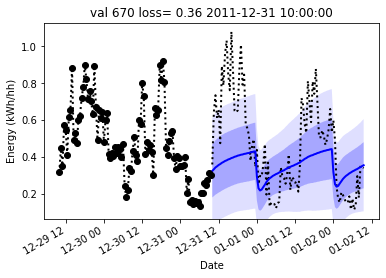

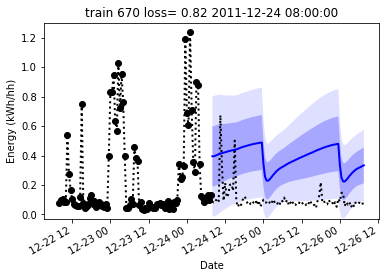

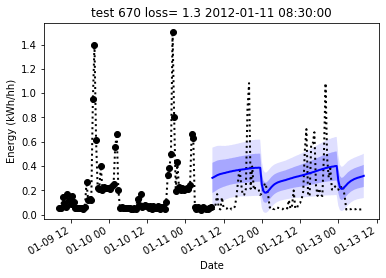

INFO:predict_heading2:step 0, {'agg_test_loss': 2.7945756912231445, 'log': {'agg_test_loss': 2.7945756912231445, 'agg_test_loss_p_weighted': 0.5217891335487366, 'agg_test_loss_p': 2.7945756912231445, 'agg_test_loss_mse': 0.05672752484679222, 'agg_test_score': 2.7945756912231445}}
----------------------------------------------------------------------------------------------------
TEST RESULTS
{}
----------------------------------------------------------------------------------------------------



anp-rnn_c_mean  anp-rnn_mean  anp-rnn_no_det_mean  \
agg_test_loss                   0.136772      0.317853             0.384540   
agg_test_loss_p                 0.136680      0.308816             0.344658   
agg_test_loss_kl                0.000092      0.009037             0.039882   
agg_test_loss_mse               0.053102      0.044686             0.051930   
agg_test_loss_p_weighted        0.025883      0.060492             0.063805   
agg_test_score                  0.136680      0.308816             0.344658   
n                               3.000000      3.000000             3.000000   

                          anp-rnn_d_mean  anp_c_mean  \
agg_test_loss                   0.394125    0.557549   
agg_test_loss_p                 0.387186    0.548468   
agg_test_loss_kl                0.006939    0.009081   
agg_test_loss_mse               0.045177    0.046734   
agg_test_loss_p_weighted        0.069565    0.104916   
agg_test_score                  0.387186    0.548468   
n                               3.000000    3.000000   

                          TransformerSeq2Seq_PL_lstm_mean  \
agg_test_loss                                    0.604279   
agg_test_loss_p                                  0.604279   
agg_test_loss_kl                                      NaN   
agg_test_loss_mse                                0.047913   
agg_test_loss_p_weighted                         0.114480   
agg_test_score                                   0.604279   
n                                                3.000000   

                          TransformerSeq2Seq_PL_mean  \
agg_test_loss                               0.616397   
agg_test_loss_p                             0.616397   
agg_test_loss_kl                                 NaN   
agg_test_loss_mse                           0.059609   
agg_test_loss_p_weighted                    0.116793   
agg_test_score                              0.616397   
n                                           3.000000   

                          anp-rnn_extras_no_det_mean  anp-rnn_extras_mean  \
agg_test_loss                               1.026797             1.022596   
agg_test_loss_p                             0.965398             1.022002   
agg_test_loss_kl                            0.061399             0.000594   
agg_test_loss_mse                           0.053994             0.166312   
agg_test_loss_p_weighted                    0.185951             0.183035   
agg_test_score                              0.965398             1.022002   
n                                           3.000000             3.000000   

                           np_mean  anp-rnn_pt_mean  LSTM_PL_STD_mean  \
agg_test_loss             1.119962         1.157510          1.501192   
agg_test_loss_p           1.093251         1.142826          1.501192   
agg_test_loss_kl          0.026712         0.014684               NaN   
agg_test_loss_mse         0.057514         0.045285          0.064205   
agg_test_loss_p_weighted  0.200654         0.214536          0.274459   
agg_test_score            1.093251         1.142826          1.501192   
n                         3.000000         3.000000          3.000000   

                          PL_Transformer_mean  LSTMSeq2Seq_PL_attn_mean  \
agg_test_loss                        1.539625                  2.024737   
agg_test_loss_p                      1.539625                  2.024737   
agg_test_loss_kl                          NaN                       NaN   
agg_test_loss_mse                    0.070719                  0.050012   
agg_test_loss_p_weighted             0.293302                  0.380252   
agg_test_score                       1.539625                  2.024737   
n                                    3.000000                  3.000000   

                          LSTMSeq2Seq_PL_mean  
agg_test_loss                        2.612948  
agg_test_loss_p                      2.612948  
agg_test_loss_kl                          NaN  
agg_test_lo

In [12]:
for i in range(N):
    for exp in experiments:
        print(i, exp)
        trial, trainer, model = run_trial(
            user_attrs = default_user_attrs,
            number=number*i*100-1000,
            **exp)

        name = trainer.logger.name
        r=trainer.logger.metrics[-1]
        if 'agg_test_score' in r:
            results[name].append(r)

            display(summarize_results(results))

In [13]:
display(summarize_results(results))

anp-rnn_c_mean  anp-rnn_mean  anp-rnn_no_det_mean  \
agg_test_loss                   0.136772      0.317853             0.384540   
agg_test_loss_p                 0.136680      0.308816             0.344658   
agg_test_loss_kl                0.000092      0.009037             0.039882   
agg_test_loss_mse               0.053102      0.044686             0.051930   
agg_test_loss_p_weighted        0.025883      0.060492             0.063805   
agg_test_score                  0.136680      0.308816             0.344658   
n                               3.000000      3.000000             3.000000   

                          anp-rnn_d_mean  anp_c_mean  \
agg_test_loss                   0.394125    0.557549   
agg_test_loss_p                 0.387186    0.548468   
agg_test_loss_kl                0.006939    0.009081   
agg_test_loss_mse               0.045177    0.046734   
agg_test_loss_p_weighted        0.069565    0.104916   
agg_test_score                  0.387186    0.548468   
n                               3.000000    3.000000   

                          TransformerSeq2Seq_PL_lstm_mean  \
agg_test_loss                                    0.604279   
agg_test_loss_p                                  0.604279   
agg_test_loss_kl                                      NaN   
agg_test_loss_mse                                0.047913   
agg_test_loss_p_weighted                         0.114480   
agg_test_score                                   0.604279   
n                                                3.000000   

                          TransformerSeq2Seq_PL_mean  \
agg_test_loss                               0.616397   
agg_test_loss_p                             0.616397   
agg_test_loss_kl                                 NaN   
agg_test_loss_mse                           0.059609   
agg_test_loss_p_weighted                    0.116793   
agg_test_score                              0.616397   
n                                           3.000000   

                          anp-rnn_extras_no_det_mean  anp-rnn_extras_mean  \
agg_test_loss                               1.026797             1.022596   
agg_test_loss_p                             0.965398             1.022002   
agg_test_loss_kl                            0.061399             0.000594   
agg_test_loss_mse                           0.053994             0.166312   
agg_test_loss_p_weighted                    0.185951             0.183035   
agg_test_score                              0.965398             1.022002   
n                                           3.000000             3.000000   

                           np_mean  anp-rnn_pt_mean  LSTM_PL_STD_mean  \
agg_test_loss             1.119962         1.157510          1.501192   
agg_test_loss_p           1.093251         1.142826          1.501192   
agg_test_loss_kl          0.026712         0.014684               NaN   
agg_test_loss_mse         0.057514         0.045285          0.064205   
agg_test_loss_p_weighted  0.200654         0.214536          0.274459   
agg_test_score            1.093251         1.142826          1.501192   
n                         3.000000         3.000000          3.000000   

                          PL_Transformer_mean  LSTMSeq2Seq_PL_attn_mean  \
agg_test_loss                        1.539625                  2.024737   
agg_test_loss_p                      1.539625                  2.024737   
agg_test_loss_kl                          NaN                       NaN   
agg_test_loss_mse                    0.070719                  0.050012   
agg_test_loss_p_weighted             0.293302                  0.380252   
agg_test_score                       1.539625                  2.024737   
n                                    3.000000                  3.000000   

                          LSTMSeq2Seq_PL_mean  
agg_test_loss                        2.612948  
agg_test_loss_p                      2.612948  
agg_test_loss_kl                          NaN  
agg_test_lo

In [14]:
result_dfs = []
for k in results:
    v = results[k]
    df = pd.DataFrame(v).mean()
    df = pd.concat([pd.DataFrame(v).mean().rename(lambda x:'mean_' + x),
    pd.DataFrame(v).std().rename(lambda x:'std_' + x),
    pd.DataFrame(v).min().rename(lambda x:'min_' + x)])

    df.name = k
    df['n'] = len(v)
    result_dfs.append(df)

#         df = pd.DataFrame(v).std()
#         df.name = k+'_std'
#         df['n'] = len(v)
#         result_dfs.append(df)


result_df = pd.concat(result_dfs, 1).T
result_df.sort_values('min_agg_test_score').T

anp-rnn_d  anp-rnn_pt        np   anp-rnn  \
mean_agg_test_loss              0.394125    1.157510  1.119962  0.317853   
mean_agg_test_loss_p            0.387186    1.142826  1.093251  0.308816   
mean_agg_test_loss_kl           0.006939    0.014684  0.026712  0.009037   
mean_agg_test_loss_mse          0.045177    0.045285  0.057514  0.044686   
mean_agg_test_loss_p_weighted   0.069565    0.214536  0.200654  0.060492   
mean_agg_test_score             0.387186    1.142826  1.093251  0.308816   
std_agg_test_loss               0.878401    1.519177  1.437127  0.522705   
std_agg_test_loss_p             0.877643    1.516836  1.443667  0.523407   
std_agg_test_loss_kl            0.000762    0.007138  0.009428  0.003586   
std_agg_test_loss_mse           0.004977    0.004380  0.014817  0.006400   
std_agg_test_loss_p_weighted    0.162863    0.292745  0.260571  0.100775   
std_agg_test_score              0.877643    1.516836  1.443667  0.523407   
min_agg_test_loss              -0.173291   -0.154892 -0.064523 -0.085768   
min_agg_test_loss_p            -0.179809   -0.162378 -0.102117 -0.098359   
min_agg_test_loss_kl            0.006480    0.007486  0.020982  0.005420   
min_agg_test_loss_mse           0.041679    0.041235  0.043198  0.040310   
min_agg_test_loss_p_weighted   -0.036278   -0.028847 -0.018044 -0.023358   
min_agg_test_score             -0.179809   -0.162378 -0.102117 -0.098359   
n                               3.000000    3.000000  3.000000  3.000000   

                                  anp_c  anp-rnn_extras_no_det  \
mean_agg_test_loss             0.557549               1.026797   
mean_agg_test_loss_p           0.548468               0.965398   
mean_agg_test_loss_kl          0.009081               0.061399   
mean_agg_test_loss_mse         0.046734               0.053994   
mean_agg_test_loss_p_weighted  0.104916               0.185951   
mean_agg_test_score            0.548468               0.965398   
std_agg_test_loss              0.792761               1.387746   
std_agg_test_loss_p            0.793772               1.341249   
std_agg_test_loss_kl           0.002901               0.046567   
std_agg_test_loss_mse          0.003336               0.003764   
std_agg_test_loss_p_weighted   0.151634               0.247277   
std_agg_test_score             0.793772               1.341249   
min_agg_test_loss             -0.042438               0.008417   
min_agg_test_loss_p           -0.049908              -0.016609   
min_agg_test_loss_kl           0.007343               0.025026   
min_agg_test_loss_mse          0.044065               0.050700   
min_agg_test_loss_p_weighted  -0.006404               0.006162   
min_agg_test_score            -0.049908              -0.016609   
n                              3.000000               3.000000   

                               anp-rnn_no_det     anp-rnn_c  anp-rnn_extras  \
mean_agg_test_loss                   0.384540  1.367723e-01        1.022596   
mean_agg_test_loss_p                 0.344658  1.366804e-01        1.022002   
mean_agg_test_loss_kl                0.039882  9.193924e-05        0.000594   
mean_agg_test_loss_mse               0.051930  5.310189e-02        0.166312   
mean_agg_test_loss_p_weighted        0.063805  2.588282e-02        0.183035   
mean_agg_test_score                  0.344658  1.366804e-01        1.022002   
std_agg_test_loss                    0.283161  1.653911e-01        1.346382   
std_agg_test_loss_p                  0.284554  1.654854e-01        1.346799   
std_agg_test_loss_kl                 0.015584  1.519699e-04        0.000827   
std_agg_test_loss_mse                0.003725  2.467975e-03        0.198156   
std_agg_test_loss_p_weighted         0.055251  3.120351e-02        0.238329   
std_agg_test_score                   0.284554  1.654854e-01        1.346799   
min_agg_test_loss                    0.060436  2.246629e-02        0.052776   
min_agg_test_loss_p                  0.017075  2.219893e-02        0.051237   
min_

# Manual exp

In [15]:
number=None

# Hyperparam

In [16]:
from neural_processes.train import objective
import argparse 

In [17]:
optuna_path = Path('./optuna_result2')
optuna_path.mkdir(exist_ok=True)

[I 2020-07-05 10:57:56,859] A new study created with name: TransformerSeq2Seq_PL


INFO:root:GPU available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:root:
  | Name   | Type                  | Params
---------------------------------------------
0 | _model | TransformerSeq2SeqNet | 1 M   


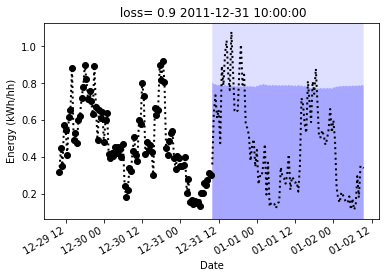

INFO:predict_heading2:val step=0, val={'agg_val_loss': 0.87, 'log': {'agg_val_loss': 0.87, 'agg_val_loss_p': 0.87, 'agg_val_loss_mse': 0.25, 'agg_val_loss_p_weighted': 0.16}} tain={}


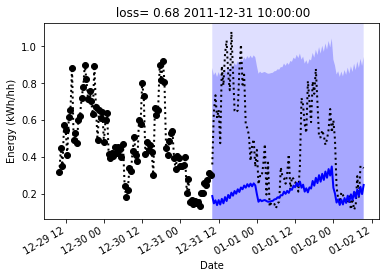

INFO:predict_heading2:val step=799, val={'agg_val_loss': 0.64, 'log': {'agg_val_loss': 0.64, 'agg_val_loss_p': 0.64, 'agg_val_loss_mse': 0.086, 'agg_val_loss_p_weighted': 0.12}} tain={}


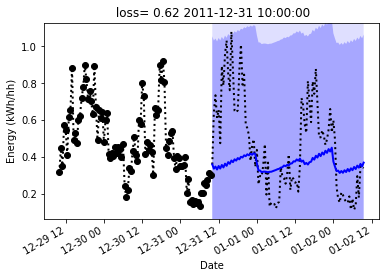

INFO:predict_heading2:val step=1599, val={'agg_val_loss': 0.62, 'log': {'agg_val_loss': 0.62, 'agg_val_loss_p': 0.62, 'agg_val_loss_mse': 0.06, 'agg_val_loss_p_weighted': 0.12}} tain={}


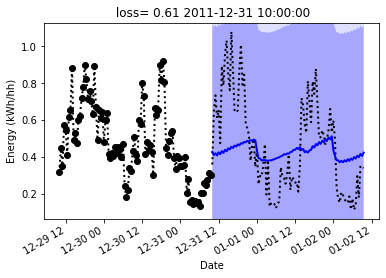

INFO:predict_heading2:val step=2399, val={'agg_val_loss': 0.61, 'log': {'agg_val_loss': 0.61, 'agg_val_loss_p': 0.61, 'agg_val_loss_mse': 0.056, 'agg_val_loss_p_weighted': 0.12}} tain={}


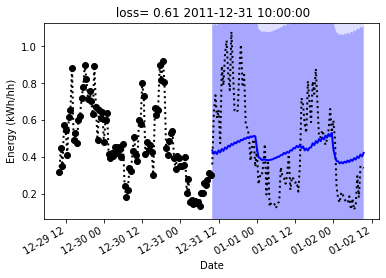

INFO:predict_heading2:val step=3199, val={'agg_val_loss': 0.61, 'log': {'agg_val_loss': 0.61, 'agg_val_loss_p': 0.61, 'agg_val_loss_mse': 0.054, 'agg_val_loss_p_weighted': 0.12}} tain={}


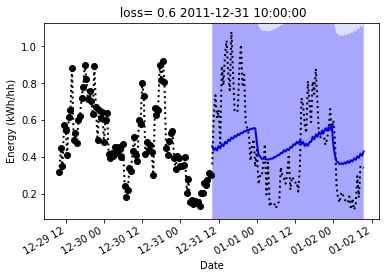

INFO:predict_heading2:val step=3999, val={'agg_val_loss': 0.61, 'log': {'agg_val_loss': 0.61, 'agg_val_loss_p': 0.61, 'agg_val_loss_mse': 0.051, 'agg_val_loss_p_weighted': 0.12}} tain={}


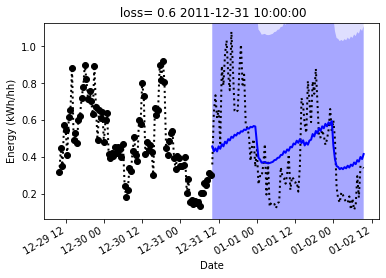

INFO:predict_heading2:val step=4799, val={'agg_val_loss': 0.6, 'log': {'agg_val_loss': 0.6, 'agg_val_loss_p': 0.6, 'agg_val_loss_mse': 0.047, 'agg_val_loss_p_weighted': 0.11}} tain={}


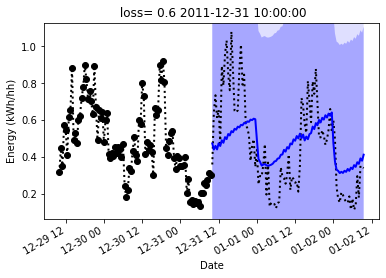

INFO:predict_heading2:val step=5599, val={'agg_val_loss': 0.6, 'log': {'agg_val_loss': 0.6, 'agg_val_loss_p': 0.6, 'agg_val_loss_mse': 0.045, 'agg_val_loss_p_weighted': 0.11}} tain={}


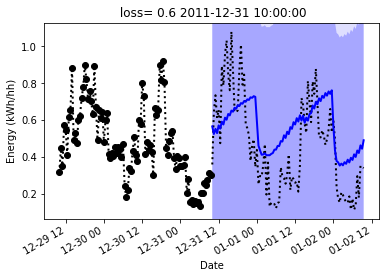

INFO:predict_heading2:val step=6399, val={'agg_val_loss': 0.6, 'log': {'agg_val_loss': 0.6, 'agg_val_loss_p': 0.6, 'agg_val_loss_mse': 0.046, 'agg_val_loss_p_weighted': 0.11}} tain={}


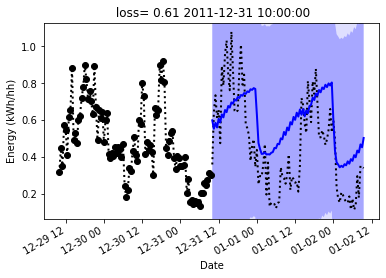

INFO:predict_heading2:val step=7199, val={'agg_val_loss': 0.6, 'log': {'agg_val_loss': 0.6, 'agg_val_loss_p': 0.6, 'agg_val_loss_mse': 0.046, 'agg_val_loss_p_weighted': 0.11}} tain={}


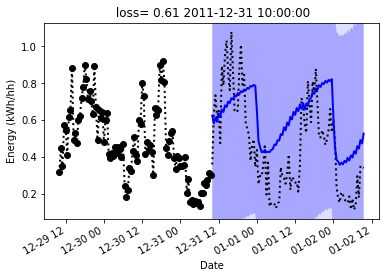

INFO:predict_heading2:val step=7999, val={'agg_val_loss': 0.6, 'log': {'agg_val_loss': 0.6, 'agg_val_loss_p': 0.6, 'agg_val_loss_mse': 0.047, 'agg_val_loss_p_weighted': 0.11}} tain={}
Epoch     9: reducing learning rate of group 0 to 1.6585e-06.


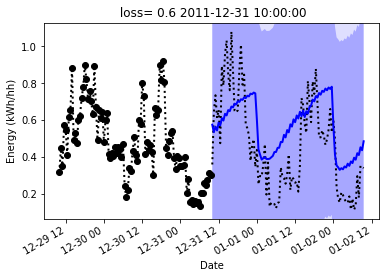

INFO:predict_heading2:val step=8799, val={'agg_val_loss': 0.6, 'log': {'agg_val_loss': 0.6, 'agg_val_loss_p': 0.6, 'agg_val_loss_mse': 0.045, 'agg_val_loss_p_weighted': 0.11}} tain={}


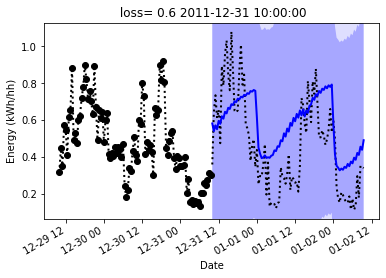

INFO:predict_heading2:val step=9599, val={'agg_val_loss': 0.6, 'log': {'agg_val_loss': 0.6, 'agg_val_loss_p': 0.6, 'agg_val_loss_mse': 0.044, 'agg_val_loss_p_weighted': 0.11}} tain={}


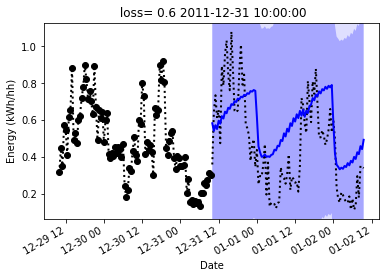

INFO:predict_heading2:val step=10399, val={'agg_val_loss': 0.6, 'log': {'agg_val_loss': 0.6, 'agg_val_loss_p': 0.6, 'agg_val_loss_mse': 0.045, 'agg_val_loss_p_weighted': 0.11}} tain={}


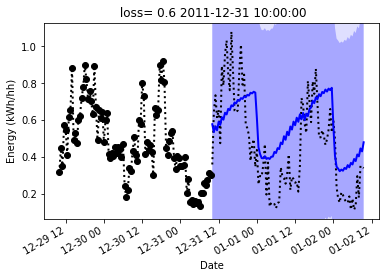

INFO:predict_heading2:val step=11199, val={'agg_val_loss': 0.6, 'log': {'agg_val_loss': 0.6, 'agg_val_loss_p': 0.6, 'agg_val_loss_mse': 0.045, 'agg_val_loss_p_weighted': 0.11}} tain={}


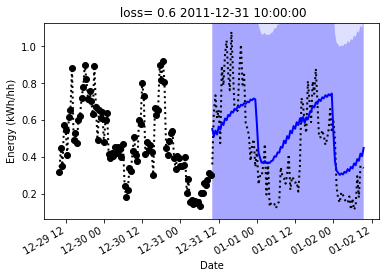

INFO:predict_heading2:val step=11999, val={'agg_val_loss': 0.6, 'log': {'agg_val_loss': 0.6, 'agg_val_loss_p': 0.6, 'agg_val_loss_mse': 0.044, 'agg_val_loss_p_weighted': 0.11}} tain={}
Epoch    14: reducing learning rate of group 0 to 1.6585e-07.


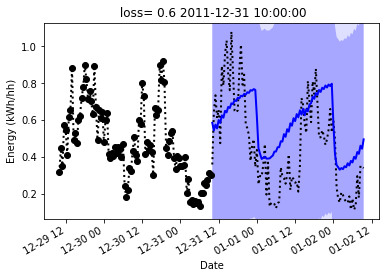

INFO:predict_heading2:val step=12799, val={'agg_val_loss': 0.6, 'log': {'agg_val_loss': 0.6, 'agg_val_loss_p': 0.6, 'agg_val_loss_mse': 0.045, 'agg_val_loss_p_weighted': 0.11}} tain={}


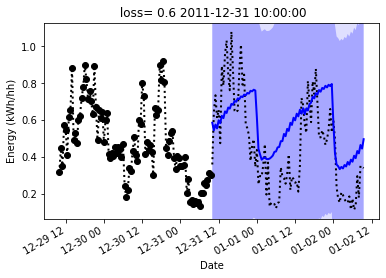

INFO:predict_heading2:val step=13599, val={'agg_val_loss': 0.6, 'log': {'agg_val_loss': 0.6, 'agg_val_loss_p': 0.6, 'agg_val_loss_mse': 0.045, 'agg_val_loss_p_weighted': 0.11}} tain={}


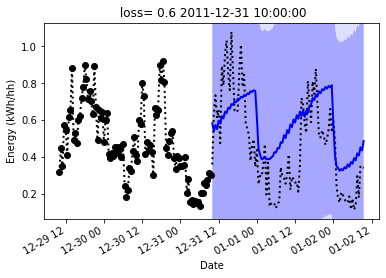

INFO:predict_heading2:val step=14399, val={'agg_val_loss': 0.6, 'log': {'agg_val_loss': 0.6, 'agg_val_loss_p': 0.6, 'agg_val_loss_mse': 0.045, 'agg_val_loss_p_weighted': 0.11}} tain={}
Epoch    17: reducing learning rate of group 0 to 1.0000e-07.


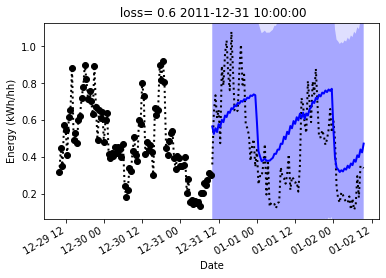

INFO:predict_heading2:val step=15199, val={'agg_val_loss': 0.6, 'log': {'agg_val_loss': 0.6, 'agg_val_loss_p': 0.6, 'agg_val_loss_mse': 0.045, 'agg_val_loss_p_weighted': 0.11}} tain={}


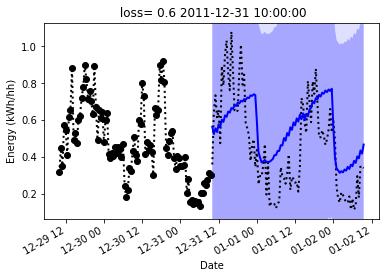

INFO:predict_heading2:val step=15999, val={'agg_val_loss': 0.6, 'log': {'agg_val_loss': 0.6, 'agg_val_loss_p': 0.6, 'agg_val_loss_mse': 0.044, 'agg_val_loss_p_weighted': 0.11}} tain={}

INFO:predict_heading2:Loading checkpoint lightning_logs/TransformerSeq2Seq_PL/version_0/_ckpt_epoch_19.ckpt


INFO:predict_heading2:step 16000, {'agg_test_loss': 0.6009575724601746, 'log': {'agg_test_loss': 0.6009575724601746, 'agg_test_loss_p': 0.6009575724601746, 'agg_test_loss_mse': 0.04470730945467949, 'agg_test_loss_p_weighted': 0.11388392746448517, 'agg_test_score': 0.6009575724601746}}
----------------------------------------------------------------------------------------------------
TEST RESULTS
{}
----------------------------------------------------------------------------------------------------

INFO:predict_heading2:logger.metrics [{'agg_test_loss': 0.6009575724601746, 'agg_test_loss_p': 0.6009575724601746, 'agg_test_loss_mse': 0.04470730945467949, 'agg_test_loss_p_weighted': 0.11388392746448517, 'agg_test_score': 0.6009575724601746}]


[I 2020-07-05 11:30:11,682] Finished trial#0 resulted in value: 0.6009575724601746. Current best value is 0.6009575724601746 with parameters: {'agg': 'mean', 'attention_dropout': 0.6780359048806396, 'hidden_out_size_power': 7.0, 'hidden_size_power': 8.0, 'learning_rate': 1.6584803023517798e-05, 'nhead_power': 3.0, 'nlayers': 3, 'use_lstm': True}.


INFO:root:GPU available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:root:
  | Name   | Type                  | Params
---------------------------------------------
0 | _model | TransformerSeq2SeqNet | 73 M  


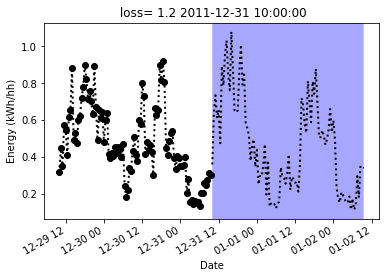

INFO:predict_heading2:val step=0, val={'agg_val_loss': 1.2, 'log': {'agg_val_loss': 1.2, 'agg_val_loss_p': 1.2, 'agg_val_loss_mse': 0.25, 'agg_val_loss_p_weighted': 0.22}} tain={}


[W 2020-07-05 11:30:27,959] Setting status of trial#1 as TrialState.FAIL because of the following error: RuntimeError('CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 10.76 GiB total capacity; 8.25 GiB already allocated; 15.38 MiB free; 156.57 MiB cached)')
Traceback (most recent call last):
  File "/home/wassname/.pyenv/versions/jup3.7.3/lib/python3.7/site-packages/optuna/study.py", line 569, in _run_trial
    result = func(trial)
  File "/media/wassname/Storage5/projects2/3ST/attentive-neural-processes/neural_processes/train.py", line 68, in objective
    model, trainer = main(trial, PL_MODEL_CLS=PL_MODEL_CLS, name=name)
  File "/media/wassname/Storage5/projects2/3ST/attentive-neural-processes/neural_processes/train.py", line 56, in main
    trainer.fit(model)
  File "/home/wassname/.pyenv/versions/jup3.7.3/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py", line 602, in fit
    self.single_gpu_train(model)
  File "/home/wassname/.pyenv/versions/jup3.7.3/lib/py

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 10.76 GiB total capacity; 8.25 GiB already allocated; 15.38 MiB free; 156.57 MiB cached)

In [18]:
for PL_MODEL_CLS in [TransformerSeq2Seq_PL, PL_ANPRNN]:
    name = str(PL_MODEL_CLS.__name__)
    func = functools.partial(objective,
                             PL_MODEL_CLS=PL_MODEL_CLS,
                             name=name,
                             user_attrs=default_user_attrs)

    parser = argparse.ArgumentParser(description='PyTorch Lightning example.')
    parser.add_argument(
        '--pruning',
        '-p',
        action='store_true',
        help='Activate the pruning feature. `MedianPruner` stops unpromising '
        'trials at the early stages of training.')
    args = parser.parse_args(['-p'])

    pruner = optuna.pruners.MedianPruner(
        n_warmup_steps=1,
        n_startup_trials=6) if args.pruning else optuna.pruners.NopPruner()
    pruner = optuna.pruners.PercentilePruner(75.0)

    study = optuna.create_study(direction='minimize',
                                pruner=pruner,
                                storage=f'sqlite:///{optuna_path}/{name}.db',
                                study_name=name,
                                load_if_exists=True)

#     1/0
    study.optimize(func=func,
                   n_trials=200,
                   timeout=pd.Timedelta('0.5d').total_seconds())

    print('Number of finished trials: {}'.format(len(study.trials)))

    print('Best trial:')
    trial = study.best_trial

    print('  Value: {}'.format(trial.value))

    print('  Params: ')
    for key, value in trial.params.items():
        print('    {}: {}'.format(key, value))

    # shutil.rmtree(MODEL_DIR)

    df = study.trials_dataframe(attrs=('number', 'value', 'params', 'state'))
    print(df.sort_values('value'))

In [ ]:
PL_MODEL_CLS

In [ ]:
df = study.trials_dataframe(attrs=('number', 'value', 'params', 'state'))
df.sort_values('value')